<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Volkswagen/Volkswagen_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VOW3.DE"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   39.26   40.82   38.70   40.51      31.14   218716
2009-01-05   41.59   42.14   40.01   41.25      31.71   209067
2009-01-06   41.75   45.72   41.68   43.29      33.28   288578
2009-01-07   43.92   43.92   39.96   40.11      30.84   361894
2009-01-08   39.76   41.38   38.02   40.61      31.22   412698
...            ...     ...     ...     ...        ...      ...
2018-12-19  146.68  148.84  146.42  146.88     142.09   986274
2018-12-20  145.00  145.64  143.10  143.90     139.21  1328154
2018-12-21  142.48  146.74  141.12  143.30     138.63  2650052
2018-12-27  143.38  143.50  136.28  137.44     132.96  1608052
2018-12-28  138.40  140.08  138.00  138.92     134.39   614699

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean    135.353954   137.014762   133.395002   135.225821   119.724931  1.213240e+06
std      45.234245    45.417521    44.947795    45.181281    42.615989  8.427740e+05
min      30.420000    31.230000    29.370000    30.060000    23.110000  0.000000e+00
25%     113.050000   115.000000   110.550000   112.700000    96.400000  7.832235e+05
50%     137.450000   138.920000   136.040000   137.450000   123.370000  1.049929e+06
75%     168.400000   170.425000   166.725000   168.400000   151.550000  1.442698e+06
max     259.500000   262.450000   249.550000   255.200000   227.360000  1.419737e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   37.21   37.24   35.43   36.17      27.81   275564   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   34.527874   34.699004   29.805312   34.686089   34.406214   34.391442      33.115      33.305   30.473296   33.61125   35.533463   32.7025   34.022500   33.61125   35.886667   34.693839               38.531336                 33.61125               28.691164               40.991379                 33.61125               26.231121               43.451421                 33.61125               23.771079               45.911464                 33.61125               21.311036   34.406214   35.426659   34.477538               39.326300                34.406214               29.486128               41.786343                34.406214               27.026085               44.246385                34.406214               24.566042               46.706428   
2009-03-16   37.23   38.10   35.79   36.54      28.09   256645   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   34.628480   34.697241   30.251393   35.466872   34.880389   34.405964      33.300      33.735   31.014632   33.65750   36.364414   33.3960   34.673333   33.65750   36.355000   34.604965               38.678842                 33.65750               28.636158               41.189513                 33.65750               26.125487               43.700184                 33.65750               23.614816               46.210855                 33.65750               21.104145   34.880389   36.326528   34.418129               39.901731                34.880389               29.859047               42.412402                34.880389               27.348376               44.923073                34.880389               24.837705               47.433744   
2009-03-17   36.28   36.45   34.64   35.50      27.29   404533

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean    137.331748   139.005147   135.361410   137.206043   121.563978  1.232620e+06    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020   137.149943   136.840632    -6.201593   137.209500   137.053010   137.189260   137.028365   136.852151   136.460588   137.053702   137.208762   137.054483   137.105705   137.053702   137.162378   136.739291              142.759089               137.053702              131.348314              145.611783               137.053702              128.495620              148.464477               137.053702              125.642927              151.317171               137.053702              122.790233   137.053010   137.171210   136.786470              142.758397               137.053010              131.347622              145.611091               137.053010              128.494928              148.463785   
std      43.455707    43.621256    43.178022    43.393970    40.996706  8.397361e+05     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    43.344917    43.356178   143.968355    43.457886    43.365660    43.523754    43.409125    43.353092    43.779427    43.434783    43.428249    43.465111    43.397943    43.434783    43.391670    43.522842               44.242137                43.434783               42.931093               44.754794                43.434783               42.796726               45.336936                43.434783               42.741806               45.985922                43.434783               42.766638    43.365660    43.374699    43.510302               44.166384                43.365660               42.869291               44.676009                43.365660               42.738808               45.255312   
min      34.670000    35.680000    33.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.011297  0.006879  0.008474  0.006396   0.005433   275564   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000012  0.582182  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.003414  0.000584                0.007893                 0.000000                0.000258                0.015766                 0.000000                0.000496                0.023075                 0.000000                0.000733                0.029879                 0.000000                0.090261  0.000000  0.001119  0.000281                0.013363                 0.000000                0.000000                0.021002                 0.000000                0.000000                0.028098                 0.000000                0.017781                0.034708                 0.000000   
2009-03-16  0.011386  0.010672  0.010141  0.008075   0.006828   256645   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000474  0.000003  0.583071  0.003593  0.002222  0.000068    0.000859    0.001981  0.002334  0.000216  0.003795  0.003207  0.003031  0.000216  0.005556  0.000163                0.008554                 0.000216                0.000000                0.016621                 0.000216                0.000000                0.024110                 0.000216                0.000000                0.031082                 0.000216                0.089379  0.002222  0.005265  0.000000                0.015916                 0.002222                0.001758                0.023678                 0.002222                0.001521                0.030888                 0.002222                0.019038                0.037603                 0.002222   
2009-03-17  0.007161  0.003396  0.004816  0.003357  

139934

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpm0jrum38
  JVM stdout: /tmp/tmpm0jrum38/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpm0jrum38/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_rah91c
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.559387  0.690237              0.500000  0.498435  0.248437
1  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.558740  0.689953              0.478361  0.498403  0.248405
2              DeepLearning_1_AutoML_20190828_181623  0.547031  0.881999              0.500000  0.545647  0.297731
3  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.538103  0.691605              0.500000  0.499228  0.249229
4  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.516626  0.951995              0.496183  0.589691  0.347736
5  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.512938  1.536310              0.489391  0.623793  0.389117
6  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.500000  0.692732              0.500000  0.499792  0.249792
7  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.498059  0.707377              0.500000  0.506817  0.256864
8  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.472765  1.174807              0.500000  0.607675  0.369268
9  DeepLearning_grid_1_AutoML_20190828_181623_mod...  0.471212  0.737981              0.500000  0.520694  0.271122

variable  relative_importance  scaled_importance  percentage
0                  aroonup_20             1.000000           1.000000    0.001854
1                   CORREL_24             0.980516           0.980516    0.001818
2                         SIN             0.969412           0.969412    0.001797
3                HT_TRENDMODE             0.946107           0.946107    0.001754
4         CDLGAPSIDESIDEWHITE             0.915776           0.915776    0.001698
...                       ...                  ...                ...         ...
1033                  MA_14_3             0.436746           0.436746    0.000810
1034  BBANDS_lowerband_24_3_2             0.433262           0.433262    0.000803
1035                   TSF_12             0.429029           0.429029    0.000795
1036            MINMAX_min_12             0.427093           0.427093    0.000792
1037                  MA_12_5             0.425391           0.425391    0.000789

[1038 rows x 4 columns]

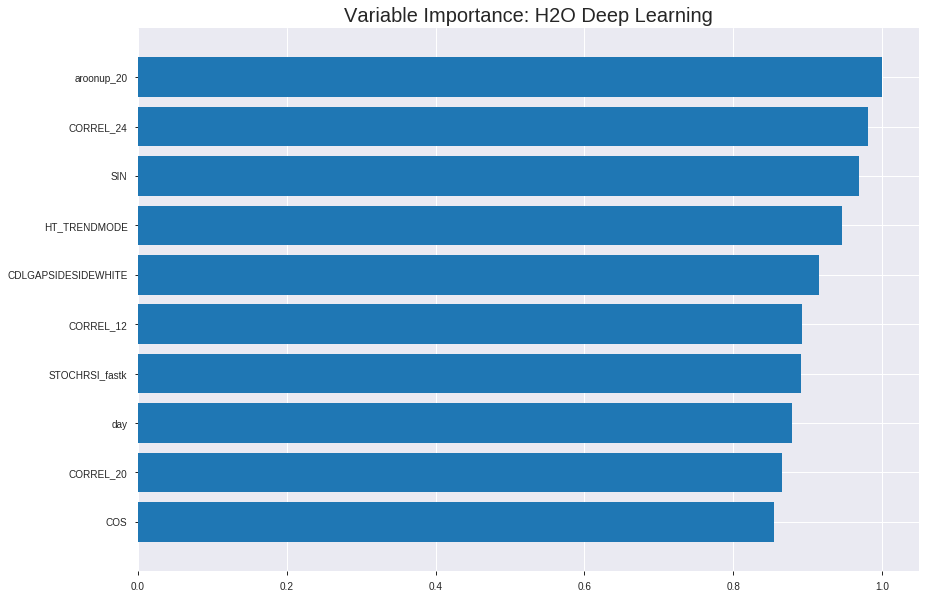

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_181623_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24811903600174942
RMSE: 0.49811548460346966
LogLoss: 0.6893720177144583
Mean Per-Class Error: 0.4450672230684607
AUC: 0.5594151963273251
pr_auc: 0.5706811722963226
Gini: 0.11883039265465012
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34142283170110144: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      61   771   0.9267   (771.0/832.0)
1      24   885   0.0264   (24.0/909.0)
Total  85   1656  0.4566   (795.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341423     0.690058  349
max f2                       0.223356     0.845896  395
max f0point5                 0.341423     0.587415  349
max accuracy                 0.52945      0.554279  165
max precision                0.706261     1         0
max recall                   0.223356     1         395
max specificity              0.706261     1         0
max absolute_mcc             0.52945      0.109792  165
max min_per_class_accuracy   0.525998     0.552255  169
max mean_per_class_accuracy  0.52945      0.554933  165

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 50.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.66549            1.27686   1.27686            0.666667         0.680782  0.666667                    0.680782            0.0132013       0.0132013                  27.6861   27.6861
    2        0.0201034                   0.652062           1.01398   1.14917            0.529412         0.658612  0.6                         0.670014            0.00990099      0.0231023                  1.39779   14.9175
    3        0.0304423                   0.644522           0.957646  1.08413            0.5              0.647711  0.566038                    0.662439            0.00990099      0.0330033                  -4.23542  8.41273
    4        0.0402068                   0.639947           1.12664   1.09445            0.588235         0.642179  0.571429                    0.657519            0.0110011       0.0440044                  12.6642   9.44523
    5        0.0505457                   0.634956           1.27686   1.13176            0.666667         0.637956  0.590909                    0.653517            0.0132013       0.0572057                  27.6861   13.1763
    6        0.100517                    0.610947           1.25485   1.19295            0.655172         0.622448  0.622857                    0.638071            0.0627063       0.119912                   25.4846   19.2953
    7        0.150488                    0.595683           1.12276   1.16964            0.586207         0.602482  0.610687                    0.626253            0.0561056       0.176018                   12.2757   16.9644
    8        0.20046                     0.5826             0.946638  1.11405            0.494253         0.588801  0.581662                    0.616917            0.0473047       0.223322                   -5.33617  11.4052
    9        0.300402                    0.562583           1.14477   1.12427            0.597701         0.571612  0.586998                    0.601844            0.114411        0.337734                   14.4772   12.4272
    10       0.400345                    0.547916           1.05671   1.10741            0.551724         0.555008  0.578192                    0.590152            0.105611        0.443344                   5.67126   10.7407
    11       0.500287                    0.526072           1.06772   1.09948            0.557471         0.537243  0.574053                    0.579582            0.106711        0.550055                   6.772     9.94785
    12       0.60023                     0.50246            0.902609  1.0667             0.471264         0.515264  0.556938                    0.568873            0.090209        0.640264                   -9.73913  6.66982
    13       0.700172                    0.469755           0.913616  1.04485            0.477011         0.486892  0.545529                    0.557171            0.0913091       0.731573                   -8.63839  4.48473
    14       0.800115                    0.425216           0.979661  1.0367             0.511494         0.44701   0.541278                    0.543411            0.0979098       0.829483                   -2.03394  3.67048
    15       0.900057                    0.378102           0.869586  1.01815            0.454023         0.401702  0.531589                    0.527675            0.0869087       0.916392                   -13.0414  1.8148
    16       1                           0.151258           0.836564  1                  0.436782         0.329441  0.522114                    0.507863          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25154918040326996
RMSE: 0.5015467878506151
LogLoss: 0.6963143228510734
Mean Per-Class Error: 0.4618473895582329
AUC: 0.5235238141320301
pr_auc: 0.5267296733000981
Gini: 0.04704762826406017
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.454478139665772: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   236  0.9478   (236.0/249.0)
1      6    243  0.0241   (6.0/249.0)
Total  19   479  0.4859   (242.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.454478     0.667582   380
max f2                       0.398444     0.833891   398
max f0point5                 0.491583     0.562717   345
max accuracy                 0.554447     0.538153   158
max precision                0.665968     1          0
max recall                   0.398444     1          398
max specificity              0.665968     1          0
max absolute_mcc             0.554447     0.0783114  158
max min_per_class_accuracy   0.541061     0.502008   198
max mean_per_class_accuracy  0.554447     0.538153   158

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 54.30 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100402                   0.657193           1.6      1.6                0.8              0.661967  0.8                         0.661967            0.0160643       0.0160643                  60       60
    2        0.0200803                   0.643473           1.2      1.4                0.6              0.651185  0.7                         0.656576            0.0120482       0.0281124                  20       40
    3        0.0301205                   0.636567           0.8      1.2                0.4              0.639711  0.6                         0.650954            0.00803213      0.0361446                  -20      20
    4        0.0401606                   0.628021           1.2      1.2                0.6              0.634449  0.6                         0.646828            0.0120482       0.0481928                  20       20
    5        0.0502008                   0.624362           1.2      1.2                0.6              0.626237  0.6                         0.64271             0.0120482       0.060241                   20       20
    6        0.100402                    0.60475            1.04     1.12               0.52             0.616615  0.56                        0.629662            0.0522088       0.11245                    4        12
    7        0.150602                    0.592098           0.96     1.06667            0.48             0.598573  0.533333                    0.619299            0.0481928       0.160643                   -4       6.66667
    8        0.200803                    0.582072           1.04     1.06               0.52             0.587639  0.53                        0.611384            0.0522088       0.212851                   4        6
    9        0.301205                    0.564444           1.04     1.05333            0.52             0.571789  0.526667                    0.598186            0.104418        0.317269                   4        5.33333
    10       0.399598                    0.553229           1.18367  1.08543            0.591837         0.558697  0.542714                    0.588462            0.116466        0.433735                   18.3673  8.54271
    11       0.5                         0.540887           0.72     1.01205            0.36             0.54607   0.506024                    0.57995             0.0722892       0.506024                   -28      1.20482
    12       0.600402                    0.530065           0.96     1.00334            0.48             0.535181  0.501672                    0.572463            0.0963855       0.60241                    -4       0.334448
    13       0.698795                    0.520193           1.06122  1.01149            0.530612         0.525352  0.505747                    0.56583             0.104418        0.706827                   6.12245  1.14943
    14       0.799197                    0.507579           1.12     1.02513            0.56             0.51369   0.512563                    0.55928             0.11245         0.819277                   12       2.51256
    15       0.899598                    0.486447           0.92     1.01339            0.46             0.499116  0.506696                    0.552565            0.0923695       0.911647                   -8       1.33929
    16       1                           0.391954           0.88     1                  0.44             0.457099  0.5                         0.54298             0.0883534       1                          -12      0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:20:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:20:25  3 min 54.434 sec  556 obs/sec       0.407237  1             709        0.701938         7.8276              -0.974729      0.47896         0.406744           0.638431         0.477886                         0.681864           3.5024                -0.859756        0.474186          0.465121             1.2                0.5
    2019-08-28 18:20:34  4 min  3.694 sec  440 obs/sec       2.45376   6             4272       0.573357         0.986204            -0.317529      0.517965        0.537298           1.17046          0.476738                         0.539666           0.810029              -0.164959        0.497371          0.508245             1.2                0.5
    2019-08-28 18:20:43  4 min 12.428 sec  490 obs/sec       4.96037   12            8636       0.587778         1.21965             -0.384639      0.469297        0.488928           0.532025         0.476738                         0.540507           0.800126              -0.168592        0.482565          0.483272             0.8                0.5
    2019-08-28 18:20:51  4 min 20.853 sec  513 obs/sec       7.44744   18            12966      0.520552         0.741447            -0.0860234     0.499904        0.524996           0.957646         0.475589                         0.509323           0.713386              -0.0376395       0.513024          0.510481             1.2                0.5
    2019-08-28 18:21:00  4 min 30.053 sec  534 obs/sec       10.3228   25            17972      0.498115         0.689372            0.0055787      0.559415        0.570681           1.27686          0.456634                         0.501547           0.696314              -0.00619672      0.523524          0.52673              1.6                0.485944
    2019-08-28 18:21:10  4 min 39.253 sec  549 obs/sec       13.243    32            23056      0.524773         0.77037             -0.103704      0.550003        0.559152           1.17046          0.475589                         0.507444           0.709086              -0.029998        0.525596          0.518327             1.2                0.491968
    2019-08-28 18:21:19  4 min 48.212 sec  561 obs/sec       16.1603   39            28135      0.522083         0.753092            -0.0924206     0.533018        0.544087           1.17046          0.476738                         0.514013           0.724469              -0.0568379       0.504008          0.503938             0.8                0.487952
    2019-08-28 18:21:27  4 min 56.896 sec  573 obs/sec       19.0902   46            33236      0.522758         0.752664            -0.0952464     0.503312        0.531025           1.27686          0.476163                         0.510202           0.715355              -0.0412235       0.485694          0.496111             1.2                0.491968
    2019-08-28 18:21:35  5 min  5.136 sec  

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
aroonup_20               1.0                    1.0                  0.001853685465356297
CORREL_24                0.9805156588554382     0.9805156588554382   0.0018175676253745791
SIN                      0.9694119095802307     0.9694119095802307   0.0017969847667321664
HT_TRENDMODE             0.9461069107055664     0.9461069107055664   0.0017537846290480565
CDLGAPSIDESIDEWHITE      0.9157764315605164     0.9157764315605164   0.0016975614606995848
---                      ---                    ---                  ---
MA_14_3                  0.43674570322036743    0.43674570322036743  0.00080958916211641
BBANDS_lowerband_24_3_2  0.4332616329193115     0.4332616329193115   0.0008031307916390631
TSF_12                   0.4290286600589752     0.4290286600589752   0.0007952841913726101
MINMAX_min_12            0.42709338665008545    0.42709338665008545  0.0007916968031830606
MA_12_5                  0.42539098858833313    0.42539098858833313  0.0007885410926397395


See the whole table with table.as_data_frame()


('accuracy', 0.5662650602409639)

('F1', 0.6430517711171662)

('auc', 0.5593867253202225)

('logloss', 0.6902372238763603)

('mean_per_class_error', 0.43669944365377145)

('rmse', 0.49843485279430555)

('mse', 0.24843730248008103)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


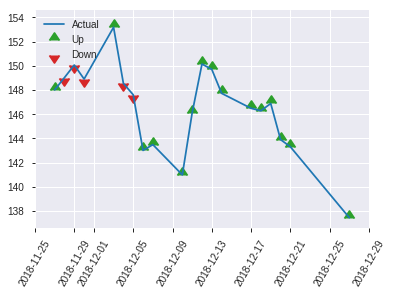


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24843730248008103
RMSE: 0.49843485279430555
LogLoss: 0.6902372238763603
Mean Per-Class Error: 0.43669944365377145
AUC: 0.5593867253202225
pr_auc: 0.5164916445337226
Gini: 0.11877345064044498
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.323158450534455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323158     0.643052  248
max f2                       0.323158     0.818308  248
max f0point5                 0.469219     0.553435  166
max accuracy                 0.509038     0.566265  105
max precision                0.554258     0.64      24
max recall                   0.323158     1         248
max specificity              0.604677     0.992366  0
max absolute_mcc             0.469219     0.134508  166
max min_per_class_accuracy   0.501554     0.542373  122
max mean_per_class_accuracy  0.469219     0.563301  166

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 48.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.590146           0.70339   0.70339            0.333333         0.597459  0.333333                    0.597459            0.00847458      0.00847458                 -29.661   -29.661
    2        0.0200803                   0.583351           1.05508   0.844068           0.5              0.585727  0.4                         0.592766            0.00847458      0.0169492                  5.50847   -15.5932
    3        0.0321285                   0.57693            1.40678   1.05508            0.666667         0.580501  0.5                         0.588167            0.0169492       0.0338983                  40.678    5.50847
    4        0.0401606                   0.573066           2.11017   1.2661             1                0.575579  0.6                         0.585649            0.0169492       0.0508475                  111.017   26.6102
    5        0.0522088                   0.56738            0.70339   1.13625            0.333333         0.571928  0.538462                    0.582483            0.00847458      0.059322                   -29.661   13.6245
    6        0.100402                    0.552232           1.58263   1.35051            0.75             0.558805  0.64                        0.571117            0.0762712       0.135593                   58.2627   35.0508
    7        0.15261                     0.543504           0.811604  1.16615            0.384615         0.547321  0.552632                    0.562976            0.0423729       0.177966                   -18.8396  16.6146
    8        0.200803                    0.536862           0.879237  1.09729            0.416667         0.540316  0.52                        0.557538            0.0423729       0.220339                   -12.0763  9.72881
    9        0.301205                    0.521389           1.09729   1.09729            0.52             0.527475  0.52                        0.547517            0.110169        0.330508                   9.72881   9.72881
    10       0.401606                    0.511935           1.2661    1.13949            0.6              0.515758  0.54                        0.539577            0.127119        0.457627                   26.6102   13.9492
    11       0.502008                    0.500521           0.928475  1.09729            0.44             0.505571  0.52                        0.532776            0.0932203       0.550847                   -7.15254  9.72881
    12       0.598394                    0.482788           1.14301   1.10465            0.541667         0.49205   0.52349                     0.526216            0.110169        0.661017                   14.3008   10.4652
    13       0.698795                    0.46222            0.928475  1.07934            0.44             0.472405  0.511494                    0.518484            0.0932203       0.754237                   -7.15254  7.93396
    14       0.799197                    0.436829           0.759661  1.03918            0.36             0.450204  0.492462                    0.509907            0.0762712       0.830508                   -24.0339  3.91789
    15       0.899598                    0.417705           0.675254  0.998562           0.32             0.427666  0.473214                    0.500728            0.0677966       0.898305                   -32.4746  -0.143765
    16       1                           0.323158           1.01288   1                  0.48             0.380435  0.473896                    0.48865       

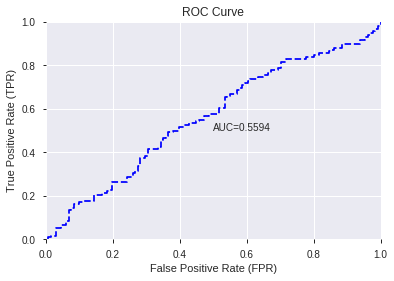

This function is available for GLM models only


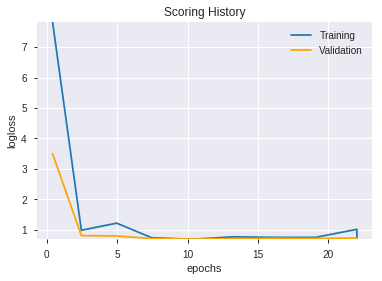

--2019-08-28 18:39:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.5MB/s    in 23s     

2019-08-28 18:39:52 (15.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_181623_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_181623_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_184047  0.539074  0.754365              0.500000  0.518638  0.268986
1  DeepLearning_grid_1_AutoML_20190828_184047_model_6  0.531440  0.722752              0.500000  0.511070  0.261192
2  DeepLearning_grid_1_AutoML_20190828_184047_model_8  0.524583  0.699452              0.500000  0.503067  0.253076
3  DeepLearning_grid_1_AutoML_20190828_184047_model_7  0.520701  0.960573              0.492787  0.565933  0.320280
4  DeepLearning_grid_1_AutoML_20190828_184047_model_9  0.510545  0.698222              0.500000  0.502163  0.252167
5  DeepLearning_grid_1_AutoML_20190828_184047_model_1  0.507504  1.092932              0.500000  0.572409  0.327652
6  DeepLearning_grid_1_AutoML_20190828_184047_model_2  0.499094  0.861083              0.485994  0.550363  0.302899
7  DeepLearning_grid_1_AutoML_20190828_184047_model_5  0.491331  0.709547              0.500000  0.507413  0.257468
8  DeepLearning_grid_1_AutoML_20190828_184047_model_4  0.485250  0.963091              0.500000  0.572409  0.327652
9  DeepLearning_grid_1_AutoML_20190828_184047_model_3  0.480528  0.855589              0.500000  0.537556  0.288967

variable  relative_importance  scaled_importance  percentage
0             CORREL_12             1.000000           1.000000    0.029652
1          aroondown_14             0.935287           0.935287    0.027733
2           HT_DCPERIOD             0.884095           0.884095    0.026215
3        CDLMORNINGSTAR             0.854093           0.854093    0.025325
4       CDLUNIQUE3RIVER             0.849047           0.849047    0.025176
5           CDLPIERCING             0.829280           0.829280    0.024590
6             CORREL_24             0.814921           0.814921    0.024164
7                   SIN             0.804495           0.804495    0.023855
8                   BOP             0.784986           0.784986    0.023276
9                   EXP             0.773066           0.773066    0.022923
10                  COS             0.757791           0.757791    0.022470
11            CORREL_30             0.751711           0.751711    0.022289
12                 week             0.744529           0.744529    0.022076
13              weekday             0.742524           0.742524    0.022017
14            CORREL_14             0.740634           0.740634    0.021961
15            CORREL_20             0.739526           0.739526    0.021928
16                ADX_8             0.737216           0.737216    0.021860
17       STOCHRSI_fastd             0.735469           0.735469    0.021808
18         HT_TRENDMODE             0.728914           0.728914    0.021614
19            dayofyear             0.724246           0.724246    0.021475
20          aroondown_8             0.716418           0.716418    0.021243
21            dayofweek             0.714857           0.714857    0.021197
22        days_in_month             0.711435           0.711435    0.021095
23           aroonup_14             0.695557           0.695557    0.020624
24  CDLGAPSIDESIDEWHITE             0.693394           0.693394    0.020560
25                DX_12             0.690985           0.690985    0.020489
26               SAREXT             0.673032           0.673032    0.019956
27                  day             0.672096           0.672096    0.019929
28           weekofyear             0.660625           0.660625    0.019589
29   CDLEVENINGDOJISTAR             0.649818           0.649818    0.019268
30                month             0.640643           0.640643    0.018996
31              quarter             0.633171           0.633171    0.018775
32         weekday_name             0.627564           0.627564    0.018608
33            aroonup_8             0.615514           0.615514    0.018251
34   CDLMORNINGDOJISTAR             0.606967           0.606967    0.017998
35     CDLDRAGONFLYDOJI             0.603687           0.603687    0.017900
36            CDLINNECK             0.592250           0.592250    0.017561
37            CDLHAMMER             0.586708           0.586708    0.017397
38               BETA_8             0.579476           0.579476    0.017182
39             CORREL_8             0.575905           0.575905    0.017077
40              BETA_14             0.575379           0.575379    0.017061
41               ADXR_8             0.574944           0.574944    0.017048
42           aroonup_20             0.569781           0.569781    0.016895
43            CDLTAKURI             0.532780           0.532780    0.015798
44       CDLSPINNINGTOP             0.522094           0.522094    0.015481
45         aroondown_20             0.469097           0.469097    0.013909
46       STOCHRSI_fastk             0.464504           0.464504    0.013773
47              BETA_12             0.442793           0.442793    0.013130
48    CDLLONGLEGGEDDOJI             0.434584           0.434584    0.012886
49            CDL2CROWS             0.267058           0.267058    0.007919

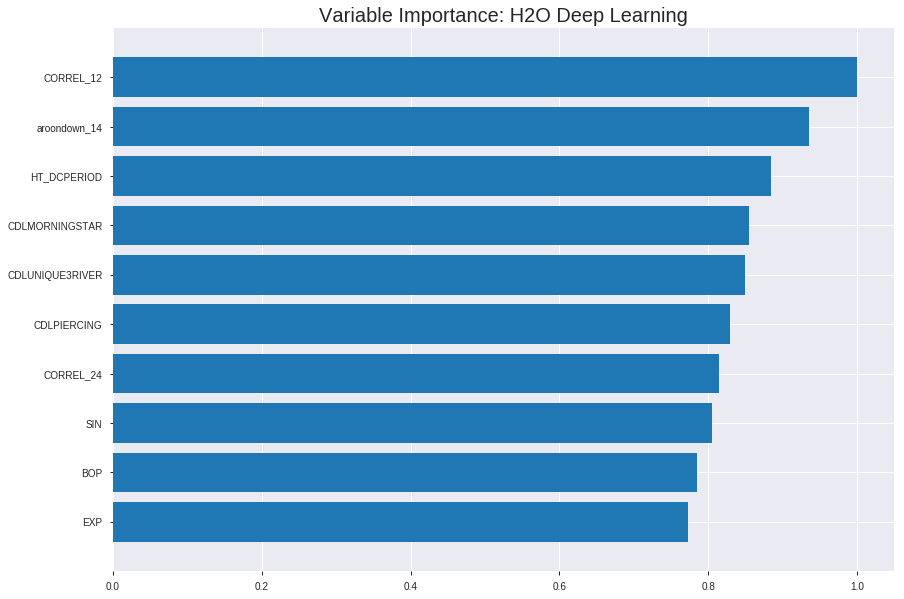

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_184047


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2457703251835056
RMSE: 0.49575228207594324
LogLoss: 0.6884638081333687
Mean Per-Class Error: 0.3911023313869848
AUC: 0.6385636159769823
pr_auc: 0.6472426499887074
Gini: 0.2771272319539646
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20134902797226237: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      93   739   0.8882   (739.0/832.0)
1      38   871   0.0418   (38.0/909.0)
Total  131  1610  0.4463   (777.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.201349     0.691544  348
max f2                       0.0483581    0.846068  392
max f0point5                 0.44108      0.623643  202
max accuracy                 0.44108      0.607122  202
max precision                0.975929     1         0
max recall                   0.0187901    1         396
max specificity              0.975929     1         0
max absolute_mcc             0.44108      0.218127  202
max min_per_class_accuracy   0.422654     0.602163  215
max mean_per_class_accuracy  0.44108      0.608898  202

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 43.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.90749            1.80889   1.80889            0.944444         0.932797  0.944444                    0.932797            0.0187019       0.0187019                  80.8886   80.8886
    2        0.0201034                   0.841589           1.46463   1.64168            0.764706         0.863664  0.857143                    0.899218            0.0143014       0.0330033                  46.4635   64.1678
    3        0.0304423                   0.819412           1.27686   1.51778            0.666667         0.827247  0.792453                    0.874775            0.0132013       0.0462046                  27.6861   51.7778
    4        0.0402068                   0.790012           1.12664   1.42279            0.588235         0.808415  0.742857                    0.858659            0.0110011       0.0572057                  12.6642   42.2788
    5        0.0505457                   0.767249           1.27686   1.39294            0.666667         0.779041  0.727273                    0.842374            0.0132013       0.070407                   27.6861   39.2939
    6        0.100517                    0.681111           1.36492   1.37901            0.712644         0.721393  0.72                        0.782229            0.0682068       0.138614                   36.492    37.901
    7        0.150488                    0.626167           1.27686   1.34509            0.666667         0.65266   0.70229                     0.739204            0.0638064       0.20242                    27.6861   34.509
    8        0.20046                     0.574117           1.10074   1.28418            0.574713         0.596009  0.670487                    0.703508            0.0550055       0.257426                   10.0742   28.4178
    9        0.300402                    0.50912            1.1888    1.25245            0.62069          0.538999  0.65392                     0.648777            0.118812        0.376238                   18.8802   25.2447
    10       0.400345                    0.465309           1.19981   1.23931            0.626437         0.487082  0.647059                    0.608411            0.119912        0.49615                    19.9809   23.9306
    11       0.500287                    0.425349           1.01268   1.19403            0.528736         0.445012  0.623421                    0.575769            0.10121         0.59736                    1.26829   19.4034
    12       0.60023                     0.378743           0.957646  1.15467            0.5              0.404078  0.602871                    0.547181            0.0957096       0.693069                   -4.23542  15.4673
    13       0.700172                    0.334161           0.902609  1.11869            0.471264         0.356568  0.584085                    0.519973            0.090209        0.783278                   -9.73913  11.8694
    14       0.800115                    0.287282           0.792534  1.07795            0.413793         0.309595  0.562814                    0.493694            0.0792079       0.862486                   -20.7466  7.7953
    15       0.900057                    0.226481           0.781527  1.04504            0.408046         0.258811  0.545629                    0.467613            0.0781078       0.940594                   -21.8473  4.50378
    16       1                           0.000213274        0.594401  1                  0.310345         0.156731  0.522114                    0.436543            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27378425319355854
RMSE: 0.523243971005456
LogLoss: 0.7535261465004586
Mean Per-Class Error: 0.47590361445783125
AUC: 0.5098708085353462
pr_auc: 0.5142539186283526
Gini: 0.01974161707069233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02261854601253272: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    247  0.992    (247.0/249.0)
1      0    249  0        (0.0/249.0)
Total  2    496  0.496    (247.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0226185    0.668456   397
max f2                       0.0226185    0.83445    397
max f0point5                 0.180742     0.559616   387
max accuracy                 0.547145     0.524096   84
max precision                0.938235     1          0
max recall                   0.0226185    1          397
max specificity              0.938235     1          0
max absolute_mcc             0.920902     0.0635001  1
max min_per_class_accuracy   0.419533     0.497992   206
max mean_per_class_accuracy  0.366921     0.524096   257

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 42.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.862162           1.2       1.2                0.6              0.901598  0.6                         0.901598            0.0120482       0.0120482                  20        20
    2        0.0200803                   0.803363           1.6       1.4                0.8              0.843994  0.7                         0.872796            0.0160643       0.0281124                  60        40
    3        0.0301205                   0.746693           0.4       1.06667            0.2              0.786711  0.533333                    0.844101            0.00401606      0.0321285                  -60       6.66667
    4        0.0401606                   0.730598           0.8       1                  0.4              0.739916  0.5                         0.818055            0.00803213      0.0401606                  -20       0
    5        0.0502008                   0.691538           0.8       0.96               0.4              0.723745  0.48                        0.799193            0.00803213      0.0481928                  -20       -4
    6        0.100402                    0.620778           1.12      1.04               0.56             0.654445  0.52                        0.726819            0.0562249       0.104418                   12        4
    7        0.150602                    0.572967           1.12      1.06667            0.56             0.597869  0.533333                    0.683836            0.0562249       0.160643                   12        6.66667
    8        0.200803                    0.533511           1.12      1.08               0.56             0.551865  0.54                        0.650843            0.0562249       0.216867                   12        8
    9        0.301205                    0.492701           0.92      1.02667            0.46             0.512217  0.513333                    0.604634            0.0923695       0.309237                   -8        2.66667
    10       0.399598                    0.456554           0.816327  0.974874           0.408163         0.473003  0.487437                    0.572223            0.0803213       0.389558                   -18.3673  -2.51256
    11       0.5                         0.417899           1.08      0.995984           0.54             0.436237  0.497992                    0.544916            0.108434        0.497992                   8         -0.401606
    12       0.600402                    0.380041           1.12      1.01672            0.56             0.400537  0.508361                    0.520773            0.11245         0.610442                   12        1.67224
    13       0.698795                    0.346149           0.938776  1.00575            0.469388         0.363303  0.502874                    0.4986              0.0923695       0.702811                   -6.12245  0.574713
    14       0.799197                    0.304937           0.92      0.994975           0.46             0.323548  0.497487                    0.476609            0.0923695       0.795181                   -8        -0.502513
    15       0.899598                    0.253954           1.08      1.00446            0.54             0.280429  0.502232                    0.454714            0.108434        0.903614                   8         0.446429
    16       1                           0.0122269          0.96      1                  0.48             0.187723  0.5                         0.427907            0.0963855       1      


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:40:48  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:40:48  0.097 sec   49742 obs/sec     1         1             1741       0.527949         0.772526            -0.117108      0.52639         0.538312           0.957646         0.476163                         0.522548           0.76499               -0.0922256       0.522121          0.53371              1.6                0.48996
    2019-08-28 18:40:48  0.428 sec   53079 obs/sec     10        10            17410      0.495752         0.688464            0.014992       0.638564        0.647243           1.80889          0.446295                         0.523244           0.753526              -0.095137        0.509871          0.514254             1.2                0.495984

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CORREL_12          1.0                    1.0                  0.02965164267274126
aroondown_14       0.9352865219116211     0.9352865219116211   0.027732781744354378
HT_DCPERIOD        0.8840954899787903     0.8840954899787903   0.02621488355743319
CDLMORNINGSTAR     0.8540933132171631     0.8540933132171631   0.025325269732692997
CDLUNIQUE3RIVER    0.8490468859672546     0.8490468859672546   0.02517563487510473
---                ---                    ---                  ---
aroondown_20       0.4690968990325928     0.4690968990325928   0.013909493629005426
STOCHRSI_fastk     0.4645041823387146     0.4645041823387146   0.013773312034701416
BETA_12            0.44279301166534424    0.44279301166534424  0.013129540159887739
CDLLONGLEGGEDDOJI  0.4345836639404297     0.4345836639404297   0.012886119514572292
CDL2CROWS          0.2670581638813019     0.2670581638813019   0.00791871324824674


See the whole table with table.as_data_frame()


('accuracy', 0.5622489959839357)

('F1', 0.6430517711171662)

('auc', 0.5390736188381421)

('logloss', 0.7543649716037675)

('mean_per_class_error', 0.4336912925346099)

('rmse', 0.5186381455050633)

('mse', 0.2689855259729312)

deeplearning prediction progress: |███████████████████████████████████████| 100%


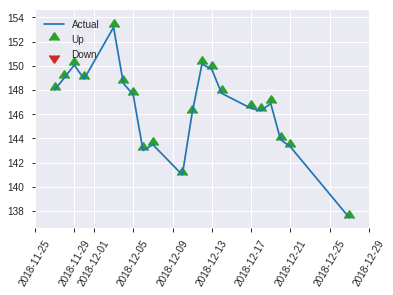


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2689855259729312
RMSE: 0.5186381455050633
LogLoss: 0.7543649716037675
Mean Per-Class Error: 0.4336912925346099
AUC: 0.5390736188381421
pr_auc: 0.5026023433064586
Gini: 0.07814723767628418
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.01386677578751078: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0138668    0.643052  248
max f2                       0.0138668    0.818308  248
max f0point5                 0.390636     0.551771  153
max accuracy                 0.559253     0.562249  56
max precision                0.775601     0.625     7
max recall                   0.0138668    1         248
max specificity              0.911301     0.992366  0
max absolute_mcc             0.159031     0.150829  243
max min_per_class_accuracy   0.432288     0.525424  123
max mean_per_class_accuracy  0.403575     0.566309  142

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 44.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.883276           0         0                  0                0.897002  0                           0.897002            0               0                          -100      -100
    2        0.0200803                   0.804942           2.11017   0.844068           1                0.854528  0.4                         0.880012            0.0169492       0.0169492                  111.017   -15.5932
    3        0.0321285                   0.772787           2.11017   1.31886            1                0.78927   0.625                       0.845984            0.0254237       0.0423729                  111.017   31.8856
    4        0.0401606                   0.740955           1.05508   1.2661             0.5              0.763759  0.6                         0.829539            0.00847458      0.0508475                  5.50847   26.6102
    5        0.0522088                   0.712972           0.70339   1.13625            0.333333         0.726328  0.538462                    0.805721            0.00847458      0.059322                   -29.661   13.6245
    6        0.100402                    0.651567           0.879237  1.01288            0.416667         0.683671  0.48                        0.747137            0.0423729       0.101695                   -12.0763  1.28814
    7        0.15261                     0.599541           1.46089   1.16615            0.692308         0.626834  0.552632                    0.705981            0.0762712       0.177966                   46.0887   16.6146
    8        0.200803                    0.570362           1.05508   1.13949            0.5              0.58132   0.54                        0.676062            0.0508475       0.228814                   5.50847   13.9492
    9        0.301205                    0.536823           0.759661  1.01288            0.36             0.550822  0.48                        0.634316            0.0762712       0.305085                   -24.0339  1.28814
    10       0.401606                    0.471748           1.09729   1.03398            0.52             0.501593  0.49                        0.601135            0.110169        0.415254                   9.72881   3.39831
    11       0.502008                    0.431886           1.09729   1.04664            0.52             0.449466  0.496                       0.570801            0.110169        0.525424                   9.72881   4.66441
    12       0.598394                    0.395284           1.31886   1.09049            0.625            0.414554  0.516779                    0.545634            0.127119        0.652542                   31.8856   9.04903
    13       0.698795                    0.357434           0.759661  1.04296            0.36             0.377777  0.494253                    0.521517            0.0762712       0.728814                   -24.0339  4.29573
    14       0.799197                    0.312571           0.928475  1.02858            0.44             0.33832   0.487437                    0.498502            0.0932203       0.822034                   -7.15254  2.85751
    15       0.899598                    0.240515           0.759661  0.998562           0.36             0.278825  0.473214                    0.473984            0.0762712       0.898305                   -24.0339  -0.143765
    16       1                           0.0138668          1.01288   1                  0.48             0.177155  0.473896                    0.444182         

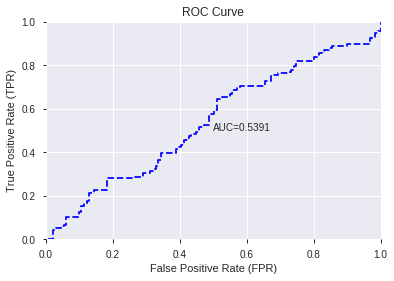

This function is available for GLM models only


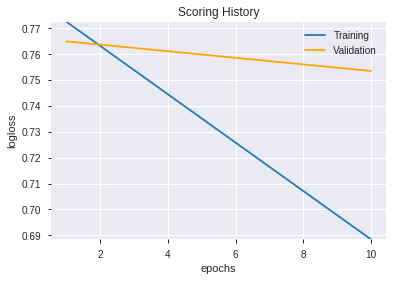

--2019-08-28 18:47:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.240
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_184047',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_184047',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_84e8'

['CORREL_12',
 'aroondown_14',
 'HT_DCPERIOD',
 'CDLMORNINGSTAR',
 'CDLUNIQUE3RIVER',
 'CDLPIERCING',
 'CORREL_24',
 'SIN',
 'BOP',
 'EXP',
 'COS',
 'CORREL_30',
 'week',
 'weekday',
 'CORREL_14',
 'CORREL_20',
 'ADX_8',
 'STOCHRSI_fastd',
 'HT_TRENDMODE',
 'dayofyear',
 'aroondown_8',
 'dayofweek',
 'days_in_month',
 'aroonup_14',
 'CDLGAPSIDESIDEWHITE',
 'DX_12',
 'SAREXT',
 'day',
 'weekofyear',
 'CDLEVENINGDOJISTAR',
 'month',
 'quarter',
 'weekday_name',
 'aroonup_8',
 'CDLMORNINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLINNECK',
 'CDLHAMMER',
 'BETA_8',
 'CORREL_8',
 'BETA_14',
 'ADXR_8',
 'aroonup_20',
 'CDLTAKURI',
 'CDLSPINNINGTOP',
 'aroondown_20',
 'STOCHRSI_fastk',
 'BETA_12',
 'CDLLONGLEGGEDDOJI',
 'CDL2CROWS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_184834_model_1  0.506534  0.69615                   0.5  0.501488  0.25149

variable  relative_importance  scaled_importance  percentage
0            aroonup_20             0.037674           1.000000    0.059991
1             CORREL_24             0.030018           0.796784    0.047800
2        STOCHRSI_fastk             0.028447           0.755089    0.045299
3       CDLUNIQUE3RIVER             0.027736           0.736215    0.044166
4           aroondown_8             0.027549           0.731238    0.043868
5             CORREL_20             0.026356           0.699587    0.041969
6                   BOP             0.026186           0.695078    0.041699
7             aroonup_8             0.022721           0.603100    0.036181
8          aroondown_14             0.022049           0.585245    0.035110
9        CDLSPINNINGTOP             0.020119           0.534020    0.032037
10                  EXP             0.020108           0.533725    0.032019
11                ADX_8             0.019669           0.522092    0.031321
12          HT_DCPERIOD             0.017590           0.466912    0.028011
13            CDLINNECK             0.017457           0.463369    0.027798
14               SAREXT             0.016868           0.447736    0.026860
15            CDL2CROWS             0.016685           0.442865    0.026568
16            CORREL_30             0.015421           0.409331    0.024556
17            CORREL_12             0.015178           0.402887    0.024170
18                DX_12             0.014672           0.389456    0.023364
19           aroonup_14             0.012995           0.344941    0.020693
20  CDLGAPSIDESIDEWHITE             0.012483           0.331348    0.019878
21   CDLEVENINGDOJISTAR             0.011140           0.295688    0.017739
22     CDLDRAGONFLYDOJI             0.010590           0.281101    0.016864
23                 week             0.010259           0.272307    0.016336
24           weekofyear             0.010253           0.272141    0.016326
25               ADXR_8             0.010104           0.268196    0.016089
26                  COS             0.009553           0.253573    0.015212
27             CORREL_8             0.009025           0.239566    0.014372
28       CDLMORNINGSTAR             0.009007           0.239084    0.014343
29    CDLLONGLEGGEDDOJI             0.008281           0.219807    0.013186
30              quarter             0.008015           0.212749    0.012763
31              BETA_14             0.007304           0.193883    0.011631
32         HT_TRENDMODE             0.007260           0.192705    0.011561
33                  SIN             0.006655           0.176634    0.010596
34            dayofweek             0.006184           0.164144    0.009847
35              weekday             0.006180           0.164039    0.009841
36            CDLTAKURI             0.005918           0.157090    0.009424
37            CORREL_14             0.005200           0.138022    0.008280
38            dayofyear             0.005144           0.136540    0.008191
39                  day             0.004827           0.128125    0.007686
40                month             0.004610           0.122357    0.007340
41        days_in_month             0.004109           0.109080    0.006544
42              BETA_12             0.003927           0.104224    0.006253
43         weekday_name             0.003552           0.094280    0.005656
44   CDLMORNINGDOJISTAR             0.003463           0.091921    0.005514
45               BETA_8             0.002218           0.058884    0.003533
46          CDLPIERCING             0.002189           0.058090    0.003485
47         aroondown_20             0.001964           0.052139    0.003128
48            CDLHAMMER             0.001677           0.044510    0.002670
49       STOCHRSI_fastd             0.001401           0.037196    0.002231

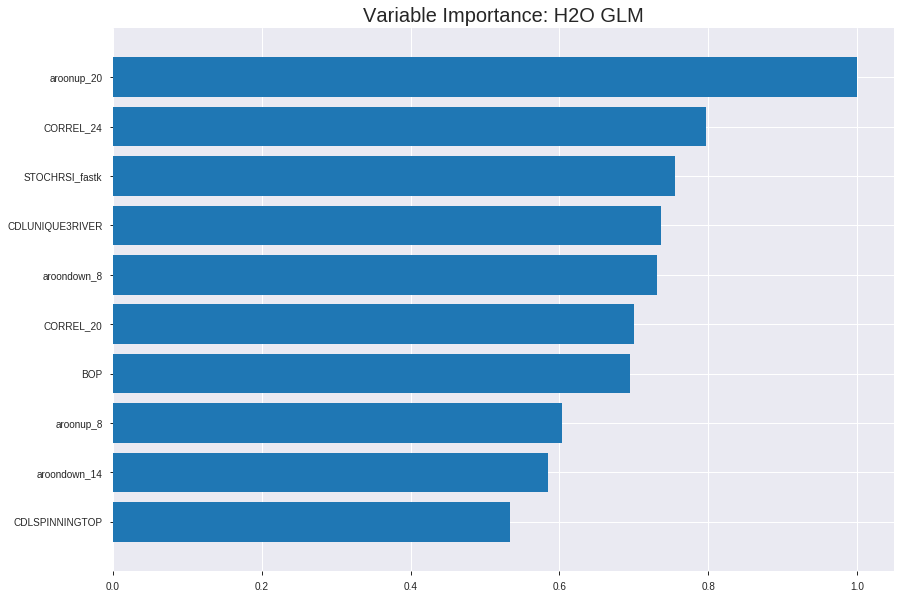

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_184834_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24541670855699704
RMSE: 0.4953955072030802
LogLoss: 0.6839269238690096
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2410.1318575316827
Residual deviance: 2381.433548911891
AIC: 2483.433548911891
AUC: 0.5863507023779301
pr_auc: 0.5880123014591018
Gini: 0.17270140475586016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4740336545764331: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      87   745   0.8954   (745.0/832.0)
1      40   869   0.044    (40.0/909.0)
Total  127  1614  0.4509   (785.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474034     0.688862  339
max f2                       0.402478     0.846054  394
max f0point5                 0.501918     0.6       265
max accuracy                 0.501918     0.573234  265
max precision                0.667266     1         0
max recall                   0.402478     1         394
max specificity              0.667266     1         0
max absolute_mcc             0.492879     0.146186  292
max min_per_class_accuracy   0.523679     0.557692  194
max mean_per_class_accuracy  0.519282     0.562788  208

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.587101           1.17046   1.17046            0.611111         0.603946  0.611111                    0.603946            0.0121012       0.0121012                  17.0456   17.0456
    2        0.0201034                   0.581615           1.12664   1.14917            0.588235         0.583492  0.6                         0.594011            0.0110011       0.0231023                  12.6642   14.9175
    3        0.0304423                   0.577519           1.06405   1.12026            0.555556         0.579624  0.584906                    0.589125            0.0110011       0.0341034                  6.40508   12.0265
    4        0.0402068                   0.574509           1.12664   1.12181            0.588235         0.575851  0.585714                    0.585901            0.0110011       0.0451045                  12.6642   12.1814
    5        0.0505457                   0.572371           1.38327   1.17529            0.722222         0.573369  0.613636                    0.583338            0.0143014       0.0594059                  38.3266   17.5293
    6        0.100517                    0.563078           1.32089   1.24768            0.689655         0.567118  0.651429                    0.575274            0.0660066       0.125413                   32.0891   24.7676
    7        0.150488                    0.555702           1.01268   1.16964            0.528736         0.559395  0.610687                    0.570002            0.0506051       0.176018                   1.26829   16.9644
    8        0.20046                     0.550388           1.23283   1.1854             0.643678         0.552824  0.618911                    0.565719            0.0616062       0.237624                   23.2831   18.5395
    9        0.300402                    0.539779           1.07873   1.14991            0.563218         0.544903  0.600382                    0.558794            0.107811        0.345435                   7.87274   14.9907
    10       0.400345                    0.531295           1.07873   1.13214            0.563218         0.535656  0.591105                    0.553018            0.107811        0.453245                   7.87274   13.2138
    11       0.500287                    0.524028           1.01268   1.10827            0.528736         0.527489  0.578645                    0.547918            0.10121         0.554455                   1.26829   10.8274
    12       0.60023                     0.515917           0.979661  1.08686            0.511494         0.519749  0.567464                    0.543227            0.0979098       0.652365                   -2.03394  8.68592
    13       0.700172                    0.506158           1.04571   1.08098            0.545977         0.510711  0.564397                    0.538586            0.10451         0.756876                   4.57051   8.09849
    14       0.800115                    0.495976           0.946638  1.0642             0.494253         0.501423  0.555635                    0.533944            0.0946095       0.851485                   -5.33617  6.42036
    15       0.900057                    0.479876           0.803542  1.03526            0.41954          0.488598  0.540523                    0.528909            0.080308        0.931793                   -19.6458  3.52597
    16       1                           0.337631           0.68246   1                  0.356322         0.46092   0.522114                    0.522114         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25007647692947105
RMSE: 0.5000764710816448
LogLoss: 0.6933198429863507
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 691.349667579769
Residual deviance: 690.5465636144054
AIC: 792.5465636144054
AUC: 0.5204432186577637
pr_auc: 0.5137296078267073
Gini: 0.040886437315527324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.442450146907695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    245  0.9839   (245.0/249.0)
1      1    248  0.004    (1.0/249.0)
Total  5    493  0.494    (246.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44245      0.668464  394
max f2                       0.426367     0.833333  399
max f0point5                 0.491823     0.572399  325
max accuracy                 0.492107     0.544177  323
max precision                0.692758     1         0
max recall                   0.426367     1         399
max specificity              0.692758     1         0
max absolute_mcc             0.491823     0.119116  325
max min_per_class_accuracy   0.522839     0.522088  192
max mean_per_class_accuracy  0.492107     0.544177  323

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.15 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100402                   0.581585           1.2      1.2                0.6              0.624282  0.6                         0.624282            0.0120482       0.0120482                  20       20
    2        0.0200803                   0.579354           1.2      1.2                0.6              0.580894  0.6                         0.602588            0.0120482       0.0240964                  20       20
    3        0.0301205                   0.578216           0.8      1.06667            0.4              0.578894  0.533333                    0.59469             0.00803213      0.0321285                  -20      6.66667
    4        0.0401606                   0.575229           1.2      1.1                0.6              0.577475  0.55                        0.590386            0.0120482       0.0441767                  20       10
    5        0.0502008                   0.569584           0.8      1.04               0.4              0.572585  0.52                        0.586826            0.00803213      0.0522088                  -20      4
    6        0.100402                    0.558301           1.2      1.12               0.6              0.563793  0.56                        0.57531             0.060241        0.11245                    20       12
    7        0.150602                    0.551687           0.88     1.04               0.44             0.554489  0.52                        0.568369            0.0441767       0.156627                   -12      4
    8        0.200803                    0.546556           0.88     1                  0.44             0.549124  0.5                         0.563558            0.0441767       0.200803                   -12      0
    9        0.301205                    0.535689           1.08     1.02667            0.54             0.54062   0.513333                    0.555912            0.108434        0.309237                   8        2.66667
    10       0.399598                    0.529174           1.06122  1.03518            0.530612         0.532636  0.517588                    0.550181            0.104418        0.413655                   6.12245  3.51759
    11       0.5                         0.522727           1.08     1.04418            0.54             0.525533  0.522088                    0.545231            0.108434        0.522088                   8        4.41767
    12       0.600402                    0.515262           0.72     0.989967           0.36             0.519028  0.494983                    0.54085             0.0722892       0.594378                   -28      -1.00334
    13       0.698795                    0.508422           1.06122  1                  0.530612         0.511313  0.5                         0.536691            0.104418        0.698795                   6.12245  0
    14       0.799197                    0.497694           1.28     1.03518            0.64             0.503879  0.517588                    0.532569            0.128514        0.827309                   28       3.51759
    15       0.899598                    0.483704           0.92     1.02232            0.46             0.490335  0.511161                    0.527855            0.0923695       0.919679                   -8       2.23214
    16       1                           0.426367           0.8      1                  0.4              0.464567  0.5                         0.521501            0.0803213       1                          -20      0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 18:48:35  0.000 sec   2            3.5       51            1.3794            1.38732
    2019-08-28 18:48:35  0.043 sec   4            2.1       51            1.37732           1.38706
    2019-08-28 18:48:35  0.097 sec   6            1.3       51            1.3747            1.38681
    2019-08-28 18:48:35  0.146 sec   8            0.83      51            1.37152           1.38665
    2019-08-28 18:48:35  0.194 sec   10           0.51      51            1.36785           1.38664
    2019-08-28 18:48:35  0.256 sec   12           0.32      51            1.36385           1.38688
    2019-08-28 18:48:35  0.319 sec   14           0.2       51            1.35975           1.38752
    2019-08-28 18:48:35  0.366 sec   16           0.12      51            1.35585           1.38868
    2019-08-28 18:48:35  0.383 sec   18           0.076     51            1.35238           1.39044
    2019-08-28 18:48:35  0.400 sec   20           0.047     51            1.34945           1.39284

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.6430517711171662)

('auc', 0.5065338336136628)

('logloss', 0.6961503543256198)

('mean_per_class_error', 0.4699508345193427)

('rmse', 0.5014879224182177)

('mse', 0.2514901363313403)

glm prediction progress: |████████████████████████████████████████████████| 100%


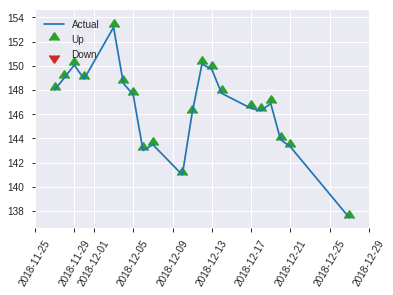


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2514901363313403
RMSE: 0.5014879224182177
LogLoss: 0.6961503543256198
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 346.8254982835162
Residual deviance: 346.68287645415865
AIC: 448.68287645415865
AUC: 0.5065338336136628
pr_auc: 0.4916010203690361
Gini: 0.013067667227325552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4065740738864588: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406574     0.643052  248
max f2                       0.406574     0.818308  248
max f0point5                 0.472408     0.531915  228
max accuracy                 0.544066     0.550201  25
max precision                0.571996     1         0
max recall                   0.406574     1         248
max specificity              0.571996     1         0
max absolute_mcc             0.445599     0.146358  240
max min_per_class_accuracy   0.515032     0.466102  115
max mean_per_class_accuracy  0.543398     0.530049  27

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 51.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.569499           1.40678   1.40678            0.666667         0.571204  0.666667                    0.571204            0.0169492       0.0169492                  40.678    40.678
    2        0.0200803                   0.565252           1.05508   1.2661             0.5              0.568667  0.6                         0.570189            0.00847458      0.0254237                  5.50847   26.6102
    3        0.0321285                   0.557443           1.40678   1.31886            0.666667         0.560865  0.625                       0.566693            0.0169492       0.0423729                  40.678    31.8856
    4        0.0401606                   0.555003           1.05508   1.2661             0.5              0.555581  0.6                         0.56447             0.00847458      0.0508475                  5.50847   26.6102
    5        0.0522088                   0.554125           0.70339   1.13625            0.333333         0.554564  0.538462                    0.562184            0.00847458      0.059322                   -29.661   13.6245
    6        0.100402                    0.544144           1.40678   1.2661             0.666667         0.547514  0.6                         0.555143            0.0677966       0.127119                   40.678    26.6102
    7        0.15261                     0.539502           0.811604  1.11062            0.384615         0.542074  0.526316                    0.550672            0.0423729       0.169492                   -18.8396  11.0616
    8        0.200803                    0.532482           0.879237  1.05508            0.416667         0.536048  0.5                         0.547162            0.0423729       0.211864                   -12.0763  5.50847
    9        0.301205                    0.526108           1.01288   1.04102            0.48             0.528717  0.493333                    0.541014            0.101695        0.313559                   1.28814   4.10169
    10       0.401606                    0.520164           0.675254  0.949576           0.32             0.522637  0.45                        0.53642             0.0677966       0.381356                   -32.4746  -5.04237
    11       0.502008                    0.51279            0.844068  0.928475           0.4              0.515647  0.44                        0.532265            0.0847458       0.466102                   -15.5932  -7.15254
    12       0.598394                    0.507262           1.40678   1.00552            0.666667         0.509683  0.47651                     0.528628            0.135593        0.601695                   40.678    0.551701
    13       0.698795                    0.499085           1.01288   1.00658            0.48             0.50283   0.477011                    0.524921            0.101695        0.70339                    1.28814   0.65751
    14       0.799197                    0.492131           1.09729   1.01797            0.52             0.495812  0.482412                    0.521264            0.110169        0.813559                   9.72881   1.79712
    15       0.899598                    0.47603            0.928475  1.00798            0.44             0.485467  0.477679                    0.517269            0.0932203       0.90678                    -7.15254  0.798275
    16       1                           0.406574           0.928475  1                  0.44             0.451126  0.473896                    0.510628      

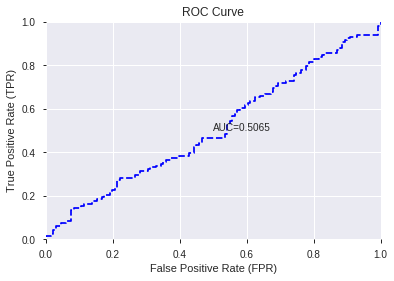

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


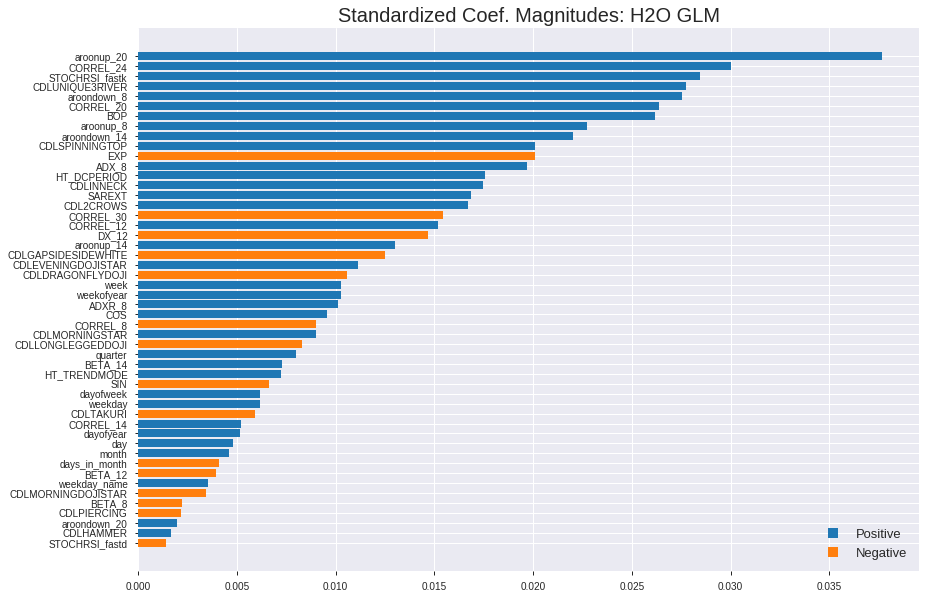

'log_likelihood'
--2019-08-28 18:48:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_184834_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_184834_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['aroonup_20',
 'CORREL_24',
 'STOCHRSI_fastk',
 'CDLUNIQUE3RIVER',
 'aroondown_8',
 'CORREL_20',
 'BOP',
 'aroonup_8',
 'aroondown_14',
 'CDLSPINNINGTOP',
 'EXP',
 'ADX_8',
 'HT_DCPERIOD',
 'CDLINNECK',
 'SAREXT',
 'CDL2CROWS',
 'CORREL_30',
 'CORREL_12',
 'DX_12',
 'aroonup_14',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'week',
 'weekofyear',
 'ADXR_8',
 'COS',
 'CORREL_8',
 'CDLMORNINGSTAR',
 'CDLLONGLEGGEDDOJI',
 'quarter',
 'BETA_14',
 'HT_TRENDMODE',
 'SIN',
 'dayofweek',
 'weekday',
 'CDLTAKURI',
 'CORREL_14',
 'dayofyear',
 'day',
 'month',
 'days_in_month',
 'BETA_12',
 'weekday_name',
 'CDLMORNINGDOJISTAR',
 'BETA_8',
 'CDLPIERCING',
 'aroondown_20',
 'CDLHAMMER',
 'STOCHRSI_fastd']

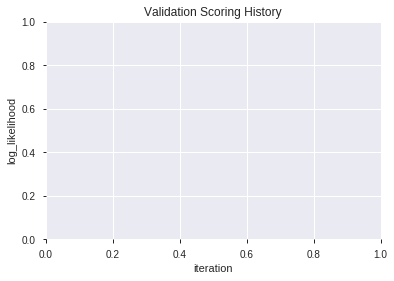

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_184941_model_3  0.554470  0.687356              0.460118  0.497193  0.247200
1  XGBoost_grid_1_AutoML_20190828_184941_model_6  0.553629  0.694542              0.500000  0.500508  0.250508
2  XGBoost_grid_1_AutoML_20190828_184941_model_4  0.544572  0.693500              0.500000  0.500088  0.250088
3  XGBoost_grid_1_AutoML_20190828_184941_model_5  0.542826  0.711676              0.500000  0.508131  0.258198
4               XGBoost_3_AutoML_20190828_184941  0.542114  0.694073              0.482178  0.500313  0.250313
5               XGBoost_1_AutoML_20190828_184941  0.536098  0.700798              0.500000  0.503470  0.253483
6  XGBoost_grid_1_AutoML_20190828_184941_model_2  0.519019  0.698419              0.500000  0.502506  0.252512
7  XGBoost_grid_1_AutoML_20190828_184941_model_1  0.517402  0.702513              0.500000  0.504414  0.254433
8               XGBoost_2_AutoML_20190828_184941  0.517014  0.705774              0.500000  0.506015  0.256052
9  XGBoost_grid_1_AutoML_20190828_184941_model_7  0.485380  0.718968              0.492366  0.512188  0.262336

variable  relative_importance  scaled_importance  percentage
0             BETA_14           273.384644           1.000000    0.054157
1             BETA_12           269.545502           0.985957    0.053397
2               ADX_8           261.677399           0.957177    0.051838
3      STOCHRSI_fastd           258.061707           0.943951    0.051122
4           CORREL_30           250.001953           0.914470    0.049525
5                 BOP           249.010208           0.910842    0.049329
6                 SIN           222.870132           0.815225    0.044150
7              ADXR_8           222.736923           0.814738    0.044124
8              SAREXT           211.391998           0.773240    0.041877
9                 COS           195.049927           0.713463    0.038639
10          CORREL_24           193.754227           0.708724    0.038383
11          CORREL_14           181.511093           0.663940    0.035957
12        HT_DCPERIOD           162.197433           0.593294    0.032131
13          dayofyear           159.517014           0.583489    0.031600
14                day           159.165787           0.582205    0.031531
15              DX_12           157.901794           0.577581    0.031280
16         aroonup_20           142.978821           0.522995    0.028324
17          CORREL_20           142.347885           0.520687    0.028199
18       aroondown_14           137.957016           0.504626    0.027329
19                EXP           134.329071           0.491356    0.026611
20          CORREL_12           115.210785           0.421424    0.022823
21       aroondown_20           109.682701           0.401203    0.021728
22             BETA_8           106.849533           0.390840    0.021167
23               week           103.134544           0.377251    0.020431
24          dayofweek            97.603264           0.357018    0.019335
25           CORREL_8            92.287468           0.337574    0.018282
26        aroondown_8            82.542389           0.301928    0.016352
27         aroonup_14            72.355957           0.264667    0.014334
28     STOCHRSI_fastk            67.394600           0.246519    0.013351
29          aroonup_8            52.429169           0.191778    0.010386
30       weekday_name            43.651516           0.159671    0.008647
31            weekday            30.131966           0.110218    0.005969
32              month            26.419569           0.096639    0.005234
33         weekofyear            23.495510           0.085943    0.004654
34      days_in_month            15.166254           0.055476    0.003004
35       HT_TRENDMODE            13.911475           0.050886    0.002756
36  CDLLONGLEGGEDDOJI             5.211386           0.019062    0.001032
37     CDLSPINNINGTOP             5.096760           0.018643    0.001010

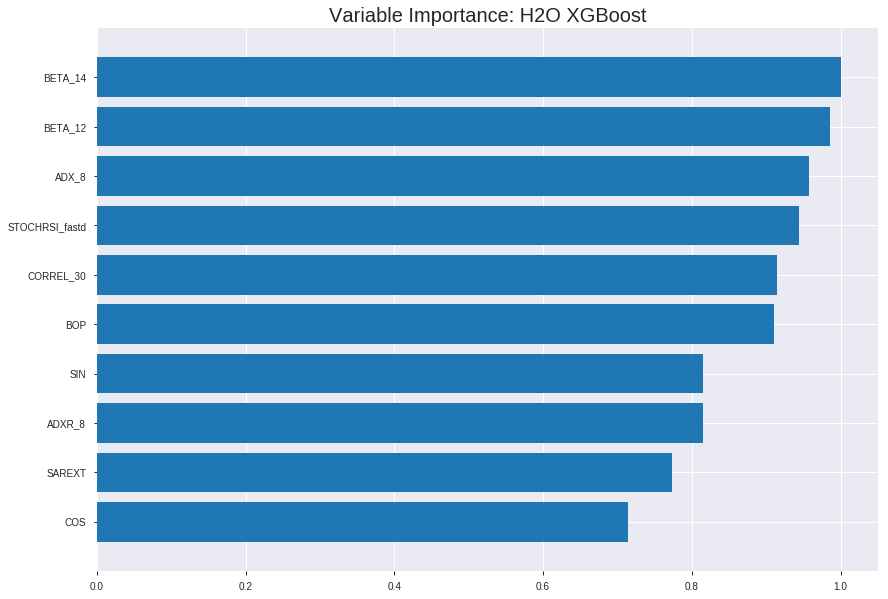

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_184941_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18495368102264734
RMSE: 0.43006241526393274
LogLoss: 0.5591127735884459
Mean Per-Class Error: 0.161285118896505
AUC: 0.9120308665481933
pr_auc: 0.9183534455918686
Gini: 0.8240617330963866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5139942169189453: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      679  153  0.1839   (153.0/832.0)
1      129  780  0.1419   (129.0/909.0)
Total  808  933  0.162    (282.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513994     0.846906  207
max f2                       0.44681      0.896236  272
max f0point5                 0.556179     0.85816   164
max accuracy                 0.516754     0.839173  204
max precision                0.787793     1         0
max recall                   0.311249     1         373
max specificity              0.787793     1         0
max absolute_mcc             0.516754     0.677613  204
max min_per_class_accuracy   0.521297     0.83774   199
max mean_per_class_accuracy  0.522108     0.838715  198

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.734762           1.91529    1.91529            1                0.754739  1                           0.754739            0.019802        0.019802                   91.5292   91.5292
    2        0.0201034                   0.717802           1.91529    1.91529            1                0.725425  1                           0.740501            0.0187019       0.0385039                  91.5292   91.5292
    3        0.0304423                   0.706239           1.91529    1.91529            1                0.712001  1                           0.730822            0.019802        0.0583058                  91.5292   91.5292
    4        0.0402068                   0.695924           1.91529    1.91529            1                0.702069  1                           0.723839            0.0187019       0.0770077                  91.5292   91.5292
    5        0.0505457                   0.688255           1.91529    1.91529            1                0.692591  1                           0.717447            0.019802        0.0968097                  91.5292   91.5292
    6        0.100517                    0.662627           1.89328    1.90435            0.988506         0.674191  0.994286                    0.695943            0.0946095       0.191419                   89.3277   90.4347
    7        0.150488                    0.640419           1.82723    1.87874            0.954023         0.650982  0.980916                    0.681013            0.0913091       0.282728                   82.7232   87.874
    8        0.20046                     0.623872           1.7832     1.85492            0.931034         0.632025  0.968481                    0.668801            0.0891089       0.371837                   78.3202   85.4924
    9        0.300402                    0.591012           1.70615    1.80543            0.890805         0.607293  0.942639                    0.648338            0.170517        0.542354                   70.6151   80.5428
    10       0.400345                    0.560385           1.51902    1.73393            0.793103         0.576059  0.905308                    0.630294            0.151815        0.694169                   51.9024   73.393
    11       0.500287                    0.525467           1.26585    1.64042            0.66092          0.543118  0.856487                    0.612879            0.126513        0.820682                   26.5854   64.0422
    12       0.60023                     0.490822           0.781527   1.49741            0.408046         0.508357  0.781818                    0.595475            0.0781078       0.89879                    -21.8473  49.741
    13       0.700172                    0.459752           0.539364   1.36066            0.281609         0.474638  0.710418                    0.578227            0.0539054       0.952695                   -46.0636  36.0658
    14       0.800115                    0.422495           0.2972     1.22782            0.155172         0.440332  0.641062                    0.561002            0.029703        0.982398                   -70.28    22.7821
    15       0.900057                    0.372241           0.143096   1.10737            0.0747126        0.399079  0.578175                    0.543022            0.0143014       0.9967                     -85.6904  10.7373
    16       1                           0.222377           0.0330223  1                  0.0172414        0.324301  0.522114                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25215629756519636
RMSE: 0.5021516678904854
LogLoss: 0.6977929709909391
Mean Per-Class Error: 0.46787148594377514
AUC: 0.5316930372090773
pr_auc: 0.5282674653903089
Gini: 0.06338607441815469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3187336027622223: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    249  1        (249.0/249.0)
1      0    249  0        (0.0/249.0)
Total  0    498  0.5      (249.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.318734     0.666667   399
max f2                       0.318734     0.833333   399
max f0point5                 0.462835     0.560224   305
max accuracy                 0.509783     0.532129   222
max precision                0.677528     0.666667   5
max recall                   0.318734     1          399
max specificity              0.761799     0.995984   0
max absolute_mcc             0.624517     0.0910517  42
max min_per_class_accuracy   0.519727     0.522088   203
max mean_per_class_accuracy  0.509783     0.532129   222

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.677672           1.2       1.2                0.6              0.702653  0.6                         0.702653            0.0120482       0.0120482                  20        20
    2        0.0200803                   0.658442           0.8       1                  0.4              0.667064  0.5                         0.684858            0.00803213      0.0200803                  -20       0
    3        0.0301205                   0.652627           1.2       1.06667            0.6              0.656582  0.533333                    0.675433            0.0120482       0.0321285                  20        6.66667
    4        0.0401606                   0.648392           0.8       1                  0.4              0.650453  0.5                         0.669188            0.00803213      0.0401606                  -20       0
    5        0.0502008                   0.640918           1.6       1.12               0.8              0.64473   0.56                        0.664296            0.0160643       0.0562249                  60        12
    6        0.100402                    0.621722           1.28      1.2                0.64             0.630133  0.6                         0.647215            0.064257        0.120482                   28        20
    7        0.150602                    0.598287           0.96      1.12               0.48             0.6104    0.56                        0.634943            0.0481928       0.168675                   -4        12
    8        0.200803                    0.583325           1.12      1.12               0.56             0.589375  0.56                        0.623551            0.0562249       0.2249                     12        12
    9        0.301205                    0.562897           0.76      1                  0.38             0.571948  0.5                         0.60635             0.0763052       0.301205                   -24       0
    10       0.399598                    0.537941           1.18367   1.04523            0.591837         0.549873  0.522613                    0.592443            0.116466        0.417671                   18.3673   4.52261
    11       0.5                         0.517942           1.04      1.04418            0.52             0.528286  0.522088                    0.57956             0.104418        0.522088                   4         4.41767
    12       0.600402                    0.499787           0.96      1.0301             0.48             0.508727  0.51505                     0.567715            0.0963855       0.618474                   -4        3.01003
    13       0.698795                    0.47717            0.938776  1.01724            0.469388         0.4897    0.508621                    0.55673             0.0923695       0.710843                   -6.12245  1.72414
    14       0.799197                    0.455367           1         1.01508            0.5              0.467281  0.507538                    0.545493            0.100402        0.811245                   0         1.50754
    15       0.899598                    0.418073           0.96      1.00893            0.48             0.436813  0.504464                    0.533364            0.0963855       0.907631                   -4        0.892857
    16       1                           0.318734           0.92      1                  0.46             0.380903  0.5                         0.518056            0.0923695       1                      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:49:48  1.988 sec   0                  0.5              0.693147            0.5             0                  1                0.477886                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-28 18:49:48  2.130 sec   5                  0.48992          0.673144            0.73359         0.743061           1.91529          0.35784                          0.501198           0.695545              0.471767          0.499495             1.6                0.495984
    2019-08-28 18:49:48  2.213 sec   10                 0.480569         0.654831            0.797188        0.802407           1.91529          0.29753                          0.502039           0.697241              0.479718          0.507707             2                  0.5
    2019-08-28 18:49:48  2.294 sec   15                 0.47366          0.641422            0.822024        0.826369           1.80889          0.256175                         0.501537           0.69623               0.494613          0.512879             1.6                0.493976
    2019-08-28 18:49:48  2.373 sec   20                 0.464858         0.624472            0.842345        0.848668           1.80889          0.237794                         0.502169           0.697518              0.503339          0.520176             1.2                0.497992
    2019-08-28 18:49:48  2.467 sec   25                 0.457275         0.609988            0.858395        0.868246           1.91529          0.224009                         0.502395           0.698043              0.510693          0.512093             0.8                0.495984
    2019-08-28 18:49:48  2.545 sec   30                 0.451214         0.598486            0.870457        0.880012           1.91529          0.211947                         0.501684           0.696628              0.520629          0.5184               0.4                0.495984
    2019-08-28 18:49:48  2.625 sec   35                 0.445352         0.587498            0.884956        0.894857           1.91529          0.194716                         0.50165            0.696633              0.528508          0.520551             0.8                0.497992
    2019-08-28 18:49:49  2.702 sec   40                 0.44157          0.580256            0.884936        0.893999           1.91529          0.198162                         0.502302           0.698104              0.529822          0.518665             0.4                0.493976
    2019-08-28 18:49:49  2.816 sec   45                 0.435343         0.568765            0.899729        0.906856           1.91529          0.177484                         0.502964           0.699454              0.521975          0.517433             1.2                0.497992
    2019-08-28 18:49:49  2.897 sec   50                 0.430062         0.559113            0.912031        0.918353           1.91529          0.161976                         0.502152           0.697793              0.531693          0.528267             1.2                0.5

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BETA_14            273.3846435546875      1.0                   0.05415739273472364
BETA_12            269.5455017089844      0.9859569952584585    0.05339686021176039
ADX_8              261.6773986816406      0.9571766551302104    0.05183819202839594
STOCHRSI_fastd     258.06170654296875     0.9439509958844723    0.051121924806448865
CORREL_30          250.001953125          0.9144696273877941    0.04952529075441716
---                ---                    ---                   ---
weekofyear         23.49551010131836      0.08594305004047657   0.0046544515138620965
days_in_month      15.166254043579102     0.05547588133107873   0.003004429092552154
HT_TRENDMODE       13.91147518157959      0.050886088555287694  0.0027558578826226417
CDLLONGLEGGEDDOJI  5.211385726928711      0.01906246692999138   0.0010323735080202247
CDLSPINNINGTOP     5.096760272979736      0.01864318422099004   0.0010096662496819604


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.653179190751445)

('auc', 0.5544701772544961)

('logloss', 0.6873561370255046)

('mean_per_class_error', 0.43695820934144136)

('rmse', 0.49719250680881544)

('mse', 0.24720038882683398)

xgboost prediction progress: |████████████████████████████████████████████| 100%


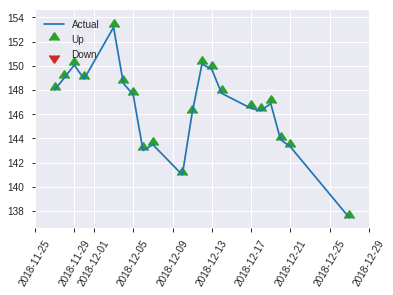


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24720038882683398
RMSE: 0.49719250680881544
LogLoss: 0.6873561370255046
Mean Per-Class Error: 0.43695820934144136
AUC: 0.5544701772544961
pr_auc: 0.5302128483756278
Gini: 0.1089403545089922
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38233840465545654: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   115  0.8779   (115.0/131.0)
1      5    113  0.0424   (5.0/118.0)
Total  21   228  0.4819   (120.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382338     0.653179  227
max f2                       0.296114     0.819444  247
max f0point5                 0.404461     0.550505  217
max accuracy                 0.5528       0.574297  69
max precision                0.727068     1         0
max recall                   0.296114     1         247
max specificity              0.727068     1         0
max absolute_mcc             0.5766       0.146211  36
max min_per_class_accuracy   0.49883      0.525424  123
max mean_per_class_accuracy  0.5528       0.563042  69

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.678719           1.40678   1.40678            0.666667         0.703644  0.666667                    0.703644            0.0169492       0.0169492                  40.678    40.678
    2        0.0200803                   0.653678           2.11017   1.68814            1                0.663006  0.8                         0.687389            0.0169492       0.0338983                  111.017   68.8136
    3        0.0321285                   0.638814           0.70339   1.31886            0.333333         0.645044  0.625                       0.67151             0.00847458      0.0423729                  -29.661   31.8856
    4        0.0401606                   0.634085           1.05508   1.2661             0.5              0.636657  0.6                         0.664539            0.00847458      0.0508475                  5.50847   26.6102
    5        0.0522088                   0.629067           1.40678   1.29857            0.666667         0.631826  0.615385                    0.65699             0.0169492       0.0677966                  40.678    29.8566
    6        0.100402                    0.596776           1.58263   1.43492            0.75             0.611981  0.68                        0.635386            0.0762712       0.144068                   58.2627   43.4915
    7        0.15261                     0.575996           1.13625   1.33274            0.538462         0.585046  0.631579                    0.618164            0.059322        0.20339                    13.6245   33.2739
    8        0.200803                    0.561807           1.05508   1.2661             0.5              0.569019  0.6                         0.606369            0.0508475       0.254237                   5.50847   26.6102
    9        0.301205                    0.54771            1.01288   1.18169            0.48             0.555377  0.56                        0.589372            0.101695        0.355932                   1.28814   18.1695
    10       0.401606                    0.517811           0.759661  1.07619            0.36             0.531666  0.51                        0.574946            0.0762712       0.432203                   -24.0339  7.61864
    11       0.502008                    0.498112           0.928475  1.04664            0.44             0.509634  0.496                       0.561883            0.0932203       0.525424                   -7.15254  4.66441
    12       0.598394                    0.480506           0.967161  1.03384            0.458333         0.490288  0.489933                    0.550351            0.0932203       0.618644                   -3.2839   3.38414
    13       0.698795                    0.459763           1.01288   1.03083            0.48             0.470757  0.488506                    0.538915            0.101695        0.720339                   1.28814   3.08299
    14       0.799197                    0.428737           1.09729   1.03918            0.52             0.447451  0.492462                    0.527425            0.110169        0.830508                   9.72881   3.91789
    15       0.899598                    0.39255            1.09729   1.04566            0.52             0.411906  0.495536                    0.514532            0.110169        0.940678                   9.72881   4.56643
    16       1                           0.24916            0.590847  1                  0.28             0.357458  0.473896                    0.498762          

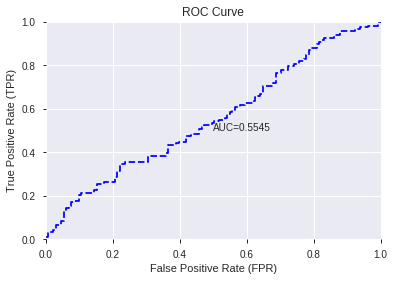

This function is available for GLM models only


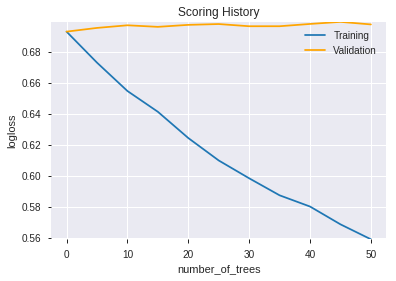

--2019-08-28 18:50:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_184941_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_184941_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BETA_14',
 'BETA_12',
 'ADX_8',
 'STOCHRSI_fastd',
 'CORREL_30',
 'BOP',
 'SIN',
 'ADXR_8',
 'SAREXT',
 'COS',
 'CORREL_24',
 'CORREL_14',
 'HT_DCPERIOD',
 'dayofyear',
 'day',
 'DX_12',
 'aroonup_20',
 'CORREL_20',
 'aroondown_14',
 'EXP',
 'CORREL_12',
 'aroondown_20',
 'BETA_8',
 'week',
 'dayofweek',
 'CORREL_8',
 'aroondown_8',
 'aroonup_14',
 'STOCHRSI_fastk',
 'aroonup_8',
 'weekday_name',
 'weekday',
 'month',
 'weekofyear',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI',
 'CDLSPINNINGTOP']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_185102_model_1  0.504722  0.693742                   0.5  0.500297  0.250297

variable  relative_importance  scaled_importance    percentage
0                    CORREL_24         7.824874e-03           1.000000  1.284358e-02
1                    CORREL_20         7.386193e-03           0.943938  1.212354e-02
2                   aroonup_20         7.154507e-03           0.914329  1.174326e-02
3               is_month_start         5.729064e-03           0.732161  9.403565e-03
4              CDLUNIQUE3RIVER         5.315109e-03           0.679258  8.724106e-03
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_24_2_3         9.840422e-07           0.000126  1.615186e-06
1034  BBANDS_middleband_30_7_5         9.759963e-07           0.000125  1.601980e-06
1035                    SUM_14         2.842229e-07           0.000036  4.665174e-07
1036                   MA_24_5         1.632889e-07           0.000021  2.680190e-07
1037                    WMA_24         0.000000e+00           0.000000  0.000000e+00

[1038 rows x 4 columns]

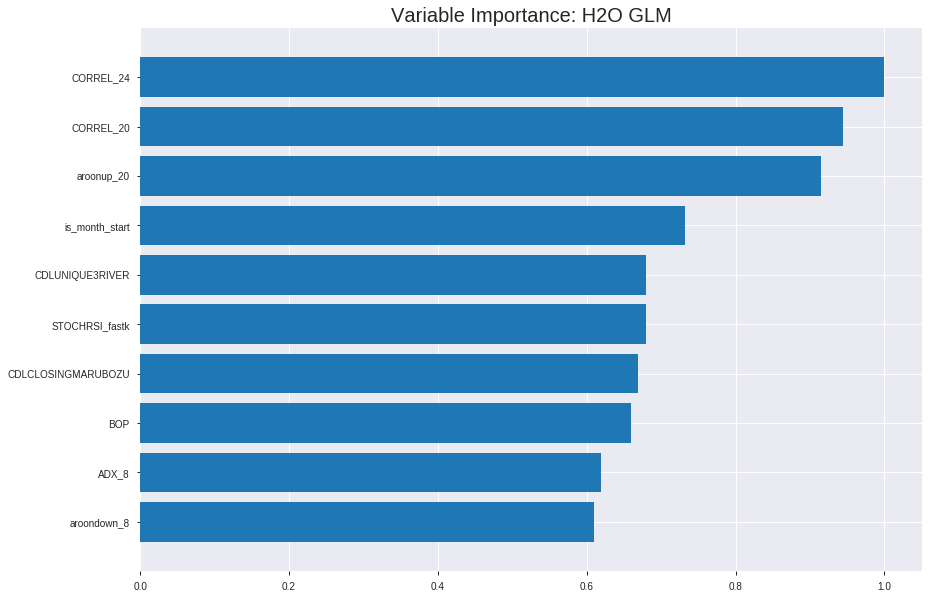

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_185102_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24598034942601113
RMSE: 0.4959640606193267
LogLoss: 0.6850674055033583
Null degrees of freedom: 1740
Residual degrees of freedom: 703
Null deviance: 2410.1318575316827
Residual deviance: 2385.4047059626932
AIC: 4461.404705962694
AUC: 0.5740405771346365
pr_auc: 0.5818446058850568
Gini: 0.14808115426927304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4231879756606848: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    824   0.9904   (824.0/832.0)
1      0    909   0        (0.0/909.0)
Total  8    1733  0.4733   (824.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423188     0.688115  391
max f2                       0.423188     0.846526  391
max f0point5                 0.503758     0.592275  245
max accuracy                 0.510676     0.566916  223
max precision                0.594734     0.857143  3
max recall                   0.423188     1         391
max specificity              0.597609     0.998798  0
max absolute_mcc             0.510676     0.126811  223
max min_per_class_accuracy   0.520185     0.550055  190
max mean_per_class_accuracy  0.510676     0.561282  223

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.590378           1.48967   1.48967            0.777778         0.594057  0.777778                    0.594057            0.0154015       0.0154015                  48.9671   48.9671
    2        0.0201034                   0.586961           1.23931   1.36807            0.647059         0.588117  0.714286                    0.591172            0.0121012       0.0275028                  23.9306   36.8065
    3        0.0304423                   0.583999           1.27686   1.33709            0.666667         0.585376  0.698113                    0.589204            0.0132013       0.0407041                  27.6861   33.709
    4        0.0402068                   0.582175           1.12664   1.28598            0.588235         0.582901  0.671429                    0.587673            0.0110011       0.0517052                  12.6642   28.5981
    5        0.0505457                   0.579849           1.06405   1.24059            0.555556         0.581075  0.647727                    0.586323            0.0110011       0.0627063                  6.40508   24.0587
    6        0.100517                    0.573364           1.12276   1.18201            0.586207         0.576342  0.617143                    0.581361            0.0561056       0.118812                   12.2757   18.2008
    7        0.150488                    0.568064           1.14477   1.16964            0.597701         0.570623  0.610687                    0.577796            0.0572057       0.176018                   14.4772   16.9644
    8        0.20046                     0.561229           1.05671   1.14149            0.551724         0.564688  0.595989                    0.574528            0.0528053       0.228823                   5.67126   14.1492
    9        0.300402                    0.538118           1.08973   1.12427            0.568966         0.549975  0.586998                    0.566359            0.108911        0.337734                   8.97348   12.4272
    10       0.400345                    0.527568           1.06772   1.11015            0.557471         0.532187  0.579627                    0.557829            0.106711        0.444444                   6.772     11.0155
    11       0.500287                    0.520059           1.06772   1.10168            0.557471         0.52397   0.575201                    0.551065            0.106711        0.551155                   6.772     10.1677
    12       0.60023                     0.512428           1.01268   1.08686            0.528736         0.516394  0.567464                    0.545292            0.10121         0.652365                   1.26829   8.68592
    13       0.700172                    0.504334           0.979661  1.07156            0.511494         0.508813  0.559475                    0.540085            0.0979098       0.750275                   -2.03394  7.15577
    14       0.800115                    0.493119           0.891601  1.04908            0.465517         0.498723  0.547739                    0.534918            0.0891089       0.839384                   -10.8399  4.90793
    15       0.900057                    0.478954           0.880594  1.03037            0.45977          0.486452  0.537971                    0.529537            0.0880088       0.927393                   -11.9406  3.03706
    16       1                           0.372757           0.72649   1                  0.37931          0.455266  0.522114                    0.522114          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2501524726746872
RMSE: 0.5001524494338573
LogLoss: 0.6934532082684123
Null degrees of freedom: 497
Residual degrees of freedom: -540
Null deviance: 691.349667579769
Residual deviance: 690.6793954353386
AIC: 2766.679395435339
AUC: 0.5305559587748584
pr_auc: 0.5237951024284941
Gini: 0.06111191754971679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49081555340443733: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    245  0.9839   (245.0/249.0)
1      0    249  0        (0.0/249.0)
Total  4    494  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.490816     0.670256   395
max f2                       0.490816     0.83557    395
max f0point5                 0.511801     0.567216   343
max accuracy                 0.521301     0.536145   267
max precision                0.573716     1          0
max recall                   0.490816     1          395
max specificity              0.573716     1          0
max absolute_mcc             0.511801     0.0986978  343
max min_per_class_accuracy   0.52914      0.518072   201
max mean_per_class_accuracy  0.521301     0.536145   267

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.94 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100402                   0.564935           1.6      1.6                0.8              0.569172  0.8                         0.569172            0.0160643       0.0160643                  60       60
    2        0.0200803                   0.562176           0.8      1.2                0.4              0.563662  0.6                         0.566417            0.00803213      0.0240964                  -20      20
    3        0.0301205                   0.559666           0.8      1.06667            0.4              0.560939  0.533333                    0.564591            0.00803213      0.0321285                  -20      6.66667
    4        0.0401606                   0.55824            1.2      1.1                0.6              0.559142  0.55                        0.563229            0.0120482       0.0441767                  20       10
    5        0.0502008                   0.556674           1.2      1.12               0.6              0.557469  0.56                        0.562077            0.0120482       0.0562249                  20       12
    6        0.100402                    0.550434           1.2      1.16               0.6              0.553514  0.58                        0.557795            0.060241        0.116466                   20       16
    7        0.150602                    0.546318           0.96     1.09333            0.48             0.548368  0.546667                    0.554653            0.0481928       0.164659                   -4       9.33333
    8        0.200803                    0.542554           0.88     1.04               0.44             0.544397  0.52                        0.552089            0.0441767       0.208835                   -12      4
    9        0.301205                    0.537772           1        1.02667            0.5              0.539869  0.513333                    0.548015            0.100402        0.309237                   0        2.66667
    10       0.399598                    0.533037           1.06122  1.03518            0.530612         0.535541  0.517588                    0.544944            0.104418        0.413655                   6.12245  3.51759
    11       0.5                         0.529105           1.04     1.03614            0.52             0.531373  0.518072                    0.542219            0.104418        0.518072                   4        3.61446
    12       0.600402                    0.525014           0.96     1.02341            0.48             0.526968  0.511706                    0.539668            0.0963855       0.614458                   -4       2.34114
    13       0.698795                    0.520794           1.06122  1.02874            0.530612         0.522735  0.514368                    0.537284            0.104418        0.718876                   6.12245  2.87356
    14       0.799197                    0.515382           1.08     1.03518            0.54             0.518099  0.517588                    0.534874            0.108434        0.827309                   8        3.51759
    15       0.899598                    0.510665           0.92     1.02232            0.46             0.513149  0.511161                    0.532449            0.0923695       0.919679                   -8       2.23214
    16       1                           0.485883           0.8      1                  0.4              0.501694  0.5                         0.529361            0.0803213       1                          -20      0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 18:51:05  0.000 sec   2            3.6       1038          1.37013           1.38691
    2019-08-28 18:51:07  2.090 sec   4            2.6       1038          1.36756           1.38717
    2019-08-28 18:51:09  4.190 sec   6            1.9       1039          1.36452           1.38762
    2019-08-28 18:51:11  6.423 sec   8            1.4       1039          1.36103           1.38827
    2019-08-28 18:51:14  8.488 sec   10           1         1039          1.35707           1.38921
    2019-08-28 18:51:16  10.529 sec  12           0.73      1039          1.35271           1.39052

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5421686746987951)

('F1', 0.6430517711171662)

('auc', 0.5047224737999741)

('logloss', 0.6937417494716601)

('mean_per_class_error', 0.4730236770604218)

('rmse', 0.5002970923382706)

('mse', 0.250297180602128)

glm prediction progress: |████████████████████████████████████████████████| 100%


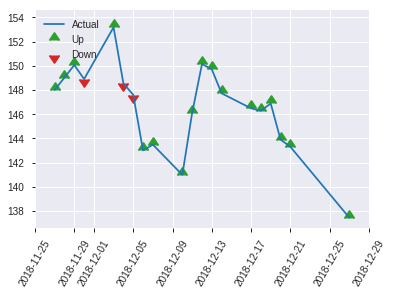


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.250297180602128
RMSE: 0.5002970923382706
LogLoss: 0.6937417494716601
Null degrees of freedom: 248
Residual degrees of freedom: -789
Null deviance: 346.8254982835162
Residual deviance: 345.48339123688675
AIC: 2421.4833912368867
AUC: 0.5047224737999741
pr_auc: 0.49128929093480206
Gini: 0.009444947599948295
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.462471535766668: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462472     0.643052  248
max f2                       0.462472     0.818308  248
max f0point5                 0.485839     0.533199  218
max accuracy                 0.532585     0.542169  5
max precision                0.543758     1         0
max recall                   0.462472     1         248
max specificity              0.543758     1         0
max absolute_mcc             0.539239     0.116356  2
max min_per_class_accuracy   0.503336     0.5       123
max mean_per_class_accuracy  0.508607     0.526976  89

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 50.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.537596           2.11017   2.11017            1                0.541114  1                           0.541114            0.0254237       0.0254237                  111.017   111.017
    2        0.0200803                   0.532639           1.05508   1.68814            0.5              0.534887  0.8                         0.538623            0.00847458      0.0338983                  5.50847   68.8136
    3        0.0321285                   0.529553           0.70339   1.31886            0.333333         0.530987  0.625                       0.535759            0.00847458      0.0423729                  -29.661   31.8856
    4        0.0401606                   0.529403           0         1.05508            0                0.529497  0.5                         0.534507            0               0.0423729                  -100      5.50847
    5        0.0522088                   0.52719            1.40678   1.13625            0.666667         0.528454  0.538462                    0.53311             0.0169492       0.059322                   40.678    13.6245
    6        0.100402                    0.523412           0.879237  1.01288            0.416667         0.525481  0.48                        0.529448            0.0423729       0.101695                   -12.0763  1.28814
    7        0.15261                     0.518291           0.973924  0.999554           0.461538         0.520534  0.473684                    0.526399            0.0508475       0.152542                   -2.60756  -0.044603
    8        0.200803                    0.51545            1.05508   1.01288            0.5              0.516903  0.48                        0.52412             0.0508475       0.20339                    5.50847   1.28814
    9        0.301205                    0.511013           0.928475  0.984746           0.44             0.513507  0.466667                    0.520582            0.0932203       0.29661                    -7.15254  -1.52542
    10       0.401606                    0.507208           1.18169   1.03398            0.56             0.50888   0.49                        0.517657            0.118644        0.415254                   18.1695   3.39831
    11       0.502008                    0.503258           0.844068  0.996              0.4              0.504982  0.472                       0.515122            0.0847458       0.5                        -15.5932  -0.4
    12       0.598394                    0.500035           0.791314  0.96303            0.375            0.50157   0.456376                    0.512939            0.0762712       0.576271                   -20.8686  -3.69696
    13       0.698795                    0.495963           1.2661    1.00658            0.6              0.497869  0.477011                    0.510774            0.127119        0.70339                    26.6102   0.65751
    14       0.799197                    0.491096           1.09729   1.01797            0.52             0.493731  0.482412                    0.508633            0.110169        0.813559                   9.72881   1.79712
    15       0.899598                    0.48482            0.844068  0.998562           0.4              0.487969  0.473214                    0.506326            0.0847458       0.898305                   -15.5932  -0.143765
    16       1                           0.462472           1.01288   1                  0.48             0.475609  0.473896                    0.503242      

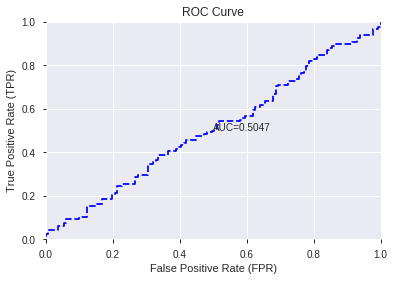

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


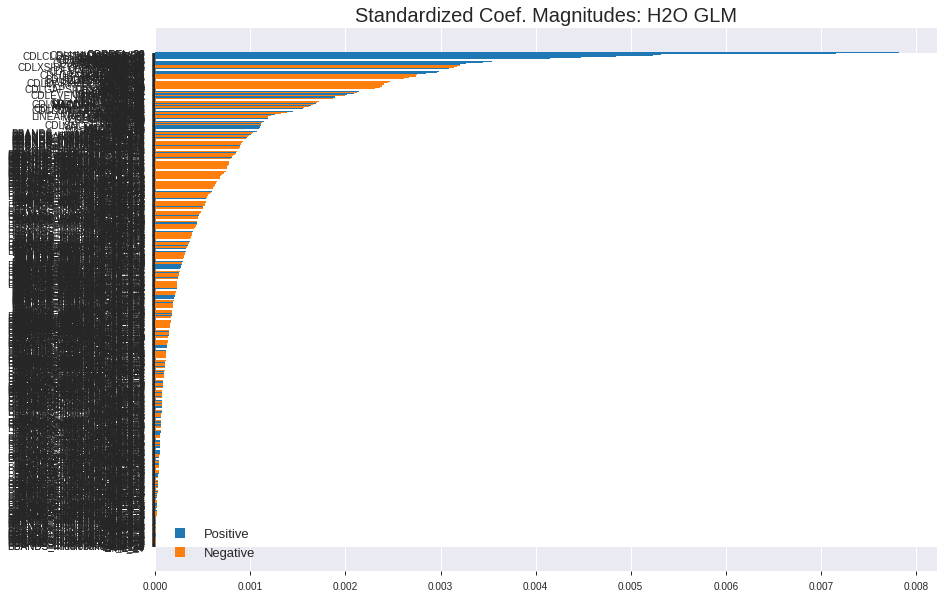

'log_likelihood'
--2019-08-28 18:51:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_185102_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_185102_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

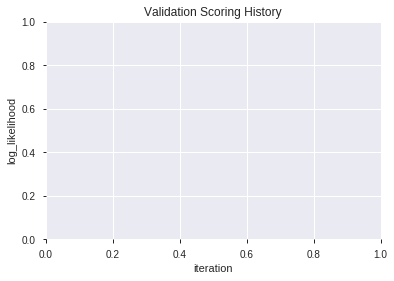

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_185241_model_5  0.525747  0.730023              0.500000  0.514618  0.264832
1               XGBoost_1_AutoML_20190828_185241  0.514038  0.704658              0.472409  0.505524  0.255555
2  XGBoost_grid_1_AutoML_20190828_185241_model_4  0.503170  0.701419              0.482598  0.504033  0.254049
3  XGBoost_grid_1_AutoML_20190828_185241_model_6  0.500582  0.705113              0.496183  0.505743  0.255776
4  XGBoost_grid_1_AutoML_20190828_185241_model_2  0.493660  0.705546              0.500000  0.505945  0.255980
5  XGBoost_grid_1_AutoML_20190828_185241_model_7  0.490684  0.725538              0.500000  0.514858  0.265079
6               XGBoost_3_AutoML_20190828_185241  0.486868  0.706132              0.496183  0.506300  0.256340
7  XGBoost_grid_1_AutoML_20190828_185241_model_3  0.485444  0.709359              0.496183  0.507920  0.257982
8  XGBoost_grid_1_AutoML_20190828_185241_model_1  0.473412  0.709870              0.500000  0.508078  0.258143
9               XGBoost_2_AutoML_20190828_185241  0.438220  0.730425              0.500000  0.517607  0.267917

variable  relative_importance  scaled_importance  percentage
0                     Volume           412.958160           1.000000    0.017256
1                        day           408.238190           0.988570    0.017059
2                        BOP           342.167511           0.828577    0.014298
3                       Open           332.415070           0.804961    0.013891
4                  dayofyear           321.142822           0.777664    0.013420
..                       ...                  ...                ...         ...
605  BBANDS_upperband_12_4_4             1.144448           0.002771    0.000048
606  BBANDS_upperband_20_1_2             0.897154           0.002173    0.000037
607  BBANDS_lowerband_24_3_2             0.838680           0.002031    0.000035
608                   T3_8_3             0.606011           0.001467    0.000025
609                   MA_8_0             0.478077           0.001158    0.000020

[610 rows x 4 columns]

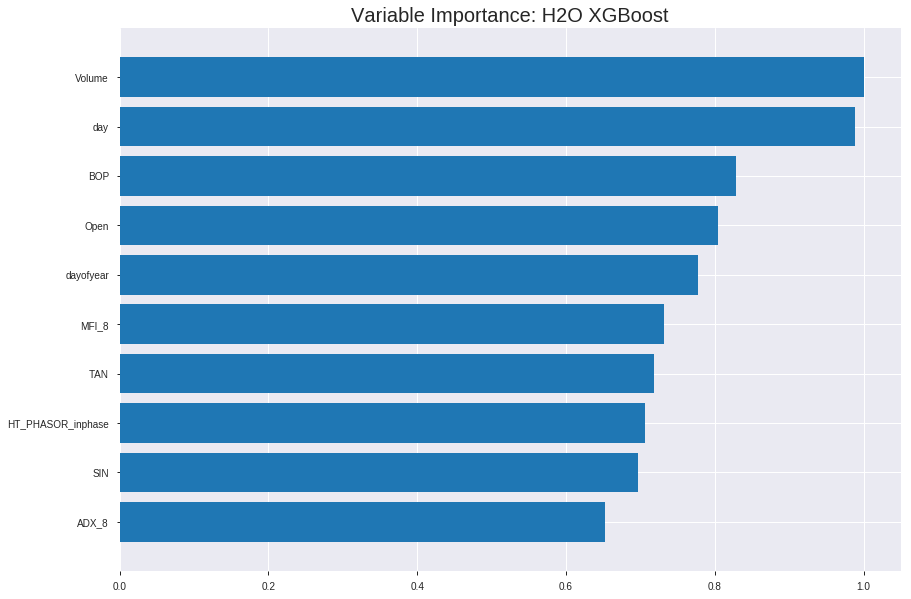

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_185241_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03906561168490988
RMSE: 0.1976502256131014
LogLoss: 0.2102267195488593
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988998899889988
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5857982039451599: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      832  0    0        (0.0/832.0)
1      0    909  0        (0.0/909.0)
Total  832  909  0        (0.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.585798     1        198
max f2                       0.585798     1        198
max f0point5                 0.585798     1        198
max accuracy                 0.585798     1        198
max precision                0.940355     1        0
max recall                   0.585798     1        198
max specificity              0.940355     1        0
max absolute_mcc             0.585798     1        198
max min_per_class_accuracy   0.585798     1        198
max mean_per_class_accuracy  0.585798     1        198

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.916281           1.91529   1.91529            1                0.922936  1                           0.922936            0.019802        0.019802                   91.5292   91.5292
    2        0.0201034                   0.907407           1.91529   1.91529            1                0.911764  1                           0.917509            0.0187019       0.0385039                  91.5292   91.5292
    3        0.0304423                   0.901797           1.91529   1.91529            1                0.904836  1                           0.913205            0.019802        0.0583058                  91.5292   91.5292
    4        0.0402068                   0.896574           1.91529   1.91529            1                0.898752  1                           0.909695            0.0187019       0.0770077                  91.5292   91.5292
    5        0.0505457                   0.891896           1.91529   1.91529            1                0.893809  1                           0.906446            0.019802        0.0968097                  91.5292   91.5292
    6        0.100517                    0.875422           1.91529   1.91529            1                0.883452  1                           0.895014            0.0957096       0.192519                   91.5292   91.5292
    7        0.150488                    0.860125           1.91529   1.91529            1                0.867657  1                           0.88593             0.0957096       0.288229                   91.5292   91.5292
    8        0.20046                     0.848737           1.91529   1.91529            1                0.854493  1                           0.878093            0.0957096       0.383938                   91.5292   91.5292
    9        0.300402                    0.817369           1.91529   1.91529            1                0.831968  1                           0.862748            0.191419        0.575358                   91.5292   91.5292
    10       0.400345                    0.780328           1.91529   1.91529            1                0.798674  1                           0.846752            0.191419        0.766777                   91.5292   91.5292
    11       0.500287                    0.702444           1.91529   1.91529            1                0.749489  1                           0.827322            0.191419        0.958196                   91.5292   91.5292
    12       0.60023                     0.261719           0.418282  1.66603            0.218391         0.385675  0.869856                    0.753785            0.0418042       1                          -58.1718  66.6029
    13       0.700172                    0.21047            0         1.42822            0                0.233827  0.745693                    0.679566            0               1                          -100      42.822
    14       0.800115                    0.172212           0         1.24982            0                0.19034   0.652548                    0.618456            0               1                          -100      24.9821
    15       0.900057                    0.139177           0         1.11104            0                0.155394  0.580089                    0.567038            0               1                          -100      11.104
    16       1                           0.0653604          0         1                  0                0.114406  0.522114                    0.521801           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2652499505126636
RMSE: 0.515024223229028
LogLoss: 0.7267003185353316
Mean Per-Class Error: 0.4799196787148594
AUC: 0.5097982290608216
pr_auc: 0.5080655271204959
Gini: 0.019596458121643234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2629969120025635: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    243  0.9759   (243.0/249.0)
1      2    247  0.008    (2.0/249.0)
Total  8    490  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.262997     0.668471   391
max f2                       0.142711     0.833333   399
max f0point5                 0.275235     0.559616   386
max accuracy                 0.686174     0.52008    52
max precision                0.841126     1          0
max recall                   0.142711     1          399
max specificity              0.841126     1          0
max absolute_mcc             0.262997     0.0638877  391
max min_per_class_accuracy   0.524246     0.506024   200
max mean_per_class_accuracy  0.686174     0.52008    52

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.785509           0.8       0.8                0.4              0.810726  0.4                         0.810726            0.00803213      0.00803213                 -20       -20
    2        0.0200803                   0.772964           1.2       1                  0.6              0.781053  0.5                         0.79589             0.0120482       0.0200803                  20        0
    3        0.0301205                   0.758837           1.2       1.06667            0.6              0.767108  0.533333                    0.786296            0.0120482       0.0321285                  20        6.66667
    4        0.0401606                   0.740565           0.4       0.9                0.2              0.7476    0.45                        0.776622            0.00401606      0.0361446                  -60       -10
    5        0.0502008                   0.729869           2         1.12               1                0.736925  0.56                        0.768683            0.0200803       0.0562249                  100       12
    6        0.100402                    0.695466           1.04      1.08               0.52             0.710246  0.54                        0.739465            0.0522088       0.108434                   4         8
    7        0.150602                    0.671752           1.12      1.09333            0.56             0.681775  0.546667                    0.720235            0.0562249       0.164659                   12        9.33333
    8        0.200803                    0.653585           0.8       1.02               0.4              0.663462  0.51                        0.706041            0.0401606       0.204819                   -20       2
    9        0.301205                    0.609481           0.92      0.986667           0.46             0.63177   0.493333                    0.681284            0.0923695       0.297189                   -8        -1.33333
    10       0.399598                    0.566721           0.979592  0.984925           0.489796         0.588247  0.492462                    0.658376            0.0963855       0.393574                   -2.04082  -1.50754
    11       0.5                         0.524246           1.12      1.01205            0.56             0.5439    0.506024                    0.635388            0.11245         0.506024                   12        1.20482
    12       0.600402                    0.492213           1.08      1.02341            0.54             0.509711  0.511706                    0.614372            0.108434        0.614458                   8         2.34114
    13       0.698795                    0.45982            0.857143  1                  0.428571         0.475059  0.5                         0.594756            0.0843373       0.698795                   -14.2857  0
    14       0.799197                    0.412311           1         1                  0.5              0.438516  0.5                         0.575128            0.100402        0.799197                   0         0
    15       0.899598                    0.345703           1.12      1.01339            0.56             0.383616  0.506696                    0.553754            0.11245         0.911647                   12        1.33929
    16       1                           0.142711           0.88      1                  0.44             0.293071  0.5                         0.527581            0.0883534       1                     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:53:15  17.465 sec  0                  0.5              0.693147            0.5             0                  1                0.477886                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-28 18:53:17  19.143 sec  5                  0.451096         0.599414            0.966844        0.963824           1.91529          0.097645                         0.500703           0.69457               0.511895          0.505178             1.2                0.481928
    2019-08-28 18:53:18  19.977 sec  10                 0.404624         0.516939            0.992036        0.991527           1.91529          0.0402068                        0.501295           0.695791              0.516976          0.506619             0.8                0.471888
    2019-08-28 18:53:18  20.788 sec  15                 0.361378         0.445202            0.99812         0.997224           1.91529          0.0172315                        0.503273           0.699848              0.514169          0.521512             1.2                0.495984
    2019-08-28 18:53:19  21.681 sec  20                 0.324819         0.387915            0.999593        0.998541           1.91529          0.00746697                       0.504444           0.702484              0.519992          0.51873              1.6                0.497992
    2019-08-28 18:53:20  22.535 sec  25                 0.29831          0.348232            0.999877        0.998788           1.91529          0.00402068                       0.505689           0.705026              0.514218          0.520799             1.2                0.485944
    2019-08-28 18:53:21  23.302 sec  30                 0.278967         0.320165            0.999943        0.998848           1.91529          0.00287191                       0.506008           0.70586               0.520209          0.524265             1.2                0.487952
    2019-08-28 18:53:22  24.110 sec  35                 0.256411         0.288348            0.99999         0.996691           1.91529          0.00172315                       0.509506           0.713438              0.51033           0.517302             1.2                0.485944
    2019-08-28 18:53:23  24.956 sec  40                 0.234739         0.258683            0.999995        0.998895           1.91529          0.00114877                       0.50913            0.712737              0.521419          0.529132             1.2                0.487952
    2019-08-28 18:53:23  25.903 sec  45                 0.214911         0.232328            1               0.9967             1.91529          0                                0.512219           0.719772              0.510806          0.514854             1.6                0.485944
    2019-08-28 18:53:24  26.791 sec  50                 0.19765          0.210227            1               0.9989             1.91529          0                                0.515024           0.7267                0.509798          0.508066             0.8                0.491968

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
Volume                   412.9581604003906      1.0                    0.017256356178014954
day                      408.2381896972656      0.988570341609066      0.017059121921827958
BOP                      342.1675109863281      0.8285767029148274     0.014298214706303543
Open                     332.4150695800781      0.8049606508750897     0.013890687700787292
dayofyear                321.142822265625       0.7776643085446127     0.013419652295175553
---                      ---                    ---                    ---
BBANDS_upperband_12_4_4  1.1444475650787354     0.002771340234490382   4.782323417682952e-05
BBANDS_upperband_20_1_2  0.8971541523933411     0.0021725061723528844  3.7489540309057315e-05
BBANDS_lowerband_24_3_2  0.8386795520782471     0.0020309068387584133  3.504605177398156e-05
T3_8_3                   0.6060110330581665     0.001467487729194159   2.532349094184076e-05
MA_8_0                   0.4780771732330322     0.0011576891294980208  1.9977495962033922e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5461847389558233)

('F1', 0.6430517711171662)

('auc', 0.5257471859231466)

('logloss', 0.730022604440187)

('mean_per_class_error', 0.4460473541208436)

('rmse', 0.5146178488151567)

('mse', 0.2648315303191395)

xgboost prediction progress: |████████████████████████████████████████████| 100%


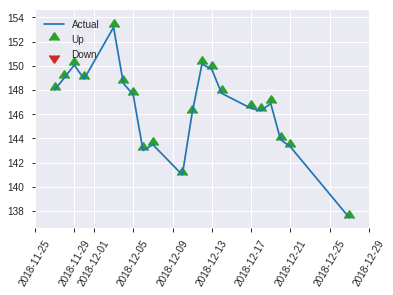


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2648315303191395
RMSE: 0.5146178488151567
LogLoss: 0.730022604440187
Mean Per-Class Error: 0.4460473541208436
AUC: 0.5257471859231466
pr_auc: 0.4704776022432754
Gini: 0.05149437184629324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15812699496746063: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.158127     0.643052  248
max f2                       0.158127     0.818308  248
max f0point5                 0.407098     0.548926  179
max accuracy                 0.47258      0.546185  134
max precision                0.47258      0.518519  134
max recall                   0.158127     1         248
max specificity              0.875789     0.992366  0
max absolute_mcc             0.76395      0.127308  7
max min_per_class_accuracy   0.487527     0.534351  124
max mean_per_class_accuracy  0.407098     0.553953  179

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.831016           0         0                  0                0.855725  0                           0.855725            0               0                          -100      -100
    2        0.0200803                   0.818113           1.05508   0.422034           0.5              0.820906  0.2                         0.841797            0.00847458      0.00847458                 5.50847   -57.7966
    3        0.0321285                   0.761172           0         0.263771           0                0.793193  0.125                       0.823571            0               0.00847458                 -100      -73.6229
    4        0.0401606                   0.746708           2.11017   0.633051           1                0.754069  0.3                         0.80967             0.0169492       0.0254237                  111.017   -36.6949
    5        0.0522088                   0.722865           1.40678   0.811604           0.666667         0.739121  0.384615                    0.79339             0.0169492       0.0423729                  40.678    -18.8396
    6        0.100402                    0.651672           1.05508   0.928475           0.5              0.675338  0.44                        0.736725            0.0508475       0.0932203                  5.50847   -7.15254
    7        0.15261                     0.63467            0.973924  0.944023           0.461538         0.643341  0.447368                    0.704778            0.0508475       0.144068                   -2.60756  -5.59768
    8        0.200803                    0.608253           1.05508   0.970678           0.5              0.616615  0.46                        0.683618            0.0508475       0.194915                   5.50847   -2.9322
    9        0.301205                    0.55908            0.759661  0.900339           0.36             0.584025  0.426667                    0.650421            0.0762712       0.271186                   -24.0339  -9.9661
    10       0.401606                    0.523401           1.51932   1.05508            0.72             0.539024  0.5                         0.622571            0.152542        0.423729                   51.9322   5.50847
    11       0.502008                    0.487527           1.18169   1.08041            0.56             0.505963  0.512                       0.59925             0.118644        0.542373                   18.1695   8.04068
    12       0.598394                    0.445512           1.05508   1.07633            0.5              0.470528  0.510067                    0.578516            0.101695        0.644068                   5.50847   7.63281
    13       0.698795                    0.415286           1.01288   1.06721            0.48             0.431126  0.505747                    0.557339            0.101695        0.745763                   1.28814   6.72122
    14       0.799197                    0.380463           0.928475  1.04978            0.44             0.397706  0.497487                    0.537285            0.0932203       0.838983                   -7.15254  4.97828
    15       0.899598                    0.320854           0.675254  1.00798            0.32             0.355592  0.477679                    0.517007            0.0677966       0.90678                    -32.4746  0.798275
    16       1                           0.158127           0.928475  1                  0.44             0.286317  0.473896                    0.493845     

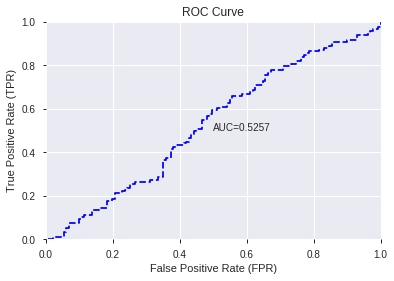

This function is available for GLM models only


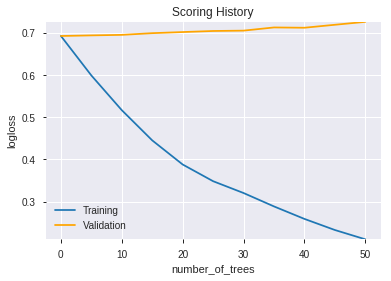

--2019-08-28 18:53:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_185241_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_185241_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_185440_model_7  0.549036  0.936625              0.496183  0.557332  0.310619
1  DeepLearning_grid_1_AutoML_20190828_185440_model_2  0.536357  0.822865              0.500000  0.537287  0.288677
2               DeepLearning_1_AutoML_20190828_185440  0.532216  0.742197              0.500000  0.519040  0.269402
3  DeepLearning_grid_1_AutoML_20190828_185440_model_6  0.527106  0.721534              0.500000  0.511127  0.261251
4  DeepLearning_grid_1_AutoML_20190828_185440_model_8  0.514556  0.692176              0.500000  0.499512  0.249512
5  DeepLearning_grid_1_AutoML_20190828_185440_model_9  0.509251  0.693458              0.500000  0.500137  0.250137
6  DeepLearning_grid_1_AutoML_20190828_185440_model_5  0.497477  0.709300              0.500000  0.507389  0.257443
7  DeepLearning_grid_1_AutoML_20190828_185440_model_3  0.493531  0.838862              0.500000  0.546346  0.298494
8  DeepLearning_grid_1_AutoML_20190828_185440_model_1  0.493207  0.951352              0.500000  0.569539  0.324375
9  DeepLearning_grid_1_AutoML_20190828_185440_model_4  0.481692  1.025744              0.500000  0.572013  0.327198

variable  relative_importance  scaled_importance  percentage
0          weekday_name             1.000000           1.000000    0.021631
1                   COS             0.989087           0.989087    0.021395
2            aroonup_20             0.983856           0.983856    0.021282
3                   day             0.982578           0.982578    0.021254
4                BETA_8             0.977762           0.977762    0.021150
5           CDLPIERCING             0.973805           0.973805    0.021064
6             CORREL_30             0.965487           0.965487    0.020884
7             dayofweek             0.955539           0.955539    0.020669
8              CORREL_8             0.950127           0.950127    0.020552
9                   SIN             0.950112           0.950112    0.020552
10            CORREL_20             0.949231           0.949231    0.020533
11            dayofyear             0.947219           0.947219    0.020489
12            CORREL_12             0.947080           0.947080    0.020486
13               SAREXT             0.943925           0.943925    0.020418
14           aroonup_14             0.943301           0.943301    0.020404
15                  BOP             0.941793           0.941793    0.020372
16       STOCHRSI_fastk             0.940765           0.940765    0.020350
17                DX_12             0.937184           0.937184    0.020272
18         HT_TRENDMODE             0.936214           0.936214    0.020251
19        days_in_month             0.935323           0.935323    0.020232
20         aroondown_14             0.930180           0.930180    0.020121
21       CDLSPINNINGTOP             0.929146           0.929146    0.020098
22         aroondown_20             0.924114           0.924114    0.019989
23          aroondown_8             0.923865           0.923865    0.019984
24      CDLUNIQUE3RIVER             0.923461           0.923461    0.019975
25            CDLTAKURI             0.921460           0.921460    0.019932
26                  EXP             0.920767           0.920767    0.019917
27    CDLLONGLEGGEDDOJI             0.920131           0.920131    0.019903
28                month             0.918735           0.918735    0.019873
29       CDLMORNINGSTAR             0.917530           0.917530    0.019847
30               ADXR_8             0.914669           0.914669    0.019785
31     CDLDRAGONFLYDOJI             0.914112           0.914112    0.019773
32            aroonup_8             0.912258           0.912258    0.019733
33            CORREL_14             0.907637           0.907637    0.019633
34           weekofyear             0.906150           0.906150    0.019601
35              BETA_14             0.903240           0.903240    0.019538
36              weekday             0.903084           0.903084    0.019534
37                ADX_8             0.901891           0.901891    0.019509
38            CDLHAMMER             0.900146           0.900146    0.019471
39          HT_DCPERIOD             0.891935           0.891935    0.019293
40            CDL2CROWS             0.891814           0.891814    0.019291
41   CDLEVENINGDOJISTAR             0.889118           0.889118    0.019232
42  CDLGAPSIDESIDEWHITE             0.889039           0.889039    0.019231
43   CDLMORNINGDOJISTAR             0.888460           0.888460    0.019218
44              quarter             0.887859           0.887859    0.019205
45       STOCHRSI_fastd             0.883985           0.883985    0.019121
46            CDLINNECK             0.875994           0.875994    0.018948
47                 week             0.869122           0.869122    0.018800
48            CORREL_24             0.862609           0.862609    0.018659
49              BETA_12             0.857417           0.857417    0.018547

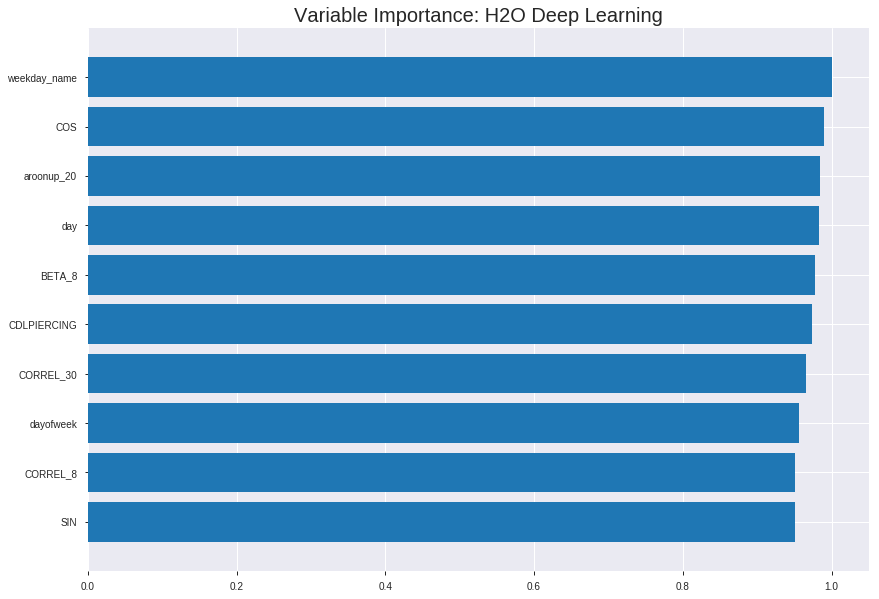

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_185440_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23475633362720935
RMSE: 0.48451659788619145
LogLoss: 0.6581532558652331
Mean Per-Class Error: 0.3092459486333248
AUC: 0.7670503829229076
pr_auc: 0.7739774585767145
Gini: 0.5341007658458152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1924511125885251: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      345  487   0.5853   (487.0/832.0)
1      75   834   0.0825   (75.0/909.0)
Total  420  1321  0.3228   (562.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.192451     0.747982  307
max f2                       0.0740084    0.863385  367
max f0point5                 0.334307     0.703971  213
max accuracy                 0.270709     0.692705  255
max precision                0.999408     1         0
max recall                   0.0312607    1         385
max specificity              0.999408     1         0
max absolute_mcc             0.192451     0.387801  307
max min_per_class_accuracy   0.286064     0.683894  245
max mean_per_class_accuracy  0.270709     0.690754  255

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 33.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.941778           1.91529   1.91529            1                0.971544   1                           0.971544            0.019802        0.019802                   91.5292   91.5292
    2        0.0201034                   0.891788           1.68996   1.80585            0.882353         0.913975   0.942857                    0.943582            0.0165017       0.0363036                  68.9963   80.5846
    3        0.0304423                   0.835588           1.59608   1.7346             0.833333         0.859566   0.90566                     0.915048            0.0165017       0.0528053                  59.6076   73.4604
    4        0.0402068                   0.804031           1.91529   1.77848            1                0.818178   0.928571                    0.891523            0.0187019       0.0715072                  91.5292   77.8485
    5        0.0505457                   0.779992           1.80889   1.7847             0.944444         0.792311   0.931818                    0.871229            0.0187019       0.090209                   80.8886   78.4703
    6        0.100517                    0.66455            1.71716   1.75112            0.896552         0.717056   0.914286                    0.794583            0.0858086       0.176018                   71.7158   75.1124
    7        0.150488                    0.576509           1.60708   1.70329            0.83908          0.613846   0.889313                    0.734567            0.080308        0.256326                   60.7084   70.3294
    8        0.20046                     0.482485           1.38694   1.62443            0.724138         0.528789   0.848138                    0.68327             0.0693069       0.325633                   38.6935   62.4431
    9        0.300402                    0.390011           1.21082   1.48682            0.632184         0.430703   0.776291                    0.599242            0.121012        0.446645                   21.0816   48.6823
    10       0.400345                    0.326101           1.25485   1.42891            0.655172         0.356662   0.746055                    0.538684            0.125413        0.572057                   25.4846   42.8912
    11       0.500287                    0.287426           1.05671   1.35456            0.551724         0.305848   0.707233                    0.49217             0.105611        0.677668                   5.67126   35.4557
    12       0.60023                     0.252748           0.979661  1.29213            0.511494         0.270177   0.674641                    0.455207            0.0979098       0.775578                   -2.03394  29.2134
    13       0.700172                    0.217258           0.902609  1.23653            0.471264         0.235259   0.645611                    0.423812            0.090209        0.865787                   -9.73913  23.6534
    14       0.800115                    0.172215           0.72649   1.17282            0.37931          0.195574   0.612347                    0.395302            0.0726073       0.938394                   -27.351   17.2824
    15       0.900057                    0.0938489          0.484327  1.09637            0.252874         0.133092   0.572431                    0.366186            0.0484048       0.986799                   -51.5673  9.6373
    16       1                           5.35448e-05        0.132089  1                  0.0689655        0.0438645  0.522114                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30957899846055165
RMSE: 0.5563982372910177
LogLoss: 0.8782354918815822
Mean Per-Class Error: 0.4618473895582329
AUC: 0.5360719988387284
pr_auc: 0.5193206407320412
Gini: 0.07214399767745672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.015916624289753552: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    247  0.992    (247.0/249.0)
1      0    249  0        (0.0/249.0)
Total  2    496  0.496    (247.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0159166    0.668456  397
max f2                       0.0159166    0.83445   397
max f0point5                 0.120401     0.571072  351
max accuracy                 0.120401     0.538153  351
max precision                0.929637     0.6       4
max recall                   0.0159166    1         397
max specificity              0.997418     0.995984  0
max absolute_mcc             0.120401     0.118058  351
max min_per_class_accuracy   0.273527     0.522088  207
max mean_per_class_accuracy  0.120401     0.538153  351

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 30.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.920069           1.2       1.2                0.6              0.976352   0.6                         0.976352            0.0120482       0.0120482                  20        20
    2        0.0200803                   0.810995           0.4       0.8                0.2              0.893711   0.4                         0.935032            0.00401606      0.0160643                  -60       -20
    3        0.0301205                   0.724264           0.8       0.8                0.4              0.77152    0.4                         0.880528            0.00803213      0.0240964                  -20       -20
    4        0.0401606                   0.706921           0.4       0.7                0.2              0.719376   0.35                        0.84024             0.00401606      0.0281124                  -60       -30
    5        0.0502008                   0.677587           1.2       0.8                0.6              0.687821   0.4                         0.809756            0.0120482       0.0401606                  20        -20
    6        0.100402                    0.570112           1.36      1.08               0.68             0.612029   0.54                        0.710893            0.0682731       0.108434                   36        8
    7        0.150602                    0.478047           1.28      1.14667            0.64             0.524032   0.573333                    0.648606            0.064257        0.172691                   28        14.6667
    8        0.200803                    0.410974           1.04      1.12               0.52             0.445171   0.56                        0.597747            0.0522088       0.2249                     4         12
    9        0.301205                    0.350897           0.84      1.02667            0.42             0.379308   0.513333                    0.524934            0.0843373       0.309237                   -16       2.66667
    10       0.399598                    0.2983             1.14286   1.05528            0.571429         0.323082   0.527638                    0.475232            0.11245         0.421687                   14.2857   5.52764
    11       0.5                         0.272713           1         1.04418            0.5              0.284807   0.522088                    0.436994            0.100402        0.522088                   0         4.41767
    12       0.600402                    0.252991           1.12      1.05686            0.56             0.263906   0.528428                    0.408049            0.11245         0.634538                   12        5.68562
    13       0.698795                    0.227135           0.734694  1.01149            0.367347         0.242114   0.505747                    0.384685            0.0722892       0.706827                   -26.5306  1.14943
    14       0.799197                    0.179918           1.16      1.03015            0.58             0.206254   0.515075                    0.362269            0.116466        0.823293                   16        3.01508
    15       0.899598                    0.102195           1         1.02679            0.5              0.143845   0.513393                    0.337891            0.100402        0.923695                   0         2.67857
    16       1                           0.00572742         0.76      1                  0.38             0.0541979  0.5                         0.309408            0.0763052  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:58:30  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:58:34  4.502 sec         278 obs/sec       0.592763  1             1032       0.659469         1.44227             -0.743004      0.550284        0.553409           0.744836         0.466399                         0.646341           1.40846               -0.671027        0.519153          0.52026              1.2                0.495984
    2019-08-28 18:58:42  12.499 sec        578 obs/sec       3.63584   6             6330       0.574404         0.922009            -0.322348      0.698688        0.711043           1.91529          0.386559                         0.610239           1.05128               -0.489565        0.530137          0.523613             0.8                0.5
    2019-08-28 18:58:50  20.942 sec        683 obs/sec       7.30672   12            12721      0.484517         0.658153            0.0591343      0.76705         0.773977           1.91529          0.322803                         0.556398           0.878235              -0.238316        0.536072          0.519321             1.2                0.495984
    2019-08-28 18:58:59  29.488 sec        728 obs/sec       11.035    18            19212      0.436535         0.559574            0.236256       0.806168        0.818038           1.91529          0.295807                         0.563101           0.949022              -0.26833         0.521992          0.510509             1.2                0.493976
    2019-08-28 18:59:07  37.989 sec        752 obs/sec       14.7329   24            25650      0.371258         0.416517            0.447589       0.89763         0.896144           1.91529          0.198736                         0.552199           0.931783              -0.219695        0.548193          0.548598             1.6                0.495984
    2019-08-28 18:59:16  46.256 sec        770 obs/sec       18.3808   30            32001      0.41717          0.523084            0.302514       0.917405        0.916308           1.91529          0.176335                         0.596731           1.19025               -0.424352        0.539209          0.538472             1.6                0.477912
    2019-08-28 18:59:24  54.725 sec        780 obs/sec       22.0655   36            38416      0.326166         0.325802            0.57363        0.940217        0.895117           1.91529          0.139575                         0.575921           1.12045               -0.32674         0.532814          0.519007             1.6                0.5
    2019-08-28 18:59:32  1 min  2.984 sec  789 obs/sec       25.726    42            44789      0.298872         0.275019            0.642002       0.964037        0.8891             1.91529          0.113153                         0.604479           1.29471               -0.461579        0.516879          0.527029             2                  0.5
    2019-08-28 18:59:33  1 min  3.777 

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
weekday_name    1.0                    1.0                  0.021630826873050162
COS             0.989086925983429      0.989086925983429    0.02139476805834493
aroonup_20      0.9838563799858093     0.9838563799858093   0.021281627023418896
day             0.9825780391693115     0.9825780391693115   0.02125397545453248
BETA_8          0.9777624607086182     0.9777624607086182   0.02114981051055563
---             ---                    ---                  ---
STOCHRSI_fastd  0.8839849829673767     0.8839849829673767   0.019121326124943522
CDLINNECK       0.8759942650794983     0.8759942650794983   0.01894848028971944
week            0.8691222667694092     0.8691222667694092   0.018799833284002008
CORREL_24       0.8626093864440918     0.8626093864440918   0.018658954297240172
BETA_12         0.857416570186615      0.857416570186615    0.01854662938779113


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5783132530120482)

('F1', 0.644808743169399)

('auc', 0.54903609781343)

('logloss', 0.9366250925935161)

('mean_per_class_error', 0.41716263423470046)

('rmse', 0.5573316896075604)

('mse', 0.31061861224081805)

deeplearning prediction progress: |███████████████████████████████████████| 100%


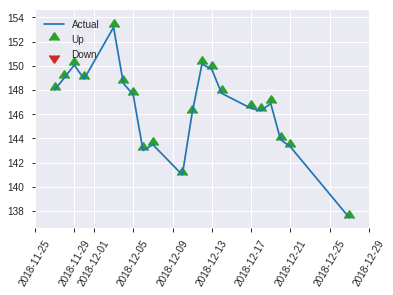


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31061861224081805
RMSE: 0.5573316896075604
LogLoss: 0.9366250925935161
Mean Per-Class Error: 0.41716263423470046
AUC: 0.54903609781343
pr_auc: 0.511474756395374
Gini: 0.09807219562685998
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.007284906618750536: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    130  0.9924   (130.0/131.0)
1      0    118  0        (0.0/118.0)
Total  1    248  0.5221   (130.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00728491   0.644809  247
max f2                       0.00728491   0.819444  247
max f0point5                 0.226429     0.565903  144
max accuracy                 0.226429     0.578313  144
max precision                0.747108     0.666667  5
max recall                   0.00728491   1         247
max specificity              0.958274     0.992366  0
max absolute_mcc             0.226429     0.167738  144
max min_per_class_accuracy   0.253363     0.564885  123
max mean_per_class_accuracy  0.226429     0.582837  144

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 27.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.844995           0.70339   0.70339            0.333333         0.898358   0.333333                    0.898358            0.00847458      0.00847458                 -29.661   -29.661
    2        0.0200803                   0.747542           2.11017   1.2661             1                0.796202   0.6                         0.857496            0.0169492       0.0254237                  111.017   26.6102
    3        0.0321285                   0.712993           0.70339   1.05508            0.333333         0.735281   0.5                         0.811665            0.00847458      0.0338983                  -29.661   5.50847
    4        0.0401606                   0.678035           2.11017   1.2661             1                0.702871   0.6                         0.789906            0.0169492       0.0508475                  111.017   26.6102
    5        0.0522088                   0.653893           0         0.973924           0                0.670784   0.461538                    0.762416            0               0.0508475                  -100      -2.60756
    6        0.100402                    0.538869           1.40678   1.18169            0.666667         0.60341    0.56                        0.686093            0.0677966       0.118644                   40.678    18.1695
    7        0.15261                     0.46218            1.13625   1.16615            0.538462         0.493174   0.552632                    0.620095            0.059322        0.177966                   13.6245   16.6146
    8        0.200803                    0.401031           0.879237  1.09729            0.416667         0.424735   0.52                        0.573208            0.0423729       0.220339                   -12.0763  9.72881
    9        0.301205                    0.315274           1.09729   1.09729            0.52             0.355095   0.52                        0.500504            0.110169        0.330508                   9.72881   9.72881
    10       0.401606                    0.27995            1.09729   1.09729            0.52             0.299412   0.52                        0.450231            0.110169        0.440678                   9.72881   9.72881
    11       0.502008                    0.252795           1.35051   1.14793            0.64             0.265842   0.544                       0.413353            0.135593        0.576271                   35.0508   14.7932
    12       0.598394                    0.219402           0.967161  1.11881            0.458333         0.237076   0.530201                    0.384959            0.0932203       0.669492                   -3.2839   11.8815
    13       0.698795                    0.166503           0.844068  1.07934            0.4              0.196741   0.511494                    0.357917            0.0847458       0.754237                   -15.5932  7.93396
    14       0.799197                    0.109581           0.422034  0.996763           0.2              0.134925   0.472362                    0.329903            0.0423729       0.79661                    -57.7966  -0.323652
    15       0.899598                    0.0590048          0.759661  0.970301           0.36             0.0843814  0.459821                    0.302501            0.0762712       0.872881                   -24.0339  -2.96988
    16       1                           0.00558747         1.2661    1                  0.6              0.0299922  0.473896               

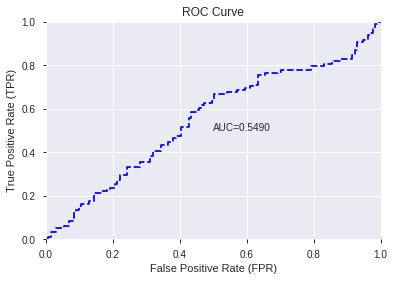

This function is available for GLM models only


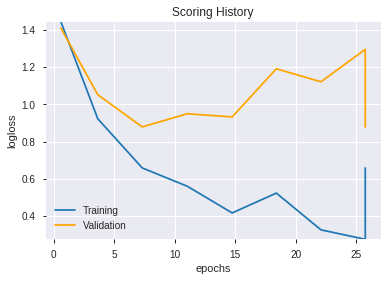

--2019-08-28 19:01:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.22.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.22.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_185440_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_185440_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'COS',
 'aroonup_20',
 'day',
 'BETA_8',
 'CDLPIERCING',
 'CORREL_30',
 'dayofweek',
 'CORREL_8',
 'SIN',
 'CORREL_20',
 'dayofyear',
 'CORREL_12',
 'SAREXT',
 'aroonup_14',
 'BOP',
 'STOCHRSI_fastk',
 'DX_12',
 'HT_TRENDMODE',
 'days_in_month',
 'aroondown_14',
 'CDLSPINNINGTOP',
 'aroondown_20',
 'aroondown_8',
 'CDLUNIQUE3RIVER',
 'CDLTAKURI',
 'EXP',
 'CDLLONGLEGGEDDOJI',
 'month',
 'CDLMORNINGSTAR',
 'ADXR_8',
 'CDLDRAGONFLYDOJI',
 'aroonup_8',
 'CORREL_14',
 'weekofyear',
 'BETA_14',
 'weekday',
 'ADX_8',
 'CDLHAMMER',
 'HT_DCPERIOD',
 'CDL2CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'quarter',
 'STOCHRSI_fastd',
 'CDLINNECK',
 'week',
 'CORREL_24',
 'BETA_12']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_190223_model_1  0.506534  0.69615                   0.5  0.501488  0.25149

variable  relative_importance  scaled_importance  percentage
0            aroonup_20             0.037674           1.000000    0.059991
1             CORREL_24             0.030018           0.796784    0.047800
2        STOCHRSI_fastk             0.028447           0.755089    0.045299
3       CDLUNIQUE3RIVER             0.027736           0.736215    0.044166
4           aroondown_8             0.027549           0.731238    0.043868
5             CORREL_20             0.026356           0.699587    0.041969
6                   BOP             0.026186           0.695078    0.041699
7             aroonup_8             0.022721           0.603100    0.036181
8          aroondown_14             0.022049           0.585245    0.035110
9        CDLSPINNINGTOP             0.020119           0.534020    0.032037
10                  EXP             0.020108           0.533725    0.032019
11                ADX_8             0.019669           0.522092    0.031321
12          HT_DCPERIOD             0.017590           0.466912    0.028011
13            CDLINNECK             0.017457           0.463369    0.027798
14               SAREXT             0.016868           0.447736    0.026860
15            CDL2CROWS             0.016685           0.442865    0.026568
16            CORREL_30             0.015421           0.409331    0.024556
17            CORREL_12             0.015178           0.402887    0.024170
18                DX_12             0.014672           0.389456    0.023364
19           aroonup_14             0.012995           0.344941    0.020693
20  CDLGAPSIDESIDEWHITE             0.012483           0.331348    0.019878
21   CDLEVENINGDOJISTAR             0.011140           0.295688    0.017739
22     CDLDRAGONFLYDOJI             0.010590           0.281101    0.016864
23                 week             0.010259           0.272307    0.016336
24           weekofyear             0.010253           0.272141    0.016326
25               ADXR_8             0.010104           0.268196    0.016089
26                  COS             0.009553           0.253573    0.015212
27             CORREL_8             0.009025           0.239566    0.014372
28       CDLMORNINGSTAR             0.009007           0.239084    0.014343
29    CDLLONGLEGGEDDOJI             0.008281           0.219807    0.013186
30              quarter             0.008015           0.212749    0.012763
31              BETA_14             0.007304           0.193883    0.011631
32         HT_TRENDMODE             0.007260           0.192705    0.011561
33                  SIN             0.006655           0.176634    0.010596
34            dayofweek             0.006184           0.164144    0.009847
35              weekday             0.006180           0.164039    0.009841
36            CDLTAKURI             0.005918           0.157090    0.009424
37            CORREL_14             0.005200           0.138022    0.008280
38            dayofyear             0.005144           0.136540    0.008191
39                  day             0.004827           0.128125    0.007686
40                month             0.004610           0.122357    0.007340
41        days_in_month             0.004109           0.109080    0.006544
42              BETA_12             0.003927           0.104224    0.006253
43         weekday_name             0.003552           0.094280    0.005656
44   CDLMORNINGDOJISTAR             0.003463           0.091921    0.005514
45               BETA_8             0.002218           0.058884    0.003533
46          CDLPIERCING             0.002189           0.058090    0.003485
47         aroondown_20             0.001964           0.052139    0.003128
48            CDLHAMMER             0.001677           0.044510    0.002670
49       STOCHRSI_fastd             0.001401           0.037196    0.002231

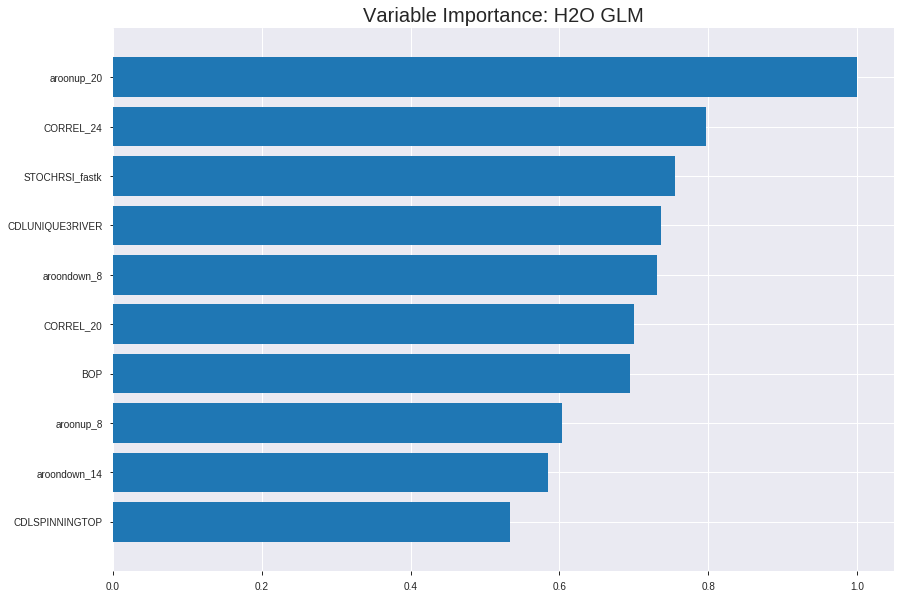

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_190223_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24541670855699704
RMSE: 0.4953955072030802
LogLoss: 0.6839269238690096
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2410.1318575316827
Residual deviance: 2381.433548911891
AIC: 2483.433548911891
AUC: 0.5863507023779301
pr_auc: 0.5880123014591018
Gini: 0.17270140475586016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4740336545764331: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      87   745   0.8954   (745.0/832.0)
1      40   869   0.044    (40.0/909.0)
Total  127  1614  0.4509   (785.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474034     0.688862  339
max f2                       0.402478     0.846054  394
max f0point5                 0.501918     0.6       265
max accuracy                 0.501918     0.573234  265
max precision                0.667266     1         0
max recall                   0.402478     1         394
max specificity              0.667266     1         0
max absolute_mcc             0.492879     0.146186  292
max min_per_class_accuracy   0.523679     0.557692  194
max mean_per_class_accuracy  0.519282     0.562788  208

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.587101           1.17046   1.17046            0.611111         0.603946  0.611111                    0.603946            0.0121012       0.0121012                  17.0456   17.0456
    2        0.0201034                   0.581615           1.12664   1.14917            0.588235         0.583492  0.6                         0.594011            0.0110011       0.0231023                  12.6642   14.9175
    3        0.0304423                   0.577519           1.06405   1.12026            0.555556         0.579624  0.584906                    0.589125            0.0110011       0.0341034                  6.40508   12.0265
    4        0.0402068                   0.574509           1.12664   1.12181            0.588235         0.575851  0.585714                    0.585901            0.0110011       0.0451045                  12.6642   12.1814
    5        0.0505457                   0.572371           1.38327   1.17529            0.722222         0.573369  0.613636                    0.583338            0.0143014       0.0594059                  38.3266   17.5293
    6        0.100517                    0.563078           1.32089   1.24768            0.689655         0.567118  0.651429                    0.575274            0.0660066       0.125413                   32.0891   24.7676
    7        0.150488                    0.555702           1.01268   1.16964            0.528736         0.559395  0.610687                    0.570002            0.0506051       0.176018                   1.26829   16.9644
    8        0.20046                     0.550388           1.23283   1.1854             0.643678         0.552824  0.618911                    0.565719            0.0616062       0.237624                   23.2831   18.5395
    9        0.300402                    0.539779           1.07873   1.14991            0.563218         0.544903  0.600382                    0.558794            0.107811        0.345435                   7.87274   14.9907
    10       0.400345                    0.531295           1.07873   1.13214            0.563218         0.535656  0.591105                    0.553018            0.107811        0.453245                   7.87274   13.2138
    11       0.500287                    0.524028           1.01268   1.10827            0.528736         0.527489  0.578645                    0.547918            0.10121         0.554455                   1.26829   10.8274
    12       0.60023                     0.515917           0.979661  1.08686            0.511494         0.519749  0.567464                    0.543227            0.0979098       0.652365                   -2.03394  8.68592
    13       0.700172                    0.506158           1.04571   1.08098            0.545977         0.510711  0.564397                    0.538586            0.10451         0.756876                   4.57051   8.09849
    14       0.800115                    0.495976           0.946638  1.0642             0.494253         0.501423  0.555635                    0.533944            0.0946095       0.851485                   -5.33617  6.42036
    15       0.900057                    0.479876           0.803542  1.03526            0.41954          0.488598  0.540523                    0.528909            0.080308        0.931793                   -19.6458  3.52597
    16       1                           0.337631           0.68246   1                  0.356322         0.46092   0.522114                    0.522114         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25007647692947105
RMSE: 0.5000764710816448
LogLoss: 0.6933198429863507
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 691.349667579769
Residual deviance: 690.5465636144054
AIC: 792.5465636144054
AUC: 0.5204432186577637
pr_auc: 0.5137296078267073
Gini: 0.040886437315527324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.442450146907695: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    245  0.9839   (245.0/249.0)
1      1    248  0.004    (1.0/249.0)
Total  5    493  0.494    (246.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44245      0.668464  394
max f2                       0.426367     0.833333  399
max f0point5                 0.491823     0.572399  325
max accuracy                 0.492107     0.544177  323
max precision                0.692758     1         0
max recall                   0.426367     1         399
max specificity              0.692758     1         0
max absolute_mcc             0.491823     0.119116  325
max min_per_class_accuracy   0.522839     0.522088  192
max mean_per_class_accuracy  0.492107     0.544177  323

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.15 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100402                   0.581585           1.2      1.2                0.6              0.624282  0.6                         0.624282            0.0120482       0.0120482                  20       20
    2        0.0200803                   0.579354           1.2      1.2                0.6              0.580894  0.6                         0.602588            0.0120482       0.0240964                  20       20
    3        0.0301205                   0.578216           0.8      1.06667            0.4              0.578894  0.533333                    0.59469             0.00803213      0.0321285                  -20      6.66667
    4        0.0401606                   0.575229           1.2      1.1                0.6              0.577475  0.55                        0.590386            0.0120482       0.0441767                  20       10
    5        0.0502008                   0.569584           0.8      1.04               0.4              0.572585  0.52                        0.586826            0.00803213      0.0522088                  -20      4
    6        0.100402                    0.558301           1.2      1.12               0.6              0.563793  0.56                        0.57531             0.060241        0.11245                    20       12
    7        0.150602                    0.551687           0.88     1.04               0.44             0.554489  0.52                        0.568369            0.0441767       0.156627                   -12      4
    8        0.200803                    0.546556           0.88     1                  0.44             0.549124  0.5                         0.563558            0.0441767       0.200803                   -12      0
    9        0.301205                    0.535689           1.08     1.02667            0.54             0.54062   0.513333                    0.555912            0.108434        0.309237                   8        2.66667
    10       0.399598                    0.529174           1.06122  1.03518            0.530612         0.532636  0.517588                    0.550181            0.104418        0.413655                   6.12245  3.51759
    11       0.5                         0.522727           1.08     1.04418            0.54             0.525533  0.522088                    0.545231            0.108434        0.522088                   8        4.41767
    12       0.600402                    0.515262           0.72     0.989967           0.36             0.519028  0.494983                    0.54085             0.0722892       0.594378                   -28      -1.00334
    13       0.698795                    0.508422           1.06122  1                  0.530612         0.511313  0.5                         0.536691            0.104418        0.698795                   6.12245  0
    14       0.799197                    0.497694           1.28     1.03518            0.64             0.503879  0.517588                    0.532569            0.128514        0.827309                   28       3.51759
    15       0.899598                    0.483704           0.92     1.02232            0.46             0.490335  0.511161                    0.527855            0.0923695       0.919679                   -8       2.23214
    16       1                           0.426367           0.8      1                  0.4              0.464567  0.5                         0.521501            0.0803213       1                          -20      0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 19:02:23  0.000 sec   2            3.5       51            1.3794            1.38732
    2019-08-28 19:02:23  0.013 sec   4            2.1       51            1.37732           1.38706
    2019-08-28 19:02:23  0.026 sec   6            1.3       51            1.3747            1.38681
    2019-08-28 19:02:23  0.043 sec   8            0.83      51            1.37152           1.38665
    2019-08-28 19:02:23  0.061 sec   10           0.51      51            1.36785           1.38664
    2019-08-28 19:02:23  0.072 sec   12           0.32      51            1.36385           1.38688
    2019-08-28 19:02:23  0.084 sec   14           0.2       51            1.35975           1.38752
    2019-08-28 19:02:23  0.097 sec   16           0.12      51            1.35585           1.38868
    2019-08-28 19:02:23  0.109 sec   18           0.076     51            1.35238           1.39044
    2019-08-28 19:02:23  0.122 sec   20           0.047     51            1.34945           1.39284

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.6430517711171662)

('auc', 0.5065338336136628)

('logloss', 0.6961503543256198)

('mean_per_class_error', 0.4699508345193427)

('rmse', 0.5014879224182177)

('mse', 0.2514901363313403)

glm prediction progress: |████████████████████████████████████████████████| 100%


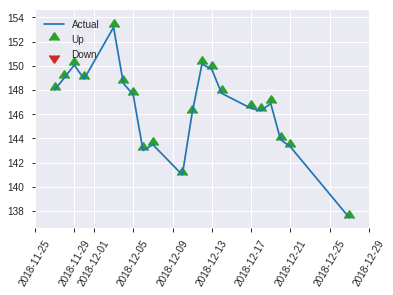


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2514901363313403
RMSE: 0.5014879224182177
LogLoss: 0.6961503543256198
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 346.8254982835162
Residual deviance: 346.68287645415865
AIC: 448.68287645415865
AUC: 0.5065338336136628
pr_auc: 0.4916010203690361
Gini: 0.013067667227325552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4065740738864588: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406574     0.643052  248
max f2                       0.406574     0.818308  248
max f0point5                 0.472408     0.531915  228
max accuracy                 0.544066     0.550201  25
max precision                0.571996     1         0
max recall                   0.406574     1         248
max specificity              0.571996     1         0
max absolute_mcc             0.445599     0.146358  240
max min_per_class_accuracy   0.515032     0.466102  115
max mean_per_class_accuracy  0.543398     0.530049  27

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 51.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.569499           1.40678   1.40678            0.666667         0.571204  0.666667                    0.571204            0.0169492       0.0169492                  40.678    40.678
    2        0.0200803                   0.565252           1.05508   1.2661             0.5              0.568667  0.6                         0.570189            0.00847458      0.0254237                  5.50847   26.6102
    3        0.0321285                   0.557443           1.40678   1.31886            0.666667         0.560865  0.625                       0.566693            0.0169492       0.0423729                  40.678    31.8856
    4        0.0401606                   0.555003           1.05508   1.2661             0.5              0.555581  0.6                         0.56447             0.00847458      0.0508475                  5.50847   26.6102
    5        0.0522088                   0.554125           0.70339   1.13625            0.333333         0.554564  0.538462                    0.562184            0.00847458      0.059322                   -29.661   13.6245
    6        0.100402                    0.544144           1.40678   1.2661             0.666667         0.547514  0.6                         0.555143            0.0677966       0.127119                   40.678    26.6102
    7        0.15261                     0.539502           0.811604  1.11062            0.384615         0.542074  0.526316                    0.550672            0.0423729       0.169492                   -18.8396  11.0616
    8        0.200803                    0.532482           0.879237  1.05508            0.416667         0.536048  0.5                         0.547162            0.0423729       0.211864                   -12.0763  5.50847
    9        0.301205                    0.526108           1.01288   1.04102            0.48             0.528717  0.493333                    0.541014            0.101695        0.313559                   1.28814   4.10169
    10       0.401606                    0.520164           0.675254  0.949576           0.32             0.522637  0.45                        0.53642             0.0677966       0.381356                   -32.4746  -5.04237
    11       0.502008                    0.51279            0.844068  0.928475           0.4              0.515647  0.44                        0.532265            0.0847458       0.466102                   -15.5932  -7.15254
    12       0.598394                    0.507262           1.40678   1.00552            0.666667         0.509683  0.47651                     0.528628            0.135593        0.601695                   40.678    0.551701
    13       0.698795                    0.499085           1.01288   1.00658            0.48             0.50283   0.477011                    0.524921            0.101695        0.70339                    1.28814   0.65751
    14       0.799197                    0.492131           1.09729   1.01797            0.52             0.495812  0.482412                    0.521264            0.110169        0.813559                   9.72881   1.79712
    15       0.899598                    0.47603            0.928475  1.00798            0.44             0.485467  0.477679                    0.517269            0.0932203       0.90678                    -7.15254  0.798275
    16       1                           0.406574           0.928475  1                  0.44             0.451126  0.473896                    0.510628      

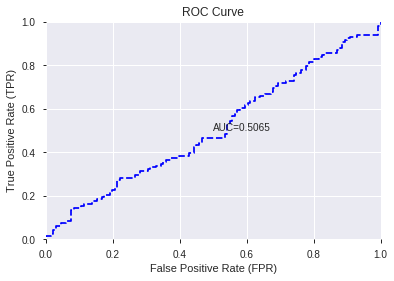

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


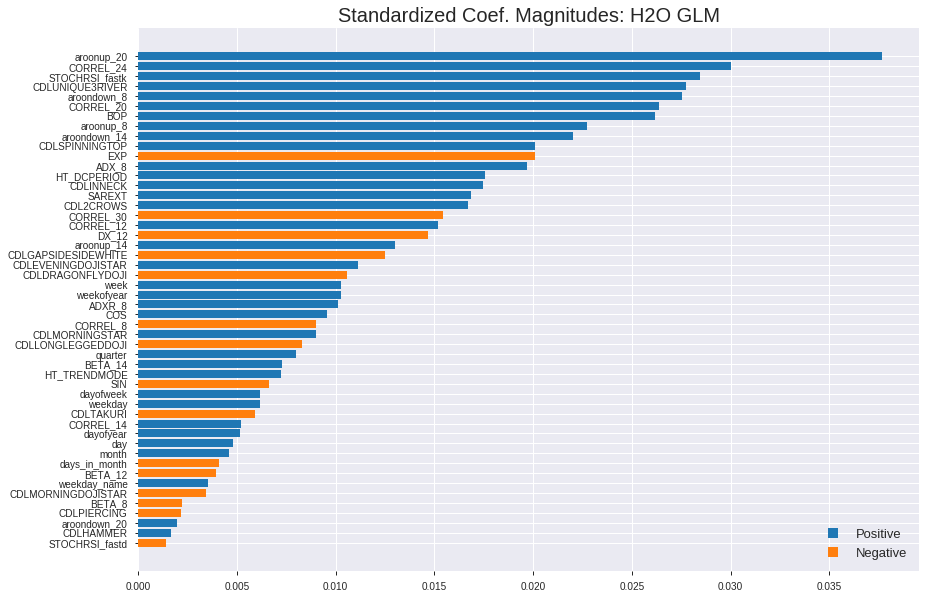

'log_likelihood'
--2019-08-28 19:02:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_190223_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_190223_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['aroonup_20',
 'CORREL_24',
 'STOCHRSI_fastk',
 'CDLUNIQUE3RIVER',
 'aroondown_8',
 'CORREL_20',
 'BOP',
 'aroonup_8',
 'aroondown_14',
 'CDLSPINNINGTOP',
 'EXP',
 'ADX_8',
 'HT_DCPERIOD',
 'CDLINNECK',
 'SAREXT',
 'CDL2CROWS',
 'CORREL_30',
 'CORREL_12',
 'DX_12',
 'aroonup_14',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'week',
 'weekofyear',
 'ADXR_8',
 'COS',
 'CORREL_8',
 'CDLMORNINGSTAR',
 'CDLLONGLEGGEDDOJI',
 'quarter',
 'BETA_14',
 'HT_TRENDMODE',
 'SIN',
 'dayofweek',
 'weekday',
 'CDLTAKURI',
 'CORREL_14',
 'dayofyear',
 'day',
 'month',
 'days_in_month',
 'BETA_12',
 'weekday_name',
 'CDLMORNINGDOJISTAR',
 'BETA_8',
 'CDLPIERCING',
 'aroondown_20',
 'CDLHAMMER',
 'STOCHRSI_fastd']

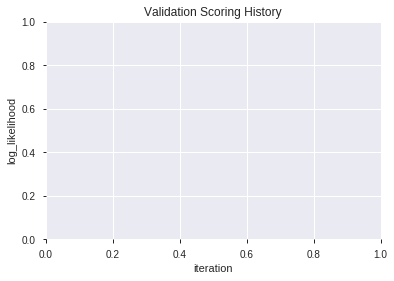

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_190329_model_3  0.554470  0.687356              0.460118  0.497193  0.247200
1  XGBoost_grid_1_AutoML_20190828_190329_model_6  0.553629  0.694542              0.500000  0.500508  0.250508
2  XGBoost_grid_1_AutoML_20190828_190329_model_4  0.544572  0.693500              0.500000  0.500088  0.250088
3  XGBoost_grid_1_AutoML_20190828_190329_model_5  0.542826  0.711676              0.500000  0.508131  0.258198
4               XGBoost_3_AutoML_20190828_190329  0.542114  0.694073              0.482178  0.500313  0.250313
5               XGBoost_1_AutoML_20190828_190329  0.536098  0.700798              0.500000  0.503470  0.253483
6  XGBoost_grid_1_AutoML_20190828_190329_model_2  0.519019  0.698419              0.500000  0.502506  0.252512
7  XGBoost_grid_1_AutoML_20190828_190329_model_1  0.517402  0.702513              0.500000  0.504414  0.254433
8               XGBoost_2_AutoML_20190828_190329  0.517014  0.705774              0.500000  0.506015  0.256052
9  XGBoost_grid_1_AutoML_20190828_190329_model_7  0.485380  0.718968              0.492366  0.512188  0.262336

variable  relative_importance  scaled_importance  percentage
0             BETA_14           273.384644           1.000000    0.054157
1             BETA_12           269.545502           0.985957    0.053397
2               ADX_8           261.677399           0.957177    0.051838
3      STOCHRSI_fastd           258.061707           0.943951    0.051122
4           CORREL_30           250.001953           0.914470    0.049525
5                 BOP           249.010208           0.910842    0.049329
6                 SIN           222.870132           0.815225    0.044150
7              ADXR_8           222.736923           0.814738    0.044124
8              SAREXT           211.391998           0.773240    0.041877
9                 COS           195.049927           0.713463    0.038639
10          CORREL_24           193.754227           0.708724    0.038383
11          CORREL_14           181.511093           0.663940    0.035957
12        HT_DCPERIOD           162.197433           0.593294    0.032131
13          dayofyear           159.517014           0.583489    0.031600
14                day           159.165787           0.582205    0.031531
15              DX_12           157.901794           0.577581    0.031280
16         aroonup_20           142.978821           0.522995    0.028324
17          CORREL_20           142.347885           0.520687    0.028199
18       aroondown_14           137.957016           0.504626    0.027329
19                EXP           134.329071           0.491356    0.026611
20          CORREL_12           115.210785           0.421424    0.022823
21       aroondown_20           109.682701           0.401203    0.021728
22             BETA_8           106.849533           0.390840    0.021167
23               week           103.134544           0.377251    0.020431
24          dayofweek            97.603264           0.357018    0.019335
25           CORREL_8            92.287468           0.337574    0.018282
26        aroondown_8            82.542389           0.301928    0.016352
27         aroonup_14            72.355957           0.264667    0.014334
28     STOCHRSI_fastk            67.394600           0.246519    0.013351
29          aroonup_8            52.429169           0.191778    0.010386
30       weekday_name            43.651516           0.159671    0.008647
31            weekday            30.131966           0.110218    0.005969
32              month            26.419569           0.096639    0.005234
33         weekofyear            23.495510           0.085943    0.004654
34      days_in_month            15.166254           0.055476    0.003004
35       HT_TRENDMODE            13.911475           0.050886    0.002756
36  CDLLONGLEGGEDDOJI             5.211386           0.019062    0.001032
37     CDLSPINNINGTOP             5.096760           0.018643    0.001010

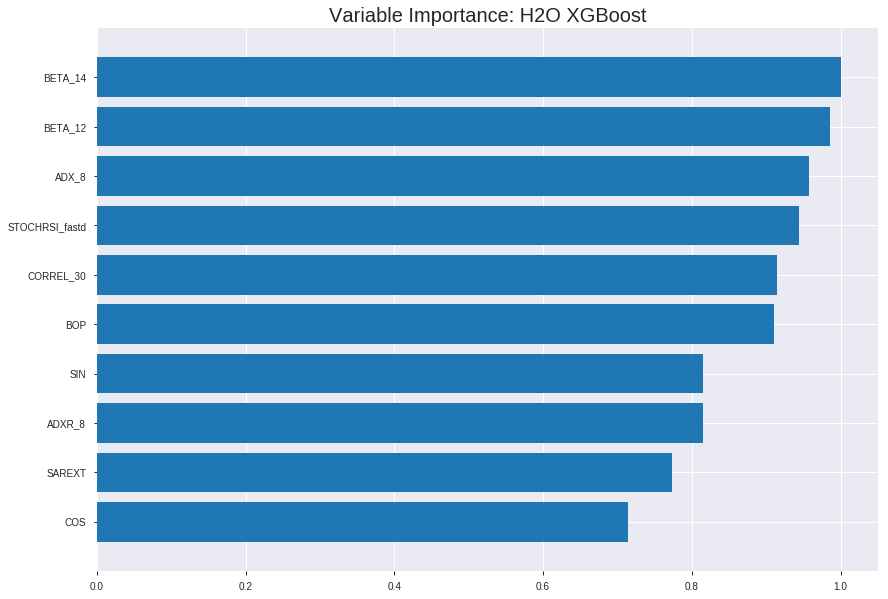

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_190329_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18495368102264734
RMSE: 0.43006241526393274
LogLoss: 0.5591127735884459
Mean Per-Class Error: 0.161285118896505
AUC: 0.9120308665481933
pr_auc: 0.9183534455918686
Gini: 0.8240617330963866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5139942169189453: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      679  153  0.1839   (153.0/832.0)
1      129  780  0.1419   (129.0/909.0)
Total  808  933  0.162    (282.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513994     0.846906  207
max f2                       0.44681      0.896236  272
max f0point5                 0.556179     0.85816   164
max accuracy                 0.516754     0.839173  204
max precision                0.787793     1         0
max recall                   0.311249     1         373
max specificity              0.787793     1         0
max absolute_mcc             0.516754     0.677613  204
max min_per_class_accuracy   0.521297     0.83774   199
max mean_per_class_accuracy  0.522108     0.838715  198

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.12 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.734762           1.91529    1.91529            1                0.754739  1                           0.754739            0.019802        0.019802                   91.5292   91.5292
    2        0.0201034                   0.717802           1.91529    1.91529            1                0.725425  1                           0.740501            0.0187019       0.0385039                  91.5292   91.5292
    3        0.0304423                   0.706239           1.91529    1.91529            1                0.712001  1                           0.730822            0.019802        0.0583058                  91.5292   91.5292
    4        0.0402068                   0.695924           1.91529    1.91529            1                0.702069  1                           0.723839            0.0187019       0.0770077                  91.5292   91.5292
    5        0.0505457                   0.688255           1.91529    1.91529            1                0.692591  1                           0.717447            0.019802        0.0968097                  91.5292   91.5292
    6        0.100517                    0.662627           1.89328    1.90435            0.988506         0.674191  0.994286                    0.695943            0.0946095       0.191419                   89.3277   90.4347
    7        0.150488                    0.640419           1.82723    1.87874            0.954023         0.650982  0.980916                    0.681013            0.0913091       0.282728                   82.7232   87.874
    8        0.20046                     0.623872           1.7832     1.85492            0.931034         0.632025  0.968481                    0.668801            0.0891089       0.371837                   78.3202   85.4924
    9        0.300402                    0.591012           1.70615    1.80543            0.890805         0.607293  0.942639                    0.648338            0.170517        0.542354                   70.6151   80.5428
    10       0.400345                    0.560385           1.51902    1.73393            0.793103         0.576059  0.905308                    0.630294            0.151815        0.694169                   51.9024   73.393
    11       0.500287                    0.525467           1.26585    1.64042            0.66092          0.543118  0.856487                    0.612879            0.126513        0.820682                   26.5854   64.0422
    12       0.60023                     0.490822           0.781527   1.49741            0.408046         0.508357  0.781818                    0.595475            0.0781078       0.89879                    -21.8473  49.741
    13       0.700172                    0.459752           0.539364   1.36066            0.281609         0.474638  0.710418                    0.578227            0.0539054       0.952695                   -46.0636  36.0658
    14       0.800115                    0.422495           0.2972     1.22782            0.155172         0.440332  0.641062                    0.561002            0.029703        0.982398                   -70.28    22.7821
    15       0.900057                    0.372241           0.143096   1.10737            0.0747126        0.399079  0.578175                    0.543022            0.0143014       0.9967                     -85.6904  10.7373
    16       1                           0.222377           0.0330223  1                  0.0172414        0.324301  0.522114                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25215629756519636
RMSE: 0.5021516678904854
LogLoss: 0.6977929709909391
Mean Per-Class Error: 0.46787148594377514
AUC: 0.5316930372090773
pr_auc: 0.5282674653903089
Gini: 0.06338607441815469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3187336027622223: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    249  1        (249.0/249.0)
1      0    249  0        (0.0/249.0)
Total  0    498  0.5      (249.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.318734     0.666667   399
max f2                       0.318734     0.833333   399
max f0point5                 0.462835     0.560224   305
max accuracy                 0.509783     0.532129   222
max precision                0.677528     0.666667   5
max recall                   0.318734     1          399
max specificity              0.761799     0.995984   0
max absolute_mcc             0.624517     0.0910517  42
max min_per_class_accuracy   0.519727     0.522088   203
max mean_per_class_accuracy  0.509783     0.532129   222

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.677672           1.2       1.2                0.6              0.702653  0.6                         0.702653            0.0120482       0.0120482                  20        20
    2        0.0200803                   0.658442           0.8       1                  0.4              0.667064  0.5                         0.684858            0.00803213      0.0200803                  -20       0
    3        0.0301205                   0.652627           1.2       1.06667            0.6              0.656582  0.533333                    0.675433            0.0120482       0.0321285                  20        6.66667
    4        0.0401606                   0.648392           0.8       1                  0.4              0.650453  0.5                         0.669188            0.00803213      0.0401606                  -20       0
    5        0.0502008                   0.640918           1.6       1.12               0.8              0.64473   0.56                        0.664296            0.0160643       0.0562249                  60        12
    6        0.100402                    0.621722           1.28      1.2                0.64             0.630133  0.6                         0.647215            0.064257        0.120482                   28        20
    7        0.150602                    0.598287           0.96      1.12               0.48             0.6104    0.56                        0.634943            0.0481928       0.168675                   -4        12
    8        0.200803                    0.583325           1.12      1.12               0.56             0.589375  0.56                        0.623551            0.0562249       0.2249                     12        12
    9        0.301205                    0.562897           0.76      1                  0.38             0.571948  0.5                         0.60635             0.0763052       0.301205                   -24       0
    10       0.399598                    0.537941           1.18367   1.04523            0.591837         0.549873  0.522613                    0.592443            0.116466        0.417671                   18.3673   4.52261
    11       0.5                         0.517942           1.04      1.04418            0.52             0.528286  0.522088                    0.57956             0.104418        0.522088                   4         4.41767
    12       0.600402                    0.499787           0.96      1.0301             0.48             0.508727  0.51505                     0.567715            0.0963855       0.618474                   -4        3.01003
    13       0.698795                    0.47717            0.938776  1.01724            0.469388         0.4897    0.508621                    0.55673             0.0923695       0.710843                   -6.12245  1.72414
    14       0.799197                    0.455367           1         1.01508            0.5              0.467281  0.507538                    0.545493            0.100402        0.811245                   0         1.50754
    15       0.899598                    0.418073           0.96      1.00893            0.48             0.436813  0.504464                    0.533364            0.0963855       0.907631                   -4        0.892857
    16       1                           0.318734           0.92      1                  0.46             0.380903  0.5                         0.518056            0.0923695       1                      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:03:36  1.833 sec   0                  0.5              0.693147            0.5             0                  1                0.477886                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-28 19:03:36  1.943 sec   5                  0.48992          0.673144            0.73359         0.743061           1.91529          0.35784                          0.501198           0.695545              0.471767          0.499495             1.6                0.495984
    2019-08-28 19:03:36  2.011 sec   10                 0.480569         0.654831            0.797188        0.802407           1.91529          0.29753                          0.502039           0.697241              0.479718          0.507707             2                  0.5
    2019-08-28 19:03:36  2.080 sec   15                 0.47366          0.641422            0.822024        0.826369           1.80889          0.256175                         0.501537           0.69623               0.494613          0.512879             1.6                0.493976
    2019-08-28 19:03:36  2.155 sec   20                 0.464858         0.624472            0.842345        0.848668           1.80889          0.237794                         0.502169           0.697518              0.503339          0.520176             1.2                0.497992
    2019-08-28 19:03:36  2.233 sec   25                 0.457275         0.609988            0.858395        0.868246           1.91529          0.224009                         0.502395           0.698043              0.510693          0.512093             0.8                0.495984
    2019-08-28 19:03:36  2.310 sec   30                 0.451214         0.598486            0.870457        0.880012           1.91529          0.211947                         0.501684           0.696628              0.520629          0.5184               0.4                0.495984
    2019-08-28 19:03:36  2.390 sec   35                 0.445352         0.587498            0.884956        0.894857           1.91529          0.194716                         0.50165            0.696633              0.528508          0.520551             0.8                0.497992
    2019-08-28 19:03:36  2.462 sec   40                 0.44157          0.580256            0.884936        0.893999           1.91529          0.198162                         0.502302           0.698104              0.529822          0.518665             0.4                0.493976
    2019-08-28 19:03:36  2.554 sec   45                 0.435343         0.568765            0.899729        0.906856           1.91529          0.177484                         0.502964           0.699454              0.521975          0.517433             1.2                0.497992
    2019-08-28 19:03:37  2.642 sec   50                 0.430062         0.559113            0.912031        0.918353           1.91529          0.161976                         0.502152           0.697793              0.531693          0.528267             1.2                0.5

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BETA_14            273.3846435546875      1.0                   0.05415739273472364
BETA_12            269.5455017089844      0.9859569952584585    0.05339686021176039
ADX_8              261.6773986816406      0.9571766551302104    0.05183819202839594
STOCHRSI_fastd     258.06170654296875     0.9439509958844723    0.051121924806448865
CORREL_30          250.001953125          0.9144696273877941    0.04952529075441716
---                ---                    ---                   ---
weekofyear         23.49551010131836      0.08594305004047657   0.0046544515138620965
days_in_month      15.166254043579102     0.05547588133107873   0.003004429092552154
HT_TRENDMODE       13.91147518157959      0.050886088555287694  0.0027558578826226417
CDLLONGLEGGEDDOJI  5.211385726928711      0.01906246692999138   0.0010323735080202247
CDLSPINNINGTOP     5.096760272979736      0.01864318422099004   0.0010096662496819604


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.653179190751445)

('auc', 0.5544701772544961)

('logloss', 0.6873561370255046)

('mean_per_class_error', 0.43695820934144136)

('rmse', 0.49719250680881544)

('mse', 0.24720038882683398)

xgboost prediction progress: |████████████████████████████████████████████| 100%


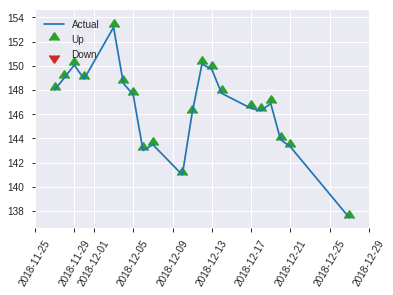


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24720038882683398
RMSE: 0.49719250680881544
LogLoss: 0.6873561370255046
Mean Per-Class Error: 0.43695820934144136
AUC: 0.5544701772544961
pr_auc: 0.5302128483756278
Gini: 0.1089403545089922
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38233840465545654: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   115  0.8779   (115.0/131.0)
1      5    113  0.0424   (5.0/118.0)
Total  21   228  0.4819   (120.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382338     0.653179  227
max f2                       0.296114     0.819444  247
max f0point5                 0.404461     0.550505  217
max accuracy                 0.5528       0.574297  69
max precision                0.727068     1         0
max recall                   0.296114     1         247
max specificity              0.727068     1         0
max absolute_mcc             0.5766       0.146211  36
max min_per_class_accuracy   0.49883      0.525424  123
max mean_per_class_accuracy  0.5528       0.563042  69

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 49.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.678719           1.40678   1.40678            0.666667         0.703644  0.666667                    0.703644            0.0169492       0.0169492                  40.678    40.678
    2        0.0200803                   0.653678           2.11017   1.68814            1                0.663006  0.8                         0.687389            0.0169492       0.0338983                  111.017   68.8136
    3        0.0321285                   0.638814           0.70339   1.31886            0.333333         0.645044  0.625                       0.67151             0.00847458      0.0423729                  -29.661   31.8856
    4        0.0401606                   0.634085           1.05508   1.2661             0.5              0.636657  0.6                         0.664539            0.00847458      0.0508475                  5.50847   26.6102
    5        0.0522088                   0.629067           1.40678   1.29857            0.666667         0.631826  0.615385                    0.65699             0.0169492       0.0677966                  40.678    29.8566
    6        0.100402                    0.596776           1.58263   1.43492            0.75             0.611981  0.68                        0.635386            0.0762712       0.144068                   58.2627   43.4915
    7        0.15261                     0.575996           1.13625   1.33274            0.538462         0.585046  0.631579                    0.618164            0.059322        0.20339                    13.6245   33.2739
    8        0.200803                    0.561807           1.05508   1.2661             0.5              0.569019  0.6                         0.606369            0.0508475       0.254237                   5.50847   26.6102
    9        0.301205                    0.54771            1.01288   1.18169            0.48             0.555377  0.56                        0.589372            0.101695        0.355932                   1.28814   18.1695
    10       0.401606                    0.517811           0.759661  1.07619            0.36             0.531666  0.51                        0.574946            0.0762712       0.432203                   -24.0339  7.61864
    11       0.502008                    0.498112           0.928475  1.04664            0.44             0.509634  0.496                       0.561883            0.0932203       0.525424                   -7.15254  4.66441
    12       0.598394                    0.480506           0.967161  1.03384            0.458333         0.490288  0.489933                    0.550351            0.0932203       0.618644                   -3.2839   3.38414
    13       0.698795                    0.459763           1.01288   1.03083            0.48             0.470757  0.488506                    0.538915            0.101695        0.720339                   1.28814   3.08299
    14       0.799197                    0.428737           1.09729   1.03918            0.52             0.447451  0.492462                    0.527425            0.110169        0.830508                   9.72881   3.91789
    15       0.899598                    0.39255            1.09729   1.04566            0.52             0.411906  0.495536                    0.514532            0.110169        0.940678                   9.72881   4.56643
    16       1                           0.24916            0.590847  1                  0.28             0.357458  0.473896                    0.498762          

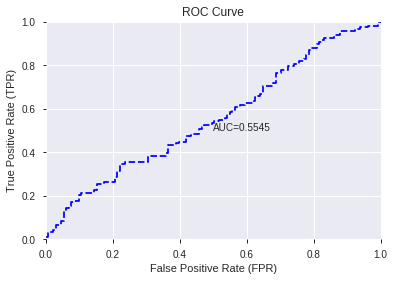

This function is available for GLM models only


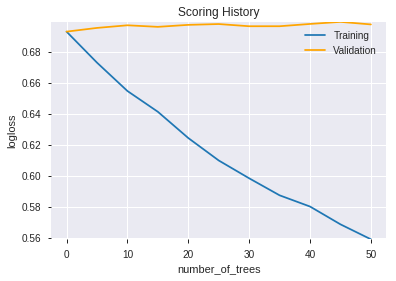

--2019-08-28 19:03:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_190329_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_190329_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BETA_14',
 'BETA_12',
 'ADX_8',
 'STOCHRSI_fastd',
 'CORREL_30',
 'BOP',
 'SIN',
 'ADXR_8',
 'SAREXT',
 'COS',
 'CORREL_24',
 'CORREL_14',
 'HT_DCPERIOD',
 'dayofyear',
 'day',
 'DX_12',
 'aroonup_20',
 'CORREL_20',
 'aroondown_14',
 'EXP',
 'CORREL_12',
 'aroondown_20',
 'BETA_8',
 'week',
 'dayofweek',
 'CORREL_8',
 'aroondown_8',
 'aroonup_14',
 'STOCHRSI_fastk',
 'aroonup_8',
 'weekday_name',
 'weekday',
 'month',
 'weekofyear',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI',
 'CDLSPINNINGTOP']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [895 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_190451_model_9  0.552141  0.690292              0.488970  0.498571  0.248573
1  DeepLearning_grid_1_AutoML_20190828_190451_model_3  0.528270  0.732550              0.500000  0.514718  0.264934
2  DeepLearning_grid_1_AutoML_20190828_190451_model_5  0.521025  0.698242              0.500000  0.502535  0.252542
3  DeepLearning_grid_1_AutoML_20190828_190451_model_7  0.515461  1.386773              0.485153  0.611481  0.373909
4  DeepLearning_grid_1_AutoML_20190828_190451_model_2  0.514814  0.709553              0.500000  0.507138  0.257189
5               DeepLearning_1_AutoML_20190828_190451  0.508604  0.774308              0.481757  0.531557  0.282553
6  DeepLearning_grid_1_AutoML_20190828_190451_model_1  0.500323  1.549117              0.500000  0.623209  0.388389
7  DeepLearning_grid_1_AutoML_20190828_190451_model_8  0.500000  0.697918              0.500000  0.502376  0.252382
8  DeepLearning_grid_1_AutoML_20190828_190451_model_6  0.488873  0.694928              0.475805  0.500889  0.250890
9  DeepLearning_grid_1_AutoML_20190828_190451_model_4  0.484151  0.961373              0.500000  0.569803  0.324675

variable  relative_importance  scaled_importance  percentage
0                    CDLTAKURI             1.000000           1.000000    0.001072
1                   AROONOSC_8             0.990500           0.990500    0.001062
2                   PLUS_DM_20             0.980089           0.980089    0.001051
3             CDLDRAGONFLYDOJI             0.976255           0.976255    0.001047
4                   aroonup_30             0.976166           0.976166    0.001047
...                        ...                  ...                ...         ...
1033    BBANDS_upperband_8_0_5             0.826869           0.826869    0.000887
1034  BBANDS_middleband_12_5_4             0.824745           0.824745    0.000884
1035               CDLMARUBOZU             0.822625           0.822625    0.000882
1036    BBANDS_upperband_8_6_5             0.818397           0.818397    0.000878
1037                   MA_12_5             0.810921           0.810921    0.000870

[1038 rows x 4 columns]

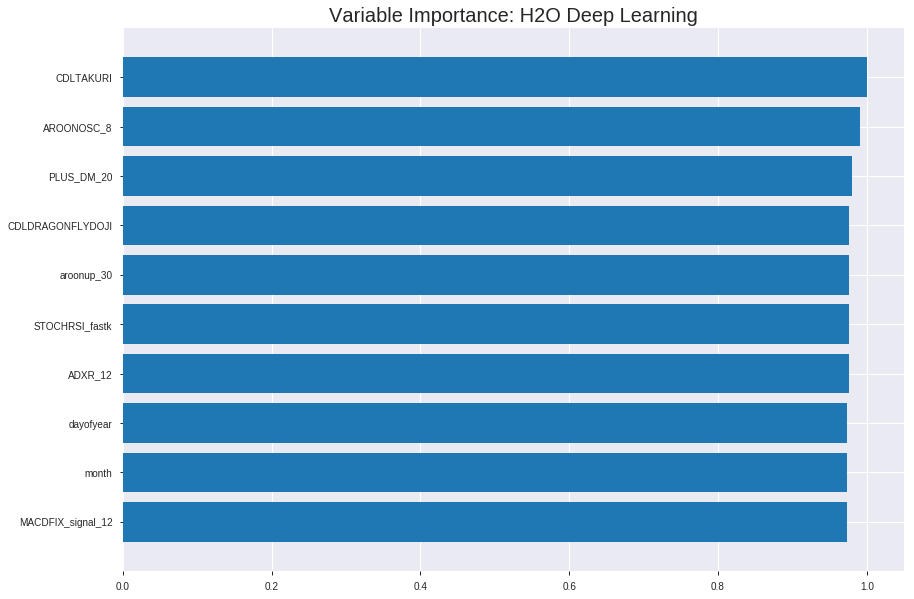

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_190451_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2486357902871397
RMSE: 0.4986339241238403
LogLoss: 0.6904146433798647
Mean Per-Class Error: 0.46636929317931797
AUC: 0.5352709549801135
pr_auc: 0.5451871058304086
Gini: 0.07054190996022691
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45962249447195264: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    828   0.9952   (828.0/832.0)
1      0    909   0        (0.0/909.0)
Total  4    1737  0.4756   (828.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.459622     0.687075   396
max f2                       0.459622     0.845896   396
max f0point5                 0.467249     0.579956   380
max accuracy                 0.486511     0.535325   297
max precision                0.587834     0.8        1
max recall                   0.459622     1          396
max specificity              0.588754     0.997596   0
max absolute_mcc             0.535497     0.0713437  145
max min_per_class_accuracy   0.514919     0.532452   212
max mean_per_class_accuracy  0.535497     0.533631   145

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 51.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.585042           1.38327   1.38327            0.722222         0.587445  0.722222                    0.587445            0.0143014       0.0143014                  38.3266   38.3266
    2        0.0201034                   0.577071           0.675985  1.03973            0.352941         0.580711  0.542857                    0.584174            0.00660066      0.0209021                  -32.4015  3.97297
    3        0.0304423                   0.575736           0.851241  0.975715           0.444444         0.576291  0.509434                    0.581497            0.00880088      0.029703                   -14.8759  -2.42854
    4        0.0402068                   0.575028           1.01398   0.985007           0.529412         0.575385  0.514286                    0.580013            0.00990099      0.039604                   1.39779   -1.49929
    5        0.0505457                   0.573785           0.957646  0.97941            0.5              0.574531  0.511364                    0.578891            0.00990099      0.049505                   -4.23542  -2.05896
    6        0.100517                    0.567193           1.21082   1.09445            0.632184         0.569533  0.571429                    0.574239            0.0605061       0.110011                   21.0816   9.44523
    7        0.150488                    0.560468           0.968653  1.05268            0.505747         0.563851  0.549618                    0.57079             0.0484048       0.158416                   -3.13468  5.26793
    8        0.20046                     0.556715           1.12276   1.07015            0.586207         0.558714  0.558739                    0.567779            0.0561056       0.214521                   12.2757   7.01486
    9        0.300402                    0.537525           1.16679   1.1023             0.609195         0.546354  0.575526                    0.560651            0.116612        0.331133                   16.6787   10.23
    10       0.400345                    0.529286           0.968653  1.06894            0.505747         0.533607  0.558106                    0.5539              0.0968097       0.427943                   -3.13468  6.8936
    11       0.500287                    0.515357           1.02369   1.0599             0.534483         0.523712  0.553387                    0.547869            0.10231         0.530253                   2.36903   5.98973
    12       0.60023                     0.496548           0.935631  1.03921            0.488506         0.505634  0.542584                    0.540837            0.0935094       0.623762                   -6.43691  3.9206
    13       0.700172                    0.485425           1.00168   1.03385            0.522989         0.490714  0.539787                    0.533682            0.10011         0.723872                   0.167545  3.38489
    14       0.800115                    0.478874           0.946638  1.02296            0.494253         0.481641  0.534099                    0.527182            0.0946095       0.818482                   -5.33617  2.29554
    15       0.900057                    0.472818           0.880594  1.00715            0.45977          0.475715  0.525846                    0.521467            0.0880088       0.906491                   -11.9406  0.714756
    16       1                           0.457955           0.935631  1                  0.488506         0.468795  0.522114                    0.516203         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2496758238402125
RMSE: 0.4996757186818392
LogLoss: 0.6924992061212949
Mean Per-Class Error: 0.4598393574297188
AUC: 0.5301366106998274
pr_auc: 0.5204703978652517
Gini: 0.06027322139965485
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48673912551705784: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   231  0.9277   (231.0/249.0)
1      8    241  0.0321   (8.0/249.0)
Total  26   472  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.486739     0.668516   377
max f2                       0.468181     0.833891   398
max f0point5                 0.486739     0.563875   377
max accuracy                 0.530812     0.540161   117
max precision                0.547207     0.666667   2
max recall                   0.468181     1          398
max specificity              0.553362     0.995984   0
max absolute_mcc             0.486739     0.0902698  377
max min_per_class_accuracy   0.524075     0.518072   184
max mean_per_class_accuracy  0.530812     0.540161   117

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.546053           0.8       0.8                0.4              0.548267  0.4                         0.548267            0.00803213      0.00803213                 -20       -20
    2        0.0200803                   0.544381           1.2       1                  0.6              0.545454  0.5                         0.54686             0.0120482       0.0200803                  20        0
    3        0.0301205                   0.542757           1.6       1.2                0.8              0.543932  0.6                         0.545884            0.0160643       0.0361446                  60        20
    4        0.0401606                   0.541331           1.2       1.2                0.6              0.542143  0.6                         0.544949            0.0120482       0.0481928                  20        20
    5        0.0502008                   0.540592           0.8       1.12               0.4              0.54096   0.56                        0.544151            0.00803213      0.0562249                  -20       12
    6        0.100402                    0.538119           1.12      1.12               0.56             0.539151  0.56                        0.541651            0.0562249       0.11245                    12        12
    7        0.150602                    0.536215           0.72      0.986667           0.36             0.53715   0.493333                    0.540151            0.0361446       0.148594                   -28       -1.33333
    8        0.200803                    0.534252           0.96      0.98               0.48             0.535233  0.49                        0.538921            0.0481928       0.196787                   -4        -2
    9        0.301205                    0.53119            1.36      1.10667            0.68             0.532447  0.553333                    0.536763            0.136546        0.333333                   36        10.6667
    10       0.399598                    0.528623           0.897959  1.05528            0.44898          0.529594  0.527638                    0.534998            0.0883534       0.421687                   -10.2041  5.52764
    11       0.5                         0.523731           0.96      1.03614            0.48             0.526917  0.518072                    0.533375            0.0963855       0.518072                   -4        3.61446
    12       0.600402                    0.514978           1.04      1.03679            0.52             0.519151  0.518395                    0.530997            0.104418        0.62249                    4         3.67893
    13       0.698795                    0.509579           1.02041   1.03448            0.510204         0.511818  0.517241                    0.528296            0.100402        0.722892                   2.04082   3.44828
    14       0.799197                    0.503367           0.96      1.02513            0.48             0.506387  0.512563                    0.525544            0.0963855       0.819277                   -4        2.51256
    15       0.899598                    0.495465           0.92      1.01339            0.46             0.49951   0.506696                    0.522638            0.0923695       0.911647                   -8        1.33929
    16       1                           0.465023           0.88      1                  0.44             0.485747  0.5                         0.518934            0.0883534       1              


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:21:48  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:21:49  4 min 14.443 sec  340 obs/sec       0.308443  1             537        0.600709         1.15224             -0.446234      0.483801        0.495123           0.957646         0.477312                         0.602334           1.10323               -0.451223        0.470242          0.481396             0.8                0.5
    2019-08-28 19:22:16  4 min 42.153 sec  293 obs/sec       4.31706   14            7516       0.498634         0.690415            0.00350763     0.535271        0.545187           1.38327          0.475589                         0.499676           0.692499              0.0012967        0.530137          0.52047              0.8                0.47992
    2019-08-28 19:22:54  5 min 19.641 sec  313 obs/sec       10.676    35            18587      0.499858         0.69286             -0.00139062    0.536731        0.55294            1.27686          0.476163                         0.499682           0.692511              0.00127144       0.525266          0.515716             1.6                0.495984
    2019-08-28 19:23:31  5 min 57.441 sec  340 obs/sec       18.2935   60            31849      0.499801         0.692752            -0.00116361    0.49945         0.000574231        0.999474         0.477886                         0.50153            0.696222              -0.00613069      0.5               0                    1                  0.5
    2019-08-28 19:24:09  6 min 34.750 sec  380 obs/sec       27.7898   91            48382      0.499347         0.691855            0.000657173    0.524657        0.548858           1.38327          0.477886                         0.500834           0.694821              -0.00334043      0.51725           0.521282             1.2                0.5
    2019-08-28 19:24:46  7 min 12.439 sec  412 obs/sec       38.1758   125           66464      0.499959         0.693066            -0.00179651    0.52431         0.552143           1.27686          0.477886                         0.499993           0.693132              2.98484e-05      0.502234          0.51169              1.6                0.5
    2019-08-28 19:25:23  7 min 49.050 sec  454 obs/sec       50.6623   166           88203      0.50124          0.695666            -0.00693643    0.5             0                  1                0.477886                         0.504043           0.701333              -0.0162387       0.5               0                    1                  0.5
    2019-08-28 19:25:27  7 min 52.770 sec  454 obs/sec       50.6623   166           88203      0.498634         0.690415            0.00350763     0.535271        0.545187           1.38327          0.475589                         0.499676           0.692499              0.0012967        0.530137          0.52047              0.8                0.47992

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLTAKURI                 1.0                    1.0                  0.0010722708444939615
AROONOSC_8                0.9904996752738953     0.9904996752738953   0.0010620839232769342
PLUS_DM_20                0.9800886511802673     0.9800886511802673   0.0010509204856800128
CDLDRAGONFLYDOJI          0.9762548804283142     0.9762548804283142   0.00104680964507822
aroonup_30                0.9761660695075989     0.9761660695075989   0.001046714415717264
---                       ---                    ---                  ---
BBANDS_upperband_8_0_5    0.8268690705299377     0.8268690705299377   0.0008866275965430734
BBANDS_middleband_12_5_4  0.8247446417808533     0.8247446417808533   0.0008843496335342253
CDLMARUBOZU               0.8226253390312195     0.8226253390312195   0.0008820771669851371
BBANDS_upperband_8_6_5    0.8183972835540771     0.8183972835540771   0.0008775435463680944
MA_12_5                   0.8109207153320312     0.8109207153320312   0.0008695266402467245


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5662650602409639)

('F1', 0.6464088397790054)

('auc', 0.5521412860654678)

('logloss', 0.6902919939339609)

('mean_per_class_error', 0.4464355026523483)

('rmse', 0.4985712736807057)

('mse', 0.24857331493960114)

deeplearning prediction progress: |███████████████████████████████████████| 100%


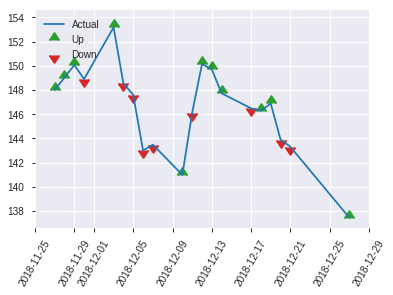


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24857331493960114
RMSE: 0.4985712736807057
LogLoss: 0.6902919939339609
Mean Per-Class Error: 0.4464355026523483
AUC: 0.5521412860654678
pr_auc: 0.530634829577806
Gini: 0.1042825721309355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4681833164356488: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    127  0.9695   (127.0/131.0)
1      1    117  0.0085   (1.0/118.0)
Total  5    244  0.5141   (128.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468183     0.646409  243
max f2                       0.461195     0.818308  248
max f0point5                 0.485456     0.543767  158
max accuracy                 0.505947     0.566265  33
max precision                0.519959     1         0
max recall                   0.461195     1         248
max specificity              0.519959     1         0
max absolute_mcc             0.505947     0.137911  33
max min_per_class_accuracy   0.489432     0.526718  124
max mean_per_class_accuracy  0.485456     0.553564  158

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.517868           2.11017   2.11017            1                0.518842  1                           0.518842            0.0254237       0.0254237                  111.017   111.017
    2        0.0200803                   0.515999           0         1.2661             0                0.517019  0.6                         0.518112            0               0.0254237                  -100      26.6102
    3        0.0321285                   0.514243           1.40678   1.31886            0.666667         0.515037  0.625                       0.516959            0.0169492       0.0423729                  40.678    31.8856
    4        0.0401606                   0.512695           2.11017   1.47712            1                0.513408  0.7                         0.516249            0.0169492       0.059322                   111.017   47.7119
    5        0.0522088                   0.51226            1.40678   1.46089            0.666667         0.512611  0.692308                    0.51541             0.0169492       0.0762712                  40.678    46.0887
    6        0.100402                    0.508267           1.05508   1.2661             0.5              0.510031  0.6                         0.512828            0.0508475       0.127119                   5.50847   26.6102
    7        0.15261                     0.505248           1.46089   1.33274            0.692308         0.506462  0.631579                    0.51065             0.0762712       0.20339                    46.0887   33.2739
    8        0.200803                    0.502663           0.527542  1.13949            0.25             0.503914  0.54                        0.509033            0.0254237       0.228814                   -47.2458  13.9492
    9        0.301205                    0.498725           0.928475  1.06915            0.44             0.500486  0.506667                    0.506184            0.0932203       0.322034                   -7.15254  6.91525
    10       0.401606                    0.495252           1.2661    1.11839            0.6              0.497172  0.53                        0.503931            0.127119        0.449153                   26.6102   11.839
    11       0.502008                    0.489432           0.844068  1.06353            0.4              0.492542  0.504                       0.501653            0.0847458       0.533898                   -15.5932  6.35254
    12       0.598394                    0.486327           0.967161  1.048              0.458333         0.487651  0.496644                    0.499398            0.0932203       0.627119                   -3.2839   4.80036
    13       0.698795                    0.483274           1.01288   1.04296            0.48             0.484957  0.494253                    0.497323            0.101695        0.728814                   1.28814   4.29573
    14       0.799197                    0.479691           1.01288   1.03918            0.48             0.481782  0.492462                    0.495371            0.101695        0.830508                   1.28814   3.91789
    15       0.899598                    0.475849           0.759661  1.00798            0.36             0.478323  0.477679                    0.493468            0.0762712       0.90678                    -24.0339  0.798275
    16       1                           0.461195           0.928475  1                  0.44             0.471716  0.473896                    0.491284         

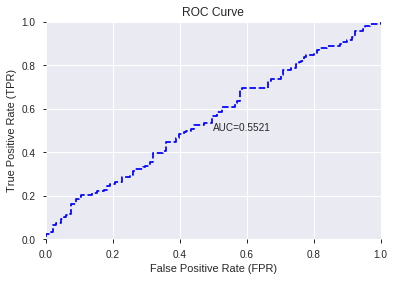

This function is available for GLM models only


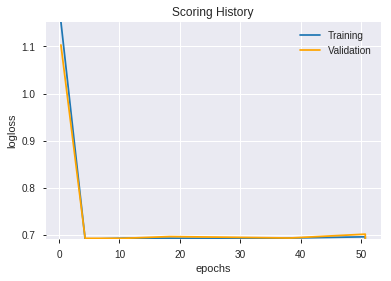

--2019-08-28 19:25:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_190451_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_190451_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLTAKURI',
 'AROONOSC_8',
 'PLUS_DM_20',
 'CDLDRAGONFLYDOJI',
 'aroonup_30',
 'STOCHRSI_fastk',
 'ADXR_12',
 'dayofyear',
 'month',
 'MACDFIX_signal_12',
 'VAR_14',
 'MACDFIX_hist_20',
 'AROONOSC_12',
 'STOCHF_fastk',
 'CDLEVENINGSTAR',
 'STDDEV_12',
 'MOM_24',
 'CDLDOJI',
 'WILLR_20',
 'CORREL_14',
 'aroonup_20',
 'BBANDS_middleband_20_7_3',
 'WILLR_12',
 'ADX_24',
 'ATR_8',
 'ROC_12',
 'BBANDS_middleband_24_2_3',
 'CDLHOMINGPIGEON',
 'aroonup_12',
 'AROONOSC_30',
 'BBANDS_upperband_20_5_2',
 'LINEARREG_ANGLE_8',
 'CORREL_12',
 'ROC_20',
 'AROONOSC_24',
 'LINEARREG_INTERCEPT_24',
 'DX_12',
 'BBANDS_upperband_12_6_2',
 'quarter',
 'CDLLONGLEGGEDDOJI',
 'week',
 'CORREL_30',
 'SQRT',
 'PLUS_DI_30',
 'STOCH_slowk',
 'MACDFIX_14',
 'MACDFIX_signal_8',
 'aroondown_8',
 'aroondown_30',
 'MA_24_2',
 'MINUS_DI_30',
 'AROONOSC_14',
 'CDLGRAVESTONEDOJI',
 'CDLSTICKSANDWICH',
 'MINUS_DM_14',
 'MOM_30',
 'BOP',
 'CCI_30',
 'BBANDS_middleband_24_2_2',
 'PLUS_DM_24',
 'MINUS_DI_14',
 'ATR_30',
 

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_192638_model_1  0.504722  0.693742                   0.5  0.500297  0.250297

variable  relative_importance  scaled_importance    percentage
0                    CORREL_24         7.824874e-03           1.000000  1.284358e-02
1                    CORREL_20         7.386193e-03           0.943938  1.212354e-02
2                   aroonup_20         7.154507e-03           0.914329  1.174326e-02
3               is_month_start         5.729064e-03           0.732161  9.403565e-03
4              CDLUNIQUE3RIVER         5.315109e-03           0.679258  8.724106e-03
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_24_2_3         9.840422e-07           0.000126  1.615186e-06
1034  BBANDS_middleband_30_7_5         9.759963e-07           0.000125  1.601980e-06
1035                    SUM_14         2.842229e-07           0.000036  4.665174e-07
1036                   MA_24_5         1.632889e-07           0.000021  2.680190e-07
1037                    WMA_24         0.000000e+00           0.000000  0.000000e+00

[1038 rows x 4 columns]

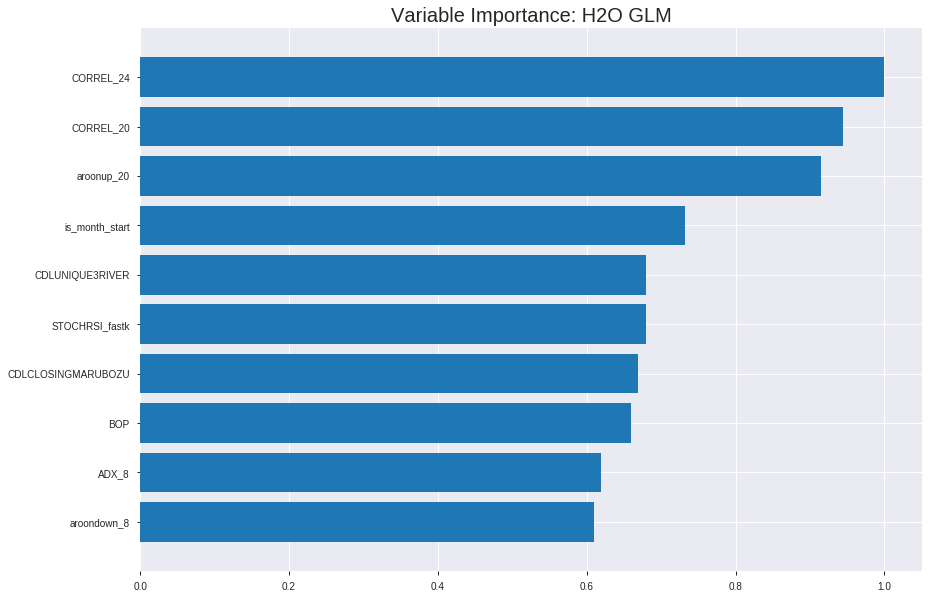

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_192638_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24598034942601113
RMSE: 0.4959640606193267
LogLoss: 0.6850674055033583
Null degrees of freedom: 1740
Residual degrees of freedom: 703
Null deviance: 2410.1318575316827
Residual deviance: 2385.4047059626932
AIC: 4461.404705962694
AUC: 0.5740405771346365
pr_auc: 0.5818446058850568
Gini: 0.14808115426927304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4231879756606848: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    824   0.9904   (824.0/832.0)
1      0    909   0        (0.0/909.0)
Total  8    1733  0.4733   (824.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423188     0.688115  391
max f2                       0.423188     0.846526  391
max f0point5                 0.503758     0.592275  245
max accuracy                 0.510676     0.566916  223
max precision                0.594734     0.857143  3
max recall                   0.423188     1         391
max specificity              0.597609     0.998798  0
max absolute_mcc             0.510676     0.126811  223
max min_per_class_accuracy   0.520185     0.550055  190
max mean_per_class_accuracy  0.510676     0.561282  223

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.590378           1.48967   1.48967            0.777778         0.594057  0.777778                    0.594057            0.0154015       0.0154015                  48.9671   48.9671
    2        0.0201034                   0.586961           1.23931   1.36807            0.647059         0.588117  0.714286                    0.591172            0.0121012       0.0275028                  23.9306   36.8065
    3        0.0304423                   0.583999           1.27686   1.33709            0.666667         0.585376  0.698113                    0.589204            0.0132013       0.0407041                  27.6861   33.709
    4        0.0402068                   0.582175           1.12664   1.28598            0.588235         0.582901  0.671429                    0.587673            0.0110011       0.0517052                  12.6642   28.5981
    5        0.0505457                   0.579849           1.06405   1.24059            0.555556         0.581075  0.647727                    0.586323            0.0110011       0.0627063                  6.40508   24.0587
    6        0.100517                    0.573364           1.12276   1.18201            0.586207         0.576342  0.617143                    0.581361            0.0561056       0.118812                   12.2757   18.2008
    7        0.150488                    0.568064           1.14477   1.16964            0.597701         0.570623  0.610687                    0.577796            0.0572057       0.176018                   14.4772   16.9644
    8        0.20046                     0.561229           1.05671   1.14149            0.551724         0.564688  0.595989                    0.574528            0.0528053       0.228823                   5.67126   14.1492
    9        0.300402                    0.538118           1.08973   1.12427            0.568966         0.549975  0.586998                    0.566359            0.108911        0.337734                   8.97348   12.4272
    10       0.400345                    0.527568           1.06772   1.11015            0.557471         0.532187  0.579627                    0.557829            0.106711        0.444444                   6.772     11.0155
    11       0.500287                    0.520059           1.06772   1.10168            0.557471         0.52397   0.575201                    0.551065            0.106711        0.551155                   6.772     10.1677
    12       0.60023                     0.512428           1.01268   1.08686            0.528736         0.516394  0.567464                    0.545292            0.10121         0.652365                   1.26829   8.68592
    13       0.700172                    0.504334           0.979661  1.07156            0.511494         0.508813  0.559475                    0.540085            0.0979098       0.750275                   -2.03394  7.15577
    14       0.800115                    0.493119           0.891601  1.04908            0.465517         0.498723  0.547739                    0.534918            0.0891089       0.839384                   -10.8399  4.90793
    15       0.900057                    0.478954           0.880594  1.03037            0.45977          0.486452  0.537971                    0.529537            0.0880088       0.927393                   -11.9406  3.03706
    16       1                           0.372757           0.72649   1                  0.37931          0.455266  0.522114                    0.522114          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2501524726746872
RMSE: 0.5001524494338573
LogLoss: 0.6934532082684123
Null degrees of freedom: 497
Residual degrees of freedom: -540
Null deviance: 691.349667579769
Residual deviance: 690.6793954353386
AIC: 2766.679395435339
AUC: 0.5305559587748584
pr_auc: 0.5237951024284941
Gini: 0.06111191754971679
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49081555340443733: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    245  0.9839   (245.0/249.0)
1      0    249  0        (0.0/249.0)
Total  4    494  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.490816     0.670256   395
max f2                       0.490816     0.83557    395
max f0point5                 0.511801     0.567216   343
max accuracy                 0.521301     0.536145   267
max precision                0.573716     1          0
max recall                   0.490816     1          395
max specificity              0.573716     1          0
max absolute_mcc             0.511801     0.0986978  343
max min_per_class_accuracy   0.52914      0.518072   201
max mean_per_class_accuracy  0.521301     0.536145   267

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.94 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100402                   0.564935           1.6      1.6                0.8              0.569172  0.8                         0.569172            0.0160643       0.0160643                  60       60
    2        0.0200803                   0.562176           0.8      1.2                0.4              0.563662  0.6                         0.566417            0.00803213      0.0240964                  -20      20
    3        0.0301205                   0.559666           0.8      1.06667            0.4              0.560939  0.533333                    0.564591            0.00803213      0.0321285                  -20      6.66667
    4        0.0401606                   0.55824            1.2      1.1                0.6              0.559142  0.55                        0.563229            0.0120482       0.0441767                  20       10
    5        0.0502008                   0.556674           1.2      1.12               0.6              0.557469  0.56                        0.562077            0.0120482       0.0562249                  20       12
    6        0.100402                    0.550434           1.2      1.16               0.6              0.553514  0.58                        0.557795            0.060241        0.116466                   20       16
    7        0.150602                    0.546318           0.96     1.09333            0.48             0.548368  0.546667                    0.554653            0.0481928       0.164659                   -4       9.33333
    8        0.200803                    0.542554           0.88     1.04               0.44             0.544397  0.52                        0.552089            0.0441767       0.208835                   -12      4
    9        0.301205                    0.537772           1        1.02667            0.5              0.539869  0.513333                    0.548015            0.100402        0.309237                   0        2.66667
    10       0.399598                    0.533037           1.06122  1.03518            0.530612         0.535541  0.517588                    0.544944            0.104418        0.413655                   6.12245  3.51759
    11       0.5                         0.529105           1.04     1.03614            0.52             0.531373  0.518072                    0.542219            0.104418        0.518072                   4        3.61446
    12       0.600402                    0.525014           0.96     1.02341            0.48             0.526968  0.511706                    0.539668            0.0963855       0.614458                   -4       2.34114
    13       0.698795                    0.520794           1.06122  1.02874            0.530612         0.522735  0.514368                    0.537284            0.104418        0.718876                   6.12245  2.87356
    14       0.799197                    0.515382           1.08     1.03518            0.54             0.518099  0.517588                    0.534874            0.108434        0.827309                   8        3.51759
    15       0.899598                    0.510665           0.92     1.02232            0.46             0.513149  0.511161                    0.532449            0.0923695       0.919679                   -8       2.23214
    16       1                           0.485883           0.8      1                  0.4              0.501694  0.5                         0.529361            0.0803213       1                          -20      0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 19:26:41  0.000 sec   2            3.6       1038          1.37013           1.38691
    2019-08-28 19:26:42  1.775 sec   4            2.6       1038          1.36756           1.38717
    2019-08-28 19:26:44  3.554 sec   6            1.9       1039          1.36452           1.38762
    2019-08-28 19:26:46  5.337 sec   8            1.4       1039          1.36103           1.38827
    2019-08-28 19:26:48  7.177 sec   10           1         1039          1.35707           1.38921
    2019-08-28 19:26:50  9.072 sec   12           0.73      1039          1.35271           1.39052

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5421686746987951)

('F1', 0.6430517711171662)

('auc', 0.5047224737999741)

('logloss', 0.6937417494716601)

('mean_per_class_error', 0.4730236770604218)

('rmse', 0.5002970923382706)

('mse', 0.250297180602128)

glm prediction progress: |████████████████████████████████████████████████| 100%


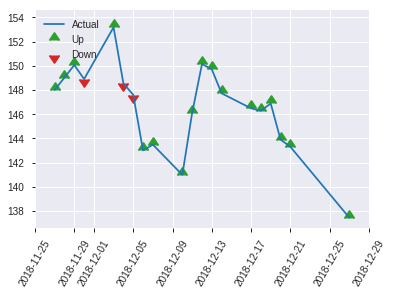


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.250297180602128
RMSE: 0.5002970923382706
LogLoss: 0.6937417494716601
Null degrees of freedom: 248
Residual degrees of freedom: -789
Null deviance: 346.8254982835162
Residual deviance: 345.48339123688675
AIC: 2421.4833912368867
AUC: 0.5047224737999741
pr_auc: 0.49128929093480206
Gini: 0.009444947599948295
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.462471535766668: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462472     0.643052  248
max f2                       0.462472     0.818308  248
max f0point5                 0.485839     0.533199  218
max accuracy                 0.532585     0.542169  5
max precision                0.543758     1         0
max recall                   0.462472     1         248
max specificity              0.543758     1         0
max absolute_mcc             0.539239     0.116356  2
max min_per_class_accuracy   0.503336     0.5       123
max mean_per_class_accuracy  0.508607     0.526976  89

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 50.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.537596           2.11017   2.11017            1                0.541114  1                           0.541114            0.0254237       0.0254237                  111.017   111.017
    2        0.0200803                   0.532639           1.05508   1.68814            0.5              0.534887  0.8                         0.538623            0.00847458      0.0338983                  5.50847   68.8136
    3        0.0321285                   0.529553           0.70339   1.31886            0.333333         0.530987  0.625                       0.535759            0.00847458      0.0423729                  -29.661   31.8856
    4        0.0401606                   0.529403           0         1.05508            0                0.529497  0.5                         0.534507            0               0.0423729                  -100      5.50847
    5        0.0522088                   0.52719            1.40678   1.13625            0.666667         0.528454  0.538462                    0.53311             0.0169492       0.059322                   40.678    13.6245
    6        0.100402                    0.523412           0.879237  1.01288            0.416667         0.525481  0.48                        0.529448            0.0423729       0.101695                   -12.0763  1.28814
    7        0.15261                     0.518291           0.973924  0.999554           0.461538         0.520534  0.473684                    0.526399            0.0508475       0.152542                   -2.60756  -0.044603
    8        0.200803                    0.51545            1.05508   1.01288            0.5              0.516903  0.48                        0.52412             0.0508475       0.20339                    5.50847   1.28814
    9        0.301205                    0.511013           0.928475  0.984746           0.44             0.513507  0.466667                    0.520582            0.0932203       0.29661                    -7.15254  -1.52542
    10       0.401606                    0.507208           1.18169   1.03398            0.56             0.50888   0.49                        0.517657            0.118644        0.415254                   18.1695   3.39831
    11       0.502008                    0.503258           0.844068  0.996              0.4              0.504982  0.472                       0.515122            0.0847458       0.5                        -15.5932  -0.4
    12       0.598394                    0.500035           0.791314  0.96303            0.375            0.50157   0.456376                    0.512939            0.0762712       0.576271                   -20.8686  -3.69696
    13       0.698795                    0.495963           1.2661    1.00658            0.6              0.497869  0.477011                    0.510774            0.127119        0.70339                    26.6102   0.65751
    14       0.799197                    0.491096           1.09729   1.01797            0.52             0.493731  0.482412                    0.508633            0.110169        0.813559                   9.72881   1.79712
    15       0.899598                    0.48482            0.844068  0.998562           0.4              0.487969  0.473214                    0.506326            0.0847458       0.898305                   -15.5932  -0.143765
    16       1                           0.462472           1.01288   1                  0.48             0.475609  0.473896                    0.503242      

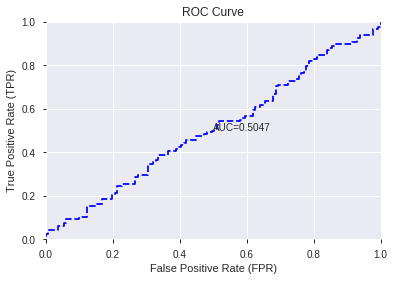

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


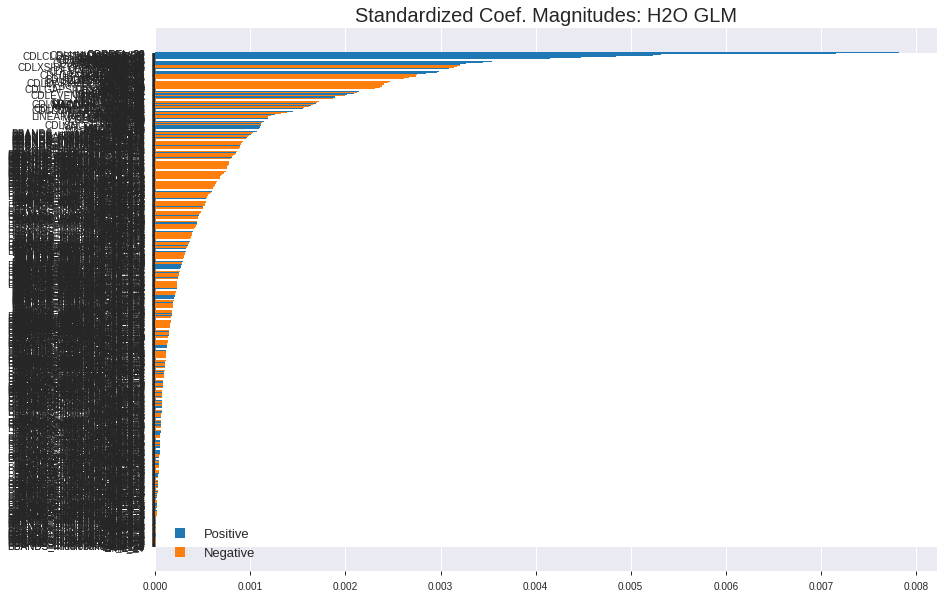

'log_likelihood'
--2019-08-28 19:27:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_192638_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_192638_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CORREL_24',
 'CORREL_20',
 'aroonup_20',
 'is_month_start',
 'CDLUNIQUE3RIVER',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'BOP',
 'ADX_8',
 'aroondown_8',
 'CDLLONGLINE',
 'aroonup_8',
 'CDLSPINNINGTOP',
 'CORREL_12',
 'CDLDOJISTAR',
 'CDLHIKKAKEMOD',
 'aroondown_14',
 'HT_DCPERIOD',
 'CDL3INSIDE',
 'AROONOSC_20',
 'CDLEVENINGSTAR',
 'STOCHF_fastk',
 'CDLINNECK',
 'weekofyear',
 'week',
 'WILLR_12',
 'CORREL_14',
 'is_month_end',
 'ADXR_8',
 'PLUS_DM_30',
 'CDLXSIDEGAP3METHODS',
 'ATR_30',
 'SAREXT',
 'CDLMARUBOZU',
 'ATR_24',
 'EXP',
 'SINH',
 'COSH',
 'CDLMATCHINGLOW',
 'quarter',
 'CDL2CROWS',
 'ATR_20',
 'aroonup_14',
 'PLUS_DM_24',
 'aroonup_12',
 'CDLDRAGONFLYDOJI',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'HT_TRENDMODE',
 'ROC_14',
 'aroondown_24',
 'ATR_14',
 'WILLR_14',
 'PLUS_DM_20',
 'CDLHOMINGPIGEON',
 'CDLHIGHWAVE',
 'CDLTHRUSTING',
 'ADX_12',
 'dayofyear',
 'Volume',
 'ATR_12',
 'CDLDARKCLOUDCOVER',
 'MFI_14',
 'HT_PHASOR_inphase',
 'TAN',
 'month',
 'NATR_24',
 'ROCR10

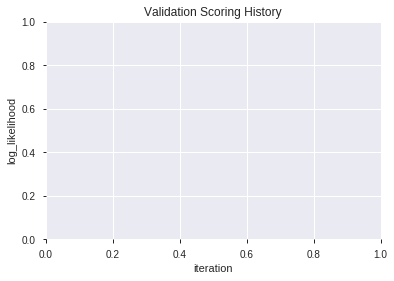

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_192811_model_5  0.525747  0.730023              0.500000  0.514618  0.264832
1               XGBoost_1_AutoML_20190828_192811  0.514038  0.704658              0.472409  0.505524  0.255555
2  XGBoost_grid_1_AutoML_20190828_192811_model_4  0.503170  0.701419              0.482598  0.504033  0.254049
3  XGBoost_grid_1_AutoML_20190828_192811_model_6  0.500582  0.705113              0.496183  0.505743  0.255776
4  XGBoost_grid_1_AutoML_20190828_192811_model_2  0.493660  0.705546              0.500000  0.505945  0.255980
5  XGBoost_grid_1_AutoML_20190828_192811_model_7  0.490684  0.725538              0.500000  0.514858  0.265079
6               XGBoost_3_AutoML_20190828_192811  0.486868  0.706132              0.496183  0.506300  0.256340
7  XGBoost_grid_1_AutoML_20190828_192811_model_3  0.485444  0.709359              0.496183  0.507920  0.257982
8  XGBoost_grid_1_AutoML_20190828_192811_model_1  0.473412  0.709870              0.500000  0.508078  0.258143
9               XGBoost_2_AutoML_20190828_192811  0.438220  0.730425              0.500000  0.517607  0.267917

variable  relative_importance  scaled_importance  percentage
0                     Volume           412.958160           1.000000    0.017256
1                        day           408.238190           0.988570    0.017059
2                        BOP           342.167511           0.828577    0.014298
3                       Open           332.415070           0.804961    0.013891
4                  dayofyear           321.142822           0.777664    0.013420
..                       ...                  ...                ...         ...
605  BBANDS_upperband_12_4_4             1.144448           0.002771    0.000048
606  BBANDS_upperband_20_1_2             0.897154           0.002173    0.000037
607  BBANDS_lowerband_24_3_2             0.838680           0.002031    0.000035
608                   T3_8_3             0.606011           0.001467    0.000025
609                   MA_8_0             0.478077           0.001158    0.000020

[610 rows x 4 columns]

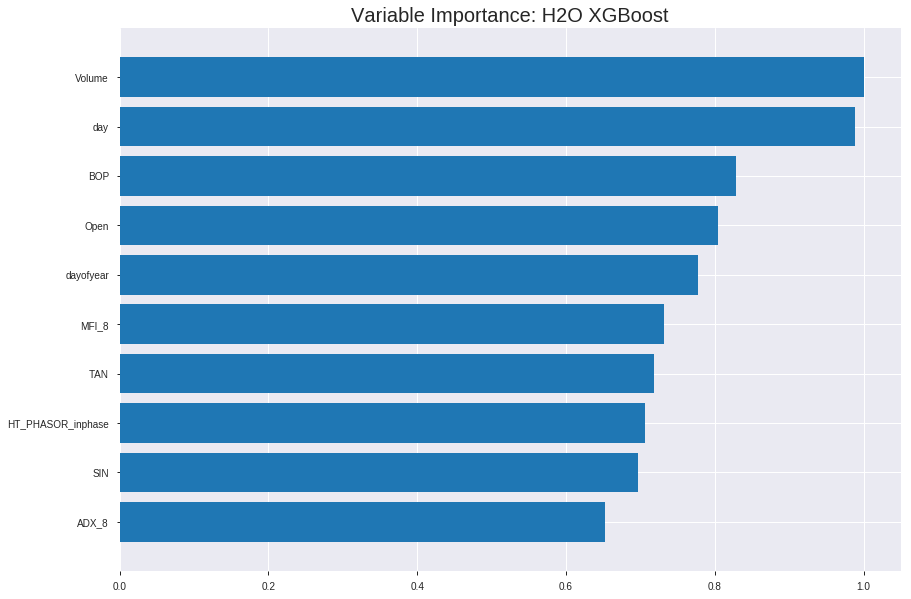

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_192811_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03906561168490988
RMSE: 0.1976502256131014
LogLoss: 0.2102267195488593
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988998899889988
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5857982039451599: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      832  0    0        (0.0/832.0)
1      0    909  0        (0.0/909.0)
Total  832  909  0        (0.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.585798     1        198
max f2                       0.585798     1        198
max f0point5                 0.585798     1        198
max accuracy                 0.585798     1        198
max precision                0.940355     1        0
max recall                   0.585798     1        198
max specificity              0.940355     1        0
max absolute_mcc             0.585798     1        198
max min_per_class_accuracy   0.585798     1        198
max mean_per_class_accuracy  0.585798     1        198

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.916281           1.91529   1.91529            1                0.922936  1                           0.922936            0.019802        0.019802                   91.5292   91.5292
    2        0.0201034                   0.907407           1.91529   1.91529            1                0.911764  1                           0.917509            0.0187019       0.0385039                  91.5292   91.5292
    3        0.0304423                   0.901797           1.91529   1.91529            1                0.904836  1                           0.913205            0.019802        0.0583058                  91.5292   91.5292
    4        0.0402068                   0.896574           1.91529   1.91529            1                0.898752  1                           0.909695            0.0187019       0.0770077                  91.5292   91.5292
    5        0.0505457                   0.891896           1.91529   1.91529            1                0.893809  1                           0.906446            0.019802        0.0968097                  91.5292   91.5292
    6        0.100517                    0.875422           1.91529   1.91529            1                0.883452  1                           0.895014            0.0957096       0.192519                   91.5292   91.5292
    7        0.150488                    0.860125           1.91529   1.91529            1                0.867657  1                           0.88593             0.0957096       0.288229                   91.5292   91.5292
    8        0.20046                     0.848737           1.91529   1.91529            1                0.854493  1                           0.878093            0.0957096       0.383938                   91.5292   91.5292
    9        0.300402                    0.817369           1.91529   1.91529            1                0.831968  1                           0.862748            0.191419        0.575358                   91.5292   91.5292
    10       0.400345                    0.780328           1.91529   1.91529            1                0.798674  1                           0.846752            0.191419        0.766777                   91.5292   91.5292
    11       0.500287                    0.702444           1.91529   1.91529            1                0.749489  1                           0.827322            0.191419        0.958196                   91.5292   91.5292
    12       0.60023                     0.261719           0.418282  1.66603            0.218391         0.385675  0.869856                    0.753785            0.0418042       1                          -58.1718  66.6029
    13       0.700172                    0.21047            0         1.42822            0                0.233827  0.745693                    0.679566            0               1                          -100      42.822
    14       0.800115                    0.172212           0         1.24982            0                0.19034   0.652548                    0.618456            0               1                          -100      24.9821
    15       0.900057                    0.139177           0         1.11104            0                0.155394  0.580089                    0.567038            0               1                          -100      11.104
    16       1                           0.0653604          0         1                  0                0.114406  0.522114                    0.521801           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26581392350628946
RMSE: 0.5155714533469531
LogLoss: 0.7278696098978699
Mean Per-Class Error: 0.47791164658634544
AUC: 0.5089353397525846
pr_auc: 0.5090227554478849
Gini: 0.017870679505169296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2752348482608795: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    240  0.9639   (240.0/249.0)
1      3    246  0.012    (3.0/249.0)
Total  12   486  0.488    (243.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.275235     0.669388   387
max f2                       0.149544     0.833333   399
max f0point5                 0.275235     0.560876   387
max accuracy                 0.677065     0.522088   67
max precision                0.841126     1          0
max recall                   0.149544     1          399
max specificity              0.841126     1          0
max absolute_mcc             0.275235     0.0785674  387
max min_per_class_accuracy   0.53177      0.514056   200
max mean_per_class_accuracy  0.677065     0.522088   67

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.794254           0.8       0.8                0.4              0.815008  0.4                         0.815008            0.00803213      0.00803213                 -20       -20
    2        0.0200803                   0.777037           1.6       1.2                0.8              0.786891  0.6                         0.80095             0.0160643       0.0240964                  60        20
    3        0.0301205                   0.758036           0.8       1.06667            0.4              0.766493  0.533333                    0.789464            0.00803213      0.0321285                  -20       6.66667
    4        0.0401606                   0.747162           1.2       1.1                0.6              0.752072  0.55                        0.780116            0.0120482       0.0441767                  20        10
    5        0.0502008                   0.735511           0.8       1.04               0.4              0.743227  0.52                        0.772738            0.00803213      0.0522088                  -20       4
    6        0.100402                    0.698246           1.36      1.2                0.68             0.71296   0.6                         0.742849            0.0682731       0.120482                   36        20
    7        0.150602                    0.67579            1.04      1.14667            0.52             0.686232  0.573333                    0.723977            0.0522088       0.172691                   4         14.6667
    8        0.200803                    0.656484           0.72      1.04               0.36             0.66658   0.52                        0.709628            0.0361446       0.208835                   -28       4
    9        0.301205                    0.61387            0.8       0.96               0.4              0.633971  0.48                        0.684409            0.0803213       0.289157                   -20       -4
    10       0.399598                    0.569047           1.10204   0.994975           0.55102          0.591099  0.497487                    0.661433            0.108434        0.39759                    10.2041   -0.502513
    11       0.5                         0.531292           1.16      1.02811            0.58             0.548757  0.514056                    0.638807            0.116466        0.514056                   16        2.81124
    12       0.600402                    0.491922           0.96      1.01672            0.48             0.510774  0.508361                    0.617397            0.0963855       0.610442                   -4        1.67224
    13       0.698795                    0.460685           0.897959  1                  0.44898          0.4758    0.5                         0.59746             0.0883534       0.698795                   -10.2041  0
    14       0.799197                    0.413622           0.96      0.994975           0.48             0.439092  0.497487                    0.577564            0.0963855       0.795181                   -4        -0.502513
    15       0.899598                    0.350499           1.12      1.00893            0.56             0.384612  0.504464                    0.556029            0.11245         0.907631                   12        0.892857
    16       1                           0.149544           0.92      1                  0.46             0.292976  0.5                         0.529618            0.0923695       1                 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:28:44  16.767 sec  0                  0.5              0.693147            0.5             0                  1                0.477886                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-28 19:28:46  18.385 sec  5                  0.445941         0.589988            0.97103         0.971807           1.91529          0.0844342                        0.5004             0.693965              0.519838          0.51233              1.33333            0.497992
    2019-08-28 19:28:47  19.187 sec  10                 0.399813         0.50874             0.99356         0.992009           1.91529          0.0333142                        0.50132            0.695854              0.517371          0.506855             0.8                0.473896
    2019-08-28 19:28:48  19.976 sec  15                 0.361378         0.445202            0.99812         0.997224           1.91529          0.0172315                        0.503273           0.699848              0.514169          0.521512             1.2                0.495984
    2019-08-28 19:28:49  20.847 sec  20                 0.324819         0.387915            0.999593        0.998541           1.91529          0.00746697                       0.504444           0.702484              0.519992          0.51873              1.6                0.497992
    2019-08-28 19:28:49  21.687 sec  25                 0.294219         0.342263            0.999887        0.998797           1.91529          0.00459506                       0.506027           0.705772              0.514919          0.523793             1.6                0.487952
    2019-08-28 19:28:50  22.418 sec  30                 0.272601         0.310945            0.999939        0.998845           1.91529          0.0034463                        0.507736           0.709642              0.516411          0.517038             1.6                0.495984
    2019-08-28 19:28:51  23.147 sec  35                 0.253113         0.283696            0.999988        0.998889           1.91529          0.00114877                       0.508118           0.710448              0.51758           0.522799             1.6                0.483936
    2019-08-28 19:28:52  23.942 sec  40                 0.232492         0.255624            0.999995        0.998895           1.91529          0.00114877                       0.508879           0.712376              0.523233          0.52686              1.2                0.491968
    2019-08-28 19:28:52  24.760 sec  45                 0.217035         0.235153            1               0.9989             1.91529          0                                0.511225           0.717659              0.518314          0.521062             1.6                0.485944
    2019-08-28 19:28:53  25.584 sec  50                 0.19765          0.210227            1               0.9989             1.91529          0                                0.515571           0.72787               0.508935          0.509023             0.8                0.487952

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
Volume                   412.9581604003906      1.0                    0.017256356178014954
day                      408.2381896972656      0.988570341609066      0.017059121921827958
BOP                      342.1675109863281      0.8285767029148274     0.014298214706303543
Open                     332.4150695800781      0.8049606508750897     0.013890687700787292
dayofyear                321.142822265625       0.7776643085446127     0.013419652295175553
---                      ---                    ---                    ---
BBANDS_upperband_12_4_4  1.1444475650787354     0.002771340234490382   4.782323417682952e-05
BBANDS_upperband_20_1_2  0.8971541523933411     0.0021725061723528844  3.7489540309057315e-05
BBANDS_lowerband_24_3_2  0.8386795520782471     0.0020309068387584133  3.504605177398156e-05
T3_8_3                   0.6060110330581665     0.001467487729194159   2.532349094184076e-05
MA_8_0                   0.4780771732330322     0.0011576891294980208  1.9977495962033922e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5461847389558233)

('F1', 0.6430517711171662)

('auc', 0.5257471859231466)

('logloss', 0.730022604440187)

('mean_per_class_error', 0.4460473541208436)

('rmse', 0.5146178488151567)

('mse', 0.2648315303191395)

xgboost prediction progress: |████████████████████████████████████████████| 100%


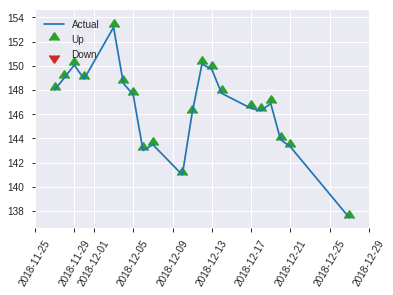


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2648315303191395
RMSE: 0.5146178488151567
LogLoss: 0.730022604440187
Mean Per-Class Error: 0.4460473541208436
AUC: 0.5257471859231466
pr_auc: 0.4704776022432754
Gini: 0.05149437184629324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15812699496746063: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.158127     0.643052  248
max f2                       0.158127     0.818308  248
max f0point5                 0.407098     0.548926  179
max accuracy                 0.47258      0.546185  134
max precision                0.47258      0.518519  134
max recall                   0.158127     1         248
max specificity              0.875789     0.992366  0
max absolute_mcc             0.76395      0.127308  7
max min_per_class_accuracy   0.487527     0.534351  124
max mean_per_class_accuracy  0.407098     0.553953  179

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.831016           0         0                  0                0.855725  0                           0.855725            0               0                          -100      -100
    2        0.0200803                   0.818113           1.05508   0.422034           0.5              0.820906  0.2                         0.841797            0.00847458      0.00847458                 5.50847   -57.7966
    3        0.0321285                   0.761172           0         0.263771           0                0.793193  0.125                       0.823571            0               0.00847458                 -100      -73.6229
    4        0.0401606                   0.746708           2.11017   0.633051           1                0.754069  0.3                         0.80967             0.0169492       0.0254237                  111.017   -36.6949
    5        0.0522088                   0.722865           1.40678   0.811604           0.666667         0.739121  0.384615                    0.79339             0.0169492       0.0423729                  40.678    -18.8396
    6        0.100402                    0.651672           1.05508   0.928475           0.5              0.675338  0.44                        0.736725            0.0508475       0.0932203                  5.50847   -7.15254
    7        0.15261                     0.63467            0.973924  0.944023           0.461538         0.643341  0.447368                    0.704778            0.0508475       0.144068                   -2.60756  -5.59768
    8        0.200803                    0.608253           1.05508   0.970678           0.5              0.616615  0.46                        0.683618            0.0508475       0.194915                   5.50847   -2.9322
    9        0.301205                    0.55908            0.759661  0.900339           0.36             0.584025  0.426667                    0.650421            0.0762712       0.271186                   -24.0339  -9.9661
    10       0.401606                    0.523401           1.51932   1.05508            0.72             0.539024  0.5                         0.622571            0.152542        0.423729                   51.9322   5.50847
    11       0.502008                    0.487527           1.18169   1.08041            0.56             0.505963  0.512                       0.59925             0.118644        0.542373                   18.1695   8.04068
    12       0.598394                    0.445512           1.05508   1.07633            0.5              0.470528  0.510067                    0.578516            0.101695        0.644068                   5.50847   7.63281
    13       0.698795                    0.415286           1.01288   1.06721            0.48             0.431126  0.505747                    0.557339            0.101695        0.745763                   1.28814   6.72122
    14       0.799197                    0.380463           0.928475  1.04978            0.44             0.397706  0.497487                    0.537285            0.0932203       0.838983                   -7.15254  4.97828
    15       0.899598                    0.320854           0.675254  1.00798            0.32             0.355592  0.477679                    0.517007            0.0677966       0.90678                    -32.4746  0.798275
    16       1                           0.158127           0.928475  1                  0.44             0.286317  0.473896                    0.493845     

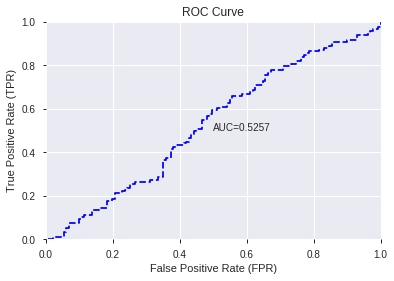

This function is available for GLM models only


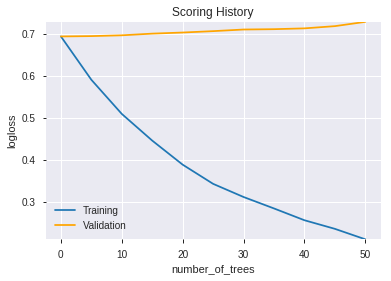

--2019-08-28 19:29:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.98.120
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.98.120|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_192811_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_192811_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'day',
 'BOP',
 'Open',
 'dayofyear',
 'MFI_8',
 'TAN',
 'HT_PHASOR_inphase',
 'SIN',
 'ADX_8',
 'HT_PHASOR_quadrature',
 'COS',
 'CORREL_8',
 'CORREL_20',
 'dayofweek',
 'STOCHF_fastk',
 'DX_8',
 'ULTOSC',
 'CCI_8',
 'SUB',
 'CORREL_12',
 'TRANGE',
 'BETA_12',
 'HT_DCPERIOD',
 'BETA_8',
 'BETA_14',
 'DIV',
 'MACDEXT_hist',
 'High',
 'MFI_12',
 'STOCH_slowk',
 'SAREXT',
 'BETA_24',
 'PLUS_DI_8',
 'STOCH_slowd',
 'CORREL_24',
 'Low',
 'ADXR_8',
 'BETA_20',
 'DX_14',
 'ADXR_12',
 'WILLR_8',
 'MOM_8',
 'OBV',
 'CMO_8',
 'ROC_14',
 'CORREL_14',
 'MOM_12',
 'STDDEV_12',
 'MFI_24',
 'weekday_name',
 'ADOSC',
 'DX_20',
 'MINUS_DI_8',
 'ADX_20',
 'PLUS_DM_8',
 'PLUS_DM_20',
 'Close',
 'DX_12',
 'LINEARREG_ANGLE_12',
 'aroondown_8',
 'MOM_20',
 'TRIX_8',
 'ADX_12',
 'aroondown_12',
 'ROC_20',
 'MINUS_DI_12',
 'BETA_30',
 'STDDEV_8',
 'MFI_30',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_12',
 'MACDFIX_hist_14',
 'CORREL_30',
 'ADXR_14',
 'MFI_14',
 'MFI_20',
 'WILLR_12',
 'APO',
 'ROC_24',
 'MA

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

524

['BBANDS_lowerband_12_3_2',
 'BBANDS_upperband_12_3_3',
 'BBANDS_middleband_12_3_3',
 'BBANDS_lowerband_12_3_3',
 'BBANDS_upperband_12_3_4',
 'BBANDS_middleband_12_3_4',
 'BBANDS_lowerband_12_3_4',
 'BBANDS_upperband_12_3_5',
 'BBANDS_middleband_12_3_5',
 'BBANDS_lowerband_12_3_5',
 'MA_12_4',
 'MAVP_12_4',
 'BBANDS_upperband_12_4_2',
 'BBANDS_middleband_12_4_2',
 'BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowe

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_193108_model_5  0.529564  0.701048              0.500000  0.503924  0.253940
1               DeepLearning_1_AutoML_20190828_193108  0.528626  0.803520              0.496183  0.527375  0.278124
2  DeepLearning_grid_1_AutoML_20190828_193108_model_4  0.515914  1.065145              0.500000  0.583567  0.340551
3  DeepLearning_grid_1_AutoML_20190828_193108_model_9  0.515591  0.691777              0.500000  0.499314  0.249315
4  DeepLearning_grid_1_AutoML_20190828_193108_model_8  0.500000  0.697032              0.500000  0.501937  0.251941
5  DeepLearning_grid_1_AutoML_20190828_193108_model_2  0.493337  0.717194              0.500000  0.510699  0.260814
6  DeepLearning_grid_1_AutoML_20190828_193108_model_3  0.490555  0.723363              0.500000  0.513829  0.264020
7  DeepLearning_grid_1_AutoML_20190828_193108_model_6  0.485024  0.695207              0.500000  0.501014  0.251015
8  DeepLearning_grid_1_AutoML_20190828_193108_model_7  0.478328  0.795653              0.492366  0.530693  0.281635
9  DeepLearning_grid_1_AutoML_20190828_193108_model_1  0.460409  1.933367              0.500000  0.674577  0.455055

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.002409
1                       ADX_8             0.985886           0.985886    0.002375
2                   CORREL_12             0.950748           0.950748    0.002291
3                       DX_14             0.932092           0.932092    0.002246
4                      ADXR_8             0.931034           0.931034    0.002243
..                        ...                  ...                ...         ...
518                   MA_14_2             0.719075           0.719075    0.001733
519  BBANDS_middleband_14_0_4             0.717036           0.717036    0.001728
520                    SMA_14             0.711540           0.711540    0.001714
521    LINEARREG_INTERCEPT_12             0.711138           0.711138    0.001713
522   BBANDS_lowerband_20_1_2             0.710590           0.710590    0.001712

[523 rows x 4 columns]

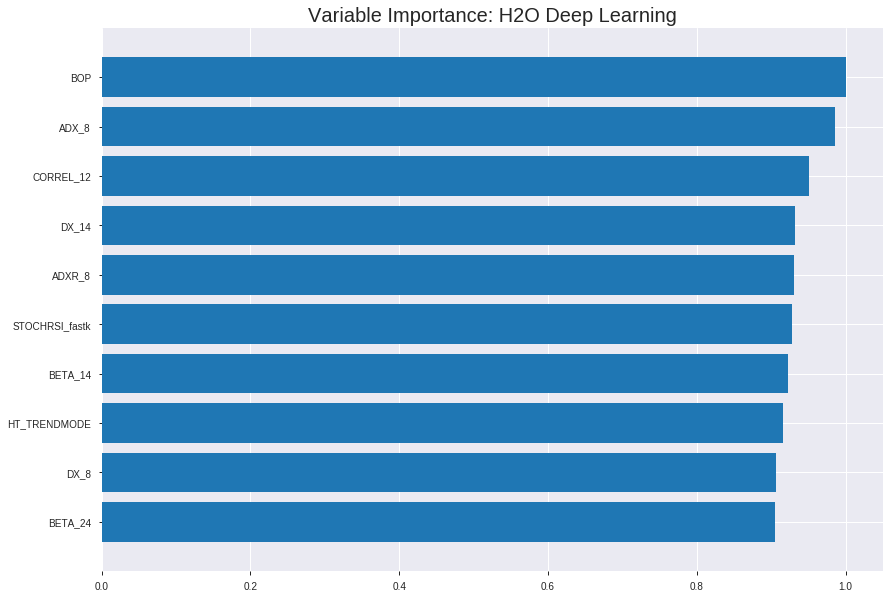

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_193108_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24791703082075242
RMSE: 0.4979126738904649
LogLoss: 0.6889517006542036
Mean Per-Class Error: 0.45366315477701624
AUC: 0.5576923076923077
pr_auc: 0.5615411981641516
Gini: 0.11538461538461542
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44463074873664277: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   820   0.9856   (820.0/832.0)
1      2    907   0.0022   (2.0/909.0)
Total  14   1727  0.4721   (822.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444631     0.688164  385
max f2                       0.426733     0.846369  392
max f0point5                 0.52895      0.593085  273
max accuracy                 0.530304     0.5583    263
max precision                0.678093     1         0
max recall                   0.426733     1         392
max specificity              0.678093     1         0
max absolute_mcc             0.52895      0.121102  273
max min_per_class_accuracy   0.539881     0.513221  199
max mean_per_class_accuracy  0.539287     0.546337  201

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 53.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.610758           1.06405   1.06405            0.555556         0.643246  0.555556                    0.643246            0.0110011       0.0110011                  6.40508   6.40508
    2        0.0201034                   0.593265           0.901314  0.985007           0.470588         0.601168  0.514286                    0.622808            0.00880088      0.019802                   -9.86863  -1.49929
    3        0.0304423                   0.588813           1.59608   1.19254            0.833333         0.591284  0.622642                    0.612102            0.0165017       0.0363036                  59.6076   19.254
    4        0.0402068                   0.58512            1.23931   1.2039             0.647059         0.586937  0.628571                    0.60599             0.0121012       0.0484048                  23.9306   20.3898
    5        0.0505457                   0.581279           1.06405   1.17529            0.555556         0.58337   0.613636                    0.601364            0.0110011       0.0594059                  6.40508   17.5293
    6        0.100517                    0.566508           1.14477   1.16012            0.597701         0.572412  0.605714                    0.58697             0.0572057       0.116612                   14.4772   16.0119
    7        0.150488                    0.554513           0.968653  1.09654            0.505747         0.561081  0.572519                    0.578373            0.0484048       0.165017                   -3.13468  9.6541
    8        0.20046                     0.545824           1.0347    1.08112            0.54023          0.550005  0.56447                     0.571302            0.0517052       0.216722                   3.46977   8.11244
    9        0.300402                    0.540441           1.10074   1.08765            0.574713         0.54241   0.567878                    0.561689            0.110011        0.326733                   10.0742   8.76512
    10       0.533027                    0.539881           1.07824   1.08354            0.562963         0.539906  0.565733                    0.552183            0.250825        0.577558                   7.82382   8.35432
    11       0.60023                     0.534472           0.949461  1.06853            0.495726         0.536355  0.557895                    0.550411            0.0638064       0.641364                   -5.05392  6.85311
    12       0.700172                    0.532342           0.847572  1.03699            0.442529         0.533291  0.541427                    0.547967            0.0847085       0.726073                   -15.2428  3.69913
    13       0.800115                    0.530713           1.14477   1.05045            0.597701         0.531598  0.548457                    0.545922            0.114411        0.840484                   14.4772   5.04542
    14       0.900057                    0.526244           0.913616  1.03526            0.477011         0.529039  0.540523                    0.544048            0.0913091       0.931793                   -8.63839  3.52597
    15       1                           0.265456           0.68246   1                  0.356322         0.493993  0.522114                    0.539045            0.0682068       1                          -31.754   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2533097021692676
RMSE: 0.5032988199561644
LogLoss: 0.6997339786959821
Mean Per-Class Error: 0.4698795180722891
AUC: 0.4909759520007742
pr_auc: 0.5296806871078018
Gini: -0.018048095998451585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45415869651986385: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    249  1        (249.0/249.0)
1      0    249  0        (0.0/249.0)
Total  0    498  0.5      (249.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454159     0.666667  399
max f2                       0.454159     0.833333  399
max f0point5                 0.454159     0.555556  399
max accuracy                 0.588027     0.53012   32
max precision                0.704111     1         0
max recall                   0.454159     1         399
max specificity              0.704111     1         0
max absolute_mcc             0.598592     0.129233  14
max min_per_class_accuracy   0.542555     0.502008  230
max mean_per_class_accuracy  0.588027     0.53012   32

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 54.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.616075           1.6       1.6                0.8              0.666371  0.8                         0.666371            0.0160643       0.0160643                  60        60
    2        0.0200803                   0.600152           1.6       1.6                0.8              0.607809  0.8                         0.63709             0.0160643       0.0321285                  60        60
    3        0.0301205                   0.598004           2         1.73333            1                0.599253  0.866667                    0.624478            0.0200803       0.0522088                  100       73.3333
    4        0.0401606                   0.592323           0.4       1.4                0.2              0.596104  0.7                         0.617385            0.00401606      0.0562249                  -60       40
    5        0.0502008                   0.591036           1.6       1.44               0.8              0.59159   0.72                        0.612226            0.0160643       0.0722892                  60        44
    6        0.100402                    0.583294           1.04      1.24               0.52             0.586824  0.62                        0.599525            0.0522088       0.124498                   4         24
    7        0.150602                    0.576728           0.8       1.09333            0.4              0.580039  0.546667                    0.59303             0.0401606       0.164659                   -20       9.33333
    8        0.200803                    0.572565           0.96      1.06               0.48             0.574971  0.53                        0.588515            0.0481928       0.212851                   -4        6
    9        0.301205                    0.55911            1         1.04               0.5              0.566683  0.52                        0.581238            0.100402        0.313253                   0         4
    10       0.399598                    0.548729           0.897959  1.00503            0.44898          0.553811  0.502513                    0.574484            0.0883534       0.401606                   -10.2041  0.502513
    11       0.5                         0.542463           1         1.00402            0.5              0.544427  0.502008                    0.568449            0.100402        0.502008                   0         0.401606
    12       0.600402                    0.540896           0.8       0.9699             0.4              0.541621  0.48495                     0.563962            0.0803213       0.582329                   -20       -3.01003
    13       0.746988                    0.539881           1.0137    0.978495           0.506849         0.54013   0.489247                    0.559286            0.148594        0.730924                   1.36986   -2.15054
    14       0.799197                    0.535974           0.846154  0.969849           0.423077         0.537511  0.484925                    0.557863            0.0441767       0.7751                     -15.3846  -3.01508
    15       0.899598                    0.526873           1         0.973214           0.5              0.533395  0.486607                    0.555132            0.100402        0.875502                   0         -2.67857
    16       1                           0.454159           1.24      1                  0.62             0.503115  0.5                         0.54991             0.124498        1           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:36:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:36:08  2 min 14.685 sec  735 obs/sec       0.626651  1             1091       0.538665         0.7897              -0.162913      0.51186         0.532026           0.851241         0.477312                         0.521016           0.739416              -0.0858289       0.47671           0.487734             0.8                0.5
    2019-08-28 19:36:20  2 min 26.435 sec  918 obs/sec       6.41298   10            11165      0.497913         0.688952            0.0063883      0.557692        0.561541           1.06405          0.472142                         0.503299           0.699734              -0.0132388       0.490976          0.529681             1.6                0.5
    2019-08-28 19:36:32  2 min 38.105 sec  1035 obs/sec      13.5192   21            23537      0.493126         0.678628            0.0254022      0.579778        0.612981           1.70248          0.461229                         0.503746           0.701182              -0.0150383       0.52225           0.537159             1.2                0.491968
    2019-08-28 19:36:43  2 min 49.585 sec  1147 obs/sec      21.78     34            37919      0.490887         0.672635            0.0342316      0.587188        0.637809           1.91529          0.443998                         0.507764           0.711154              -0.0312976       0.515016          0.516883             0.8                0.491968
    2019-08-28 19:36:55  3 min  1.711 sec  1266 obs/sec      32.0747   50            55842      0.481264         0.650645            0.0717236      0.617312        0.668968           1.91529          0.42332                          0.512305           0.7341                -0.0498269       0.550177          0.534241             0.8                0.467871
    2019-08-28 19:37:06  3 min 12.578 sec  1308 obs/sec      40.5055   63            70520      0.48181          0.649202            0.0696149      0.614248        0.64124            1.91529          0.40494                          0.529147           0.791791              -0.119986        0.534838          0.517845             0.8                0.463855
    2019-08-28 19:37:07  3 min 13.833 sec  1306 obs/sec      40.5055   63            70520      0.497913         0.688952            0.0063883      0.557692        0.561541           1.06405          0.472142                         0.503299           0.699734              -0.0132388       0.490976          0.529681             1.6                0.5

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.002409419793106336
ADX_8                     0.9858859777450562     0.9858859777450562   0.002375413188524931
CORREL_12                 0.9507479667663574     0.9507479667663574   0.0022907509693824665
DX_14                     0.9320924282073975     0.9320924282073975   0.00224580194552745
ADXR_8                    0.9310338497161865     0.9310338497161865   0.00224325138555817
---                       ---                    ---                  ---
MA_14_2                   0.7190754413604736     0.7190754413604736   0.0017325546011505997
BBANDS_middleband_14_0_4  0.7170355319976807     0.7170355319976807   0.0017276396031557434
SMA_14                    0.7115398049354553     0.7115398049354553   0.0017143980895945076
LINEARREG_INTERCEPT_12    0.7111380100250244     0.7111380100250244   0.001713429996984546
BBANDS_lowerband_20_1_2   0.710589587688446      0.710589587688446    0.0017121086173518124


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.6430517711171662)

('auc', 0.5295639798162763)

('logloss', 0.7010475886907077)

('mean_per_class_error', 0.44536809419071033)

('rmse', 0.5039244705660737)

('mse', 0.25393987203529766)

deeplearning prediction progress: |███████████████████████████████████████| 100%


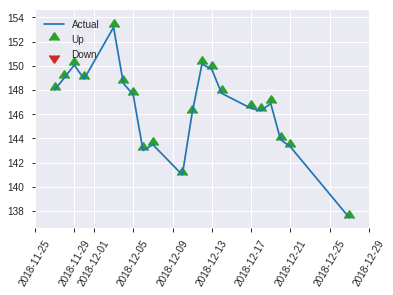


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25393987203529766
RMSE: 0.5039244705660737
LogLoss: 0.7010475886907077
Mean Per-Class Error: 0.44536809419071033
AUC: 0.5295639798162763
pr_auc: 0.5215992085304472
Gini: 0.059127959632552685
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4158110261358108: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415811     0.643052  248
max f2                       0.415811     0.818308  248
max f0point5                 0.531865     0.538302  211
max accuracy                 0.563678     0.574297  29
max precision                0.576315     0.833333  5
max recall                   0.415811     1         248
max specificity              0.587979     0.992366  0
max absolute_mcc             0.570444     0.169886  17
max min_per_class_accuracy   0.537375     0.51145   124
max mean_per_class_accuracy  0.563678     0.554632  29

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 54.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.579323           1.40678   1.40678            0.666667         0.583721  0.666667                    0.583721            0.0169492       0.0169492                  40.678    40.678
    2        0.0200803                   0.576359           2.11017   1.68814            1                0.578063  0.8                         0.581457            0.0169492       0.0338983                  111.017   68.8136
    3        0.0321285                   0.574484           0.70339   1.31886            0.333333         0.57541   0.625                       0.57919             0.00847458      0.0423729                  -29.661   31.8856
    4        0.0401606                   0.573482           1.05508   1.2661             0.5              0.57419   0.6                         0.57819             0.00847458      0.0508475                  5.50847   26.6102
    5        0.0522088                   0.572391           2.11017   1.46089            1                0.573007  0.692308                    0.576994            0.0254237       0.0762712                  111.017   46.0887
    6        0.100402                    0.566301           1.23093   1.35051            0.583333         0.568764  0.64                        0.573043            0.059322        0.135593                   23.0932   35.0508
    7        0.15261                     0.559843           0.811604  1.16615            0.384615         0.562871  0.552632                    0.569563            0.0423729       0.177966                   -18.8396  16.6146
    8        0.200803                    0.554509           0.879237  1.09729            0.416667         0.556886  0.52                        0.566521            0.0423729       0.220339                   -12.0763  9.72881
    9        0.301205                    0.54763            0.759661  0.984746           0.36             0.55035   0.466667                    0.561131            0.0762712       0.29661                    -24.0339  -1.52542
    10       0.401606                    0.540808           1.2661    1.05508            0.6              0.544768  0.5                         0.55704             0.127119        0.423729                   26.6102   5.50847
    11       0.502008                    0.537375           0.928475  1.02976            0.44             0.538591  0.488                       0.55335             0.0932203       0.516949                   -7.15254  2.97627
    12       0.598394                    0.534728           0.967161  1.01968            0.458333         0.535922  0.483221                    0.550543            0.0932203       0.610169                   -3.2839   1.96792
    13       0.698795                    0.533762           1.09729   1.03083            0.52             0.53428   0.488506                    0.548206            0.110169        0.720339                   9.72881   3.08299
    14       0.799197                    0.532794           0.928475  1.01797            0.44             0.533318  0.482412                    0.546336            0.0932203       0.813559                   -7.15254  1.79712
    15       0.899598                    0.530193           0.844068  0.998562           0.4              0.531784  0.473214                    0.544712            0.0847458       0.898305                   -15.5932  -0.143765
    16       1                           0.415811           1.01288   1                  0.48             0.503866  0.473896                    0.540611       

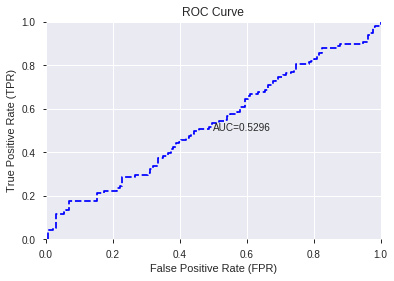

This function is available for GLM models only


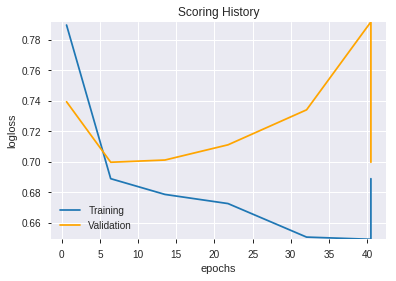

--2019-08-28 19:43:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_193108_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_193108_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'ADX_8',
 'CORREL_12',
 'DX_14',
 'ADXR_8',
 'STOCHRSI_fastk',
 'BETA_14',
 'HT_TRENDMODE',
 'DX_8',
 'BETA_24',
 'aroonup_20',
 'ADX_12',
 'aroondown_8',
 'aroondown_12',
 'aroonup_14',
 'DX_30',
 'CORREL_20',
 'AROONOSC_24',
 'WILLR_24',
 'aroondown_14',
 'MACDEXT_hist',
 'aroonup_8',
 'aroonup_30',
 'HT_PHASOR_inphase',
 'BETA_12',
 'ADX_14',
 'DX_12',
 'WILLR_8',
 'CDLHIKKAKE',
 'ADXR_14',
 'MACDFIX_hist_12',
 'BETA_8',
 'ADXR_12',
 'TRANGE',
 'DX_20',
 'CCI_14',
 'MFI_8',
 'AROONOSC_14',
 'AROONOSC_8',
 'MACD_signal',
 'LINEARREG_ANGLE_8',
 'STOCHF_fastd',
 'aroondown_30',
 'ROCR_8',
 'MFI_24',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'STOCH_slowk',
 'MFI_12',
 'PLUS_DM_30',
 'AROONOSC_20',
 'PLUS_DI_30',
 'AROONOSC_30',
 'PLUS_DM_20',
 'CORREL_8',
 'ADX_20',
 'BETA_20',
 'ROCP_8',
 'STOCHRSI_fastd',
 'ROC_30',
 'STOCH_slowd',
 'CDLDOJI',
 'ADX_24',
 'CDLHARAMI',
 'CDLLONGLINE',
 'ULTOSC',
 'CDLMORNINGSTAR',
 'aroonup_12',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'MAC

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_194406_model_1  0.52523  0.693281                   0.5  0.500063  0.250063

variable  relative_importance  scaled_importance  percentage
0                   CORREL_20             0.022551           1.000000    0.020299
1                  aroonup_20             0.022413           0.993880    0.020174
2             CDLUNIQUE3RIVER             0.016563           0.734466    0.014909
3                 aroondown_8             0.015194           0.673779    0.013677
4              STOCHRSI_fastk             0.014603           0.647550    0.013144
..                        ...                  ...                ...         ...
518  BBANDS_middleband_20_0_3             0.000020           0.000891    0.000018
519   BBANDS_lowerband_14_4_4             0.000015           0.000662    0.000013
520   BBANDS_lowerband_14_7_2             0.000012           0.000516    0.000010
521  BBANDS_middleband_20_0_5             0.000010           0.000423    0.000009
522   BBANDS_upperband_30_5_4             0.000005           0.000212    0.000004

[523 rows x 4 columns]

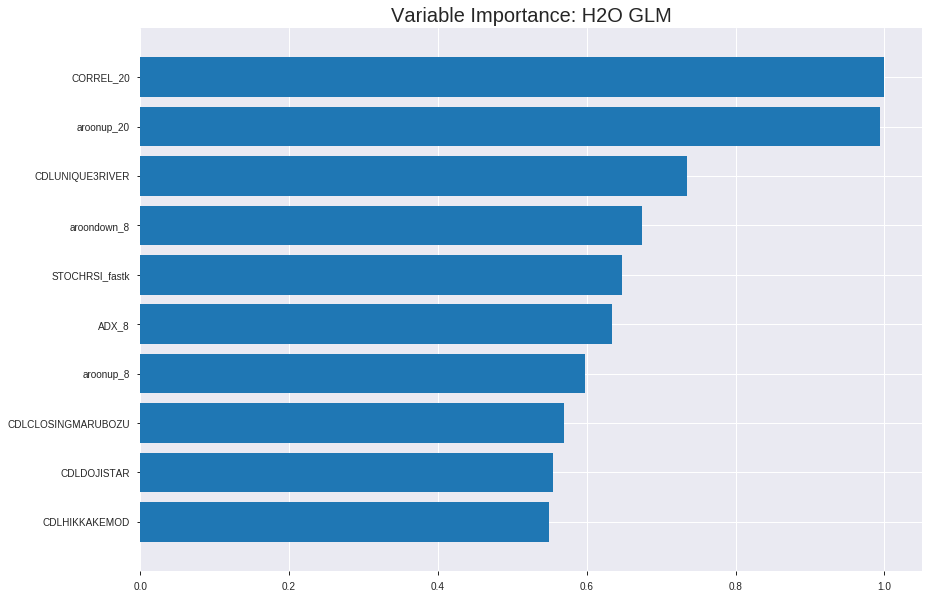

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_194406_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.243964515458708
RMSE: 0.4939276419261307
LogLoss: 0.6809761971809098
Null degrees of freedom: 1740
Residual degrees of freedom: 1217
Null deviance: 2410.1318575316827
Residual deviance: 2371.159118583928
AIC: 3419.159118583928
AUC: 0.5923748624862486
pr_auc: 0.6052060583979485
Gini: 0.1847497249724972
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44072825802005927: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      53   779   0.9363   (779.0/832.0)
1      20   889   0.022    (20.0/909.0)
Total  73   1668  0.4589   (799.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440728     0.68995   354
max f2                       0.393818     0.846211  393
max f0point5                 0.504512     0.601283  238
max accuracy                 0.504512     0.577829  238
max precision                0.642313     1         0
max recall                   0.393818     1         393
max specificity              0.642313     1         0
max absolute_mcc             0.504512     0.149802  238
max min_per_class_accuracy   0.521812     0.550055  192
max mean_per_class_accuracy  0.513619     0.572679  213

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.613547           1.48967   1.48967            0.777778         0.622713  0.777778                    0.622713            0.0154015       0.0154015                  48.9671   48.9671
    2        0.0201034                   0.606261           1.5773    1.53223            0.823529         0.609525  0.8                         0.616307            0.0154015       0.0308031                  57.7299   53.2233
    3        0.0304423                   0.600398           1.27686   1.4455             0.666667         0.603543  0.754717                    0.611972            0.0132013       0.0440044                  27.6861   44.5503
    4        0.0402068                   0.596238           1.35197   1.42279            0.705882         0.598074  0.742857                    0.608597            0.0132013       0.0572057                  35.197    42.2788
    5        0.0505457                   0.592615           1.06405   1.34941            0.555556         0.594147  0.704545                    0.605641            0.0110011       0.0682068                  6.40508   34.941
    6        0.100517                    0.578848           1.16679   1.25862            0.609195         0.5848    0.657143                    0.59528             0.0583058       0.126513                   16.6787   25.862
    7        0.150488                    0.568989           1.16679   1.22813            0.609195         0.574537  0.641221                    0.588392            0.0583058       0.184818                   16.6787   22.8126
    8        0.20046                     0.560325           1.21082   1.22381            0.632184         0.564524  0.638968                    0.582442            0.0605061       0.245325                   21.0816   22.3811
    9        0.300402                    0.546354           1.04571   1.16456            0.545977         0.552423  0.608031                    0.572455            0.10451         0.349835                   4.57051   16.4556
    10       0.400345                    0.53296            0.979661  1.1184             0.511494         0.539137  0.583931                    0.564137            0.0979098       0.447745                   -2.03394  11.8398
    11       0.500287                    0.521799           1.01268   1.09728            0.528736         0.527418  0.572905                    0.556802            0.10121         0.548955                   1.26829   9.72795
    12       0.60023                     0.511555           1.19981   1.11435            0.626437         0.51656   0.581818                    0.550101            0.119912        0.668867                   19.9809   11.4351
    13       0.700172                    0.501384           0.935631  1.08884            0.488506         0.506613  0.568499                    0.543894            0.0935094       0.762376                   -6.43691  8.88409
    14       0.800115                    0.487345           0.880594  1.06283            0.45977          0.494899  0.554917                    0.537774            0.0880088       0.850385                   -11.9406  6.28287
    15       0.900057                    0.466923           0.869586  1.04137            0.454023         0.478618  0.543714                    0.531205            0.0869087       0.937294                   -13.0414  4.1371
    16       1                           0.354889           0.627423  1                  0.327586         0.440238  0.522114                    0.522114            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24975300593318078
RMSE: 0.4997529448969568
LogLoss: 0.6926581684972634
Null degrees of freedom: 497
Residual degrees of freedom: -26
Null deviance: 691.349667579769
Residual deviance: 689.8875358232743
AIC: 1737.8875358232744
AUC: 0.5452573345591201
pr_auc: 0.5438486371056246
Gini: 0.09051466911824013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.473629691771077: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    244  0.9799   (244.0/249.0)
1      2    247  0.008    (2.0/249.0)
Total  7    491  0.494    (246.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47363      0.667568  392
max f2                       0.457665     0.833891  398
max f0point5                 0.496409     0.559322  357
max accuracy                 0.55428      0.548193  91
max precision                0.667782     1         0
max recall                   0.457665     1         398
max specificity              0.667782     1         0
max absolute_mcc             0.557646     0.121632  73
max min_per_class_accuracy   0.533637     0.53012   195
max mean_per_class_accuracy  0.554172     0.548193  92

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0100402                   0.60041            0.8      0.8                0.4              0.631917  0.4                         0.631917            0.00803213      0.00803213                 -20      -20
    2        0.0200803                   0.587289           1.6      1.2                0.8              0.591809  0.6                         0.611863            0.0160643       0.0240964                  60       20
    3        0.0301205                   0.582063           0.8      1.06667            0.4              0.584357  0.533333                    0.602694            0.00803213      0.0321285                  -20      6.66667
    4        0.0401606                   0.578546           1.2      1.1                0.6              0.580409  0.55                        0.597123            0.0120482       0.0441767                  20       10
    5        0.0502008                   0.576472           1.6      1.2                0.8              0.577571  0.6                         0.593212            0.0160643       0.060241                   60       20
    6        0.100402                    0.56648            1.28     1.24               0.64             0.571032  0.62                        0.582122            0.064257        0.124498                   28       24
    7        0.150602                    0.560031           1.28     1.25333            0.64             0.562712  0.626667                    0.575652            0.064257        0.188755                   28       25.3333
    8        0.200803                    0.555754           1.04     1.2                0.52             0.557668  0.6                         0.571156            0.0522088       0.240964                   4        20
    9        0.301205                    0.546915           0.92     1.10667            0.46             0.551537  0.553333                    0.564616            0.0923695       0.333333                   -8       10.6667
    10       0.399598                    0.540241           1.06122  1.09548            0.530612         0.543365  0.547739                    0.559383            0.104418        0.437751                   6.12245  9.54774
    11       0.5                         0.533271           0.92     1.06024            0.46             0.53669   0.53012                     0.554827            0.0923695       0.53012                    -8       6.0241
    12       0.600402                    0.526043           0.84     1.02341            0.42             0.529878  0.511706                    0.550655            0.0843373       0.614458                   -16      2.34114
    13       0.698795                    0.518564           1.10204  1.03448            0.55102          0.521957  0.517241                    0.546614            0.108434        0.722892                   10.2041  3.44828
    14       0.799197                    0.508765           0.84     1.01005            0.42             0.513412  0.505025                    0.542443            0.0843373       0.807229                   -16      1.00503
    15       0.899598                    0.49769            1.04     1.01339            0.52             0.502937  0.506696                    0.538034            0.104418        0.911647                   4        1.33929
    16       1                           0.427015           0.88     1                  0.44             0.484003  0.5                         0.532609            0.0883534       1                          -12      0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 19:44:07  0.000 sec   2            3.6       524           1.37238           1.38576
    2019-08-28 19:44:07  0.345 sec   4            2.6       524           1.37037           1.38558
    2019-08-28 19:44:08  0.808 sec   6            1.9       524           1.36797           1.38542
    2019-08-28 19:44:08  1.300 sec   8            1.4       524           1.36516           1.38532
    2019-08-28 19:44:09  1.816 sec   10           1         524           1.36195           1.38532
    2019-08-28 19:44:09  2.309 sec   12           0.73      524           1.35836           1.38547
    2019-08-28 19:44:10  2.823 sec   14           0.53      524           1.35444           1.38585
    2019-08-28 19:44:10  3.319 sec   16           0.39      524           1.35024           1.38652
    2019-08-28 19:44:11  3.840 sec   18           0.28      524           1.34586           1.38752
    2019-08-28 19:44:11  4.340 sec   20           0.21      524           1.34137           1.38888

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542168674698795)

('F1', 0.6430517711171662)

('auc', 0.525229654547807)

('logloss', 0.6932808724969484)

('mean_per_class_error', 0.45186958209341443)

('rmse', 0.5000627224439574)

('mse', 0.2500627263780624)

glm prediction progress: |████████████████████████████████████████████████| 100%


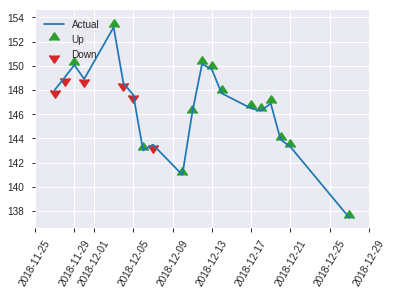


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2500627263780624
RMSE: 0.5000627224439574
LogLoss: 0.6932808724969484
Null degrees of freedom: 248
Residual degrees of freedom: -275
Null deviance: 346.8254982835162
Residual deviance: 345.2538745034803
AIC: 1393.2538745034803
AUC: 0.525229654547807
pr_auc: 0.5152176317581036
Gini: 0.050459309095614024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4334088552835617: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    131  1        (131.0/131.0)
1      0    118  0        (0.0/118.0)
Total  0    249  0.5261   (131.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433409     0.643052  248
max f2                       0.433409     0.818308  248
max f0point5                 0.433409     0.529623  248
max accuracy                 0.541363     0.554217  12
max precision                0.559558     1         0
max recall                   0.433409     1         248
max specificity              0.559558     1         0
max absolute_mcc             0.450589     0.179199  241
max min_per_class_accuracy   0.503976     0.516949  117
max mean_per_class_accuracy  0.505299     0.54813   113

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.555269           1.40678   1.40678            0.666667         0.558593  0.666667                    0.558593            0.0169492       0.0169492                  40.678    40.678
    2        0.0200803                   0.549816           2.11017   1.68814            1                0.551415  0.8                         0.555722            0.0169492       0.0338983                  111.017   68.8136
    3        0.0321285                   0.546952           0.70339   1.31886            0.333333         0.549328  0.625                       0.553324            0.00847458      0.0423729                  -29.661   31.8856
    4        0.0401606                   0.543768           2.11017   1.47712            1                0.544223  0.7                         0.551504            0.0169492       0.059322                   111.017   47.7119
    5        0.0522088                   0.541138           2.11017   1.62321            1                0.542193  0.769231                    0.549355            0.0254237       0.0847458                  111.017   62.3207
    6        0.100402                    0.533227           0.70339   1.18169            0.333333         0.536881  0.56                        0.543368            0.0338983       0.118644                   -29.661   18.1695
    7        0.15261                     0.528158           0.973924  1.11062            0.461538         0.529957  0.526316                    0.53878             0.0508475       0.169492                   -2.60756  11.0616
    8        0.200803                    0.521912           1.05508   1.09729            0.5              0.52552   0.52                        0.535597            0.0508475       0.220339                   5.50847   9.72881
    9        0.301205                    0.513702           1.18169   1.12542            0.56             0.517917  0.533333                    0.529704            0.118644        0.338983                   18.1695   12.5424
    10       0.401606                    0.509077           0.844068  1.05508            0.4              0.510945  0.5                         0.525014            0.0847458       0.423729                   -15.5932  5.50847
    11       0.502008                    0.50233            0.928475  1.02976            0.44             0.505917  0.488                       0.521195            0.0932203       0.516949                   -7.15254  2.97627
    12       0.598394                    0.4984             0.967161  1.01968            0.458333         0.500385  0.483221                    0.517843            0.0932203       0.610169                   -3.2839   1.96792
    13       0.698795                    0.491939           1.01288   1.0187             0.48             0.494597  0.482759                    0.514503            0.101695        0.711864                   1.28814   1.87025
    14       0.799197                    0.482163           1.01288   1.01797            0.48             0.48749   0.482412                    0.51111             0.101695        0.813559                   1.28814   1.79712
    15       0.899598                    0.466681           0.675254  0.979722           0.32             0.477104  0.464286                    0.507314            0.0677966       0.881356                   -32.4746  -2.02785
    16       1                           0.433409           1.18169   1                  0.56             0.455548  0.473896                    0.502117         

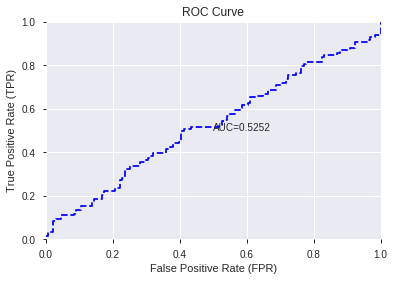

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


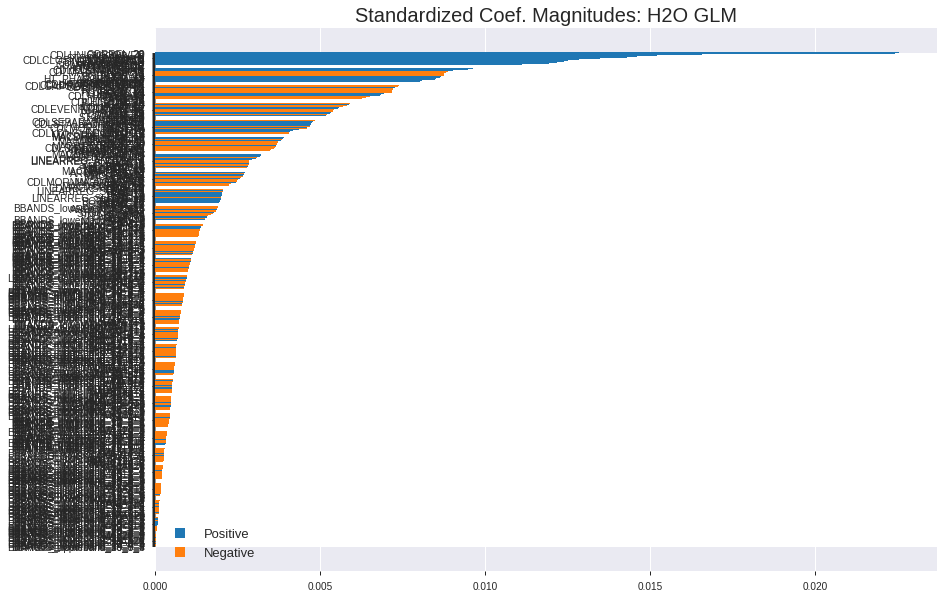

'log_likelihood'
--2019-08-28 19:44:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_194406_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_194406_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CORREL_20',
 'aroonup_20',
 'CDLUNIQUE3RIVER',
 'aroondown_8',
 'STOCHRSI_fastk',
 'ADX_8',
 'aroonup_8',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJISTAR',
 'CDLHIKKAKEMOD',
 'aroondown_14',
 'CORREL_12',
 'CDLSPINNINGTOP',
 'AROONOSC_20',
 'BOP',
 'CDL3INSIDE',
 'CDLINNECK',
 'CDLLONGLINE',
 'CDLEVENINGSTAR',
 'ADXR_8',
 'CDLMATCHINGLOW',
 'MFI_14',
 'ROCP_14',
 'ROCR100_14',
 'ROC_14',
 'CDL2CROWS',
 'WILLR_12',
 'HT_PHASOR_inphase',
 'aroonup_14',
 'aroondown_24',
 'aroonup_12',
 'STOCHF_fastk',
 'HT_TRENDMODE',
 'CDLHOMINGPIGEON',
 'CDLDRAGONFLYDOJI',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'ADX_12',
 'ROCR100_24',
 'ROCR_24',
 'PLUS_DM_30',
 'ROCP_24',
 'ROC_24',
 'CDLHARAMI',
 'WILLR_14',
 'CDLMARUBOZU',
 'ATR_30',
 'ATR_24',
 'MFI_8',
 'DX_24',
 'MOM_14',
 'PLUS_DM_24',
 'CDLHIGHWAVE',
 'BETA_14',
 'DX_20',
 'aroondown_12',
 'VAR_12',
 'CDLHIKKAKE',
 'WILLR_20',
 'CDLEVENINGDOJISTAR',
 'MFI_24',
 'ATR_14',
 'PLUS_DM_20',
 'MOM_20',
 'WILLR_24',
 'CDLTAKURI',
 'ADX_14',
 'STOCH_slowd',


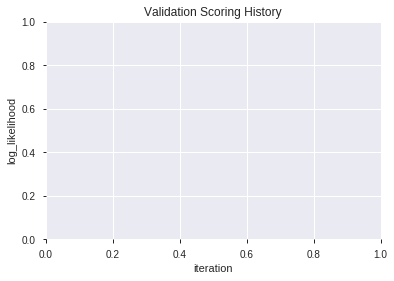

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_194525_model_1  0.519343  0.698921              0.492366  0.502771  0.252779
1               XGBoost_2_AutoML_20190828_194525  0.502458  0.712586              0.500000  0.509088  0.259170
2  XGBoost_grid_1_AutoML_20190828_194525_model_6  0.502135  0.706335              0.500000  0.506160  0.256198
3  XGBoost_grid_1_AutoML_20190828_194525_model_2  0.496830  0.706880              0.500000  0.506598  0.256641
4  XGBoost_grid_1_AutoML_20190828_194525_model_4  0.487709  0.707335              0.485574  0.506920  0.256968
5               XGBoost_3_AutoML_20190828_194525  0.484603  0.706527              0.496183  0.506472  0.256514
6  XGBoost_grid_1_AutoML_20190828_194525_model_3  0.480787  0.710848              0.500000  0.508478  0.258550
7  XGBoost_grid_1_AutoML_20190828_194525_model_5  0.460344  0.768742              0.500000  0.532484  0.283539
8               XGBoost_1_AutoML_20190828_194525  0.443589  0.732116              0.500000  0.518174  0.268505
9  XGBoost_grid_1_AutoML_20190828_194525_model_7  0.424570  0.753240              0.496183  0.527509  0.278266

variable  relative_importance  scaled_importance  percentage
0                      ADX_8           161.166412           1.000000    0.035207
1                     TRANGE           131.847794           0.818085    0.028802
2                        BOP           112.100311           0.695556    0.024488
3               aroondown_14           105.107689           0.652169    0.022961
4                    BETA_12            99.981209           0.620360    0.021841
..                       ...                  ...                ...         ...
181                  SAR_0.2             4.595072           0.028511    0.001004
182       LINEARREG_ANGLE_20             4.486009           0.027835    0.000980
183              MINUS_DM_24             4.482069           0.027810    0.000979
184  BBANDS_upperband_12_6_5             3.465994           0.021506    0.000757
185                 WILLR_12             2.936722           0.018222    0.000642

[186 rows x 4 columns]

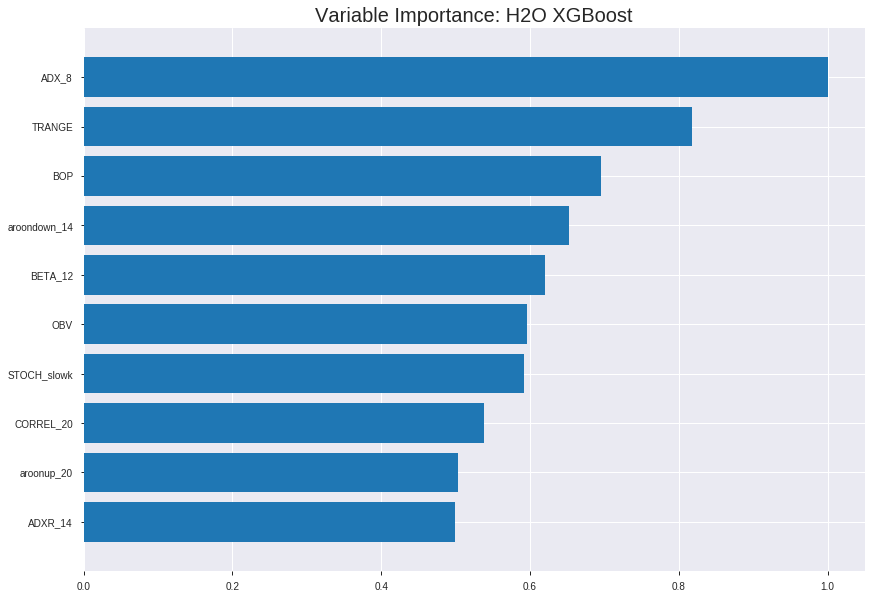

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_194525_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18731393835098045
RMSE: 0.43279780308012245
LogLoss: 0.5641874581651074
Mean Per-Class Error: 0.14790132859439797
AUC: 0.927993700812389
pr_auc: 0.9345425030744898
Gini: 0.8559874016247779
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5163928985595703: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      685  147  0.1767   (147.0/832.0)
1      112  797  0.1232   (112.0/909.0)
Total  797  944  0.1488   (259.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516393     0.860227  197
max f2                       0.450662     0.905878  266
max f0point5                 0.536732     0.875149  176
max accuracy                 0.520182     0.851809  193
max precision                0.81649      1         0
max recall                   0.301683     1         371
max specificity              0.81649      1         0
max absolute_mcc             0.536732     0.704228  176
max min_per_class_accuracy   0.525271     0.847085  188
max mean_per_class_accuracy  0.534888     0.852099  178

Gains/Lift Table: Avg response rate: 52.21 %, avg score: 52.04 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.721135           1.91529    1.91529            1                0.750574  1                           0.750574            0.019802        0.019802                   91.5292   91.5292
    2        0.0201034                   0.70364            1.91529    1.91529            1                0.711576  1                           0.731632            0.0187019       0.0385039                  91.5292   91.5292
    3        0.0304423                   0.693933           1.91529    1.91529            1                0.69855   1                           0.720397            0.019802        0.0583058                  91.5292   91.5292
    4        0.0402068                   0.68437            1.91529    1.91529            1                0.688116  1                           0.712557            0.0187019       0.0770077                  91.5292   91.5292
    5        0.0505457                   0.674396           1.91529    1.91529            1                0.680354  1                           0.70597             0.019802        0.0968097                  91.5292   91.5292
    6        0.100517                    0.643432           1.91529    1.91529            1                0.658897  1                           0.682568            0.0957096       0.192519                   91.5292   91.5292
    7        0.150488                    0.624882           1.87126    1.90067            0.977011         0.633558  0.992366                    0.666294            0.0935094       0.286029                   87.1262   90.0671
    8        0.20046                     0.608196           1.87126    1.89334            0.977011         0.616814  0.988539                    0.653959            0.0935094       0.379538                   87.1262   89.334
    9        0.300402                    0.581158           1.73917    1.84205            0.908046         0.595668  0.961759                    0.634566            0.173817        0.553355                   73.9173   84.2049
    10       0.400345                    0.556739           1.51902    1.76141            0.793103         0.569503  0.919656                    0.618324            0.151815        0.705171                   51.9024   76.1409
    11       0.500287                    0.530658           1.28787    1.66681            0.672414         0.543745  0.870264                    0.603425            0.128713        0.833883                   28.7868   66.6809
    12       0.60023                     0.502866           0.781527   1.5194             0.408046         0.514997  0.793301                    0.588701            0.0781078       0.911991                   -21.8473  51.9404
    13       0.700172                    0.472673           0.539364   1.37951            0.281609         0.488408  0.720263                    0.574385            0.0539054       0.965897                   -46.0636  37.9513
    14       0.800115                    0.429711           0.253171   1.23882            0.132184         0.451538  0.646805                    0.559041            0.0253025       0.991199                   -74.6829  23.8821
    15       0.900057                    0.381081           0.077052   1.10982            0.0402299        0.406971  0.579451                    0.542155            0.00770077      0.9989                     -92.2948  10.9818
    16       1                           0.178219           0.0110074  1                  0.00574713       0.324547  0.522114                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2511755243963786
RMSE: 0.5011741457780704
LogLoss: 0.695421269710972
Mean Per-Class Error: 0.4538152610441767
AUC: 0.5274431057563588
pr_auc: 0.5358441991425235
Gini: 0.05488621151271755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3971341848373413: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   233  0.9357   (233.0/249.0)
1      2    247  0.008    (2.0/249.0)
Total  18   480  0.4719   (235.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397134     0.677641  382
max f2                       0.397134     0.836721  382
max f0point5                 0.397134     0.569387  382
max accuracy                 0.543719     0.546185  165
max precision                0.734003     1         0
max recall                   0.31357      1         397
max specificity              0.734003     1         0
max absolute_mcc             0.397134     0.150616  382
max min_per_class_accuracy   0.531089     0.51004   192
max mean_per_class_accuracy  0.543719     0.546185  165

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.666428           1.6       1.6                0.8              0.685641  0.8                         0.685641            0.0160643       0.0160643                  60        60
    2        0.0200803                   0.660393           1.6       1.6                0.8              0.663342  0.8                         0.674492            0.0160643       0.0321285                  60        60
    3        0.0301205                   0.65176            1.2       1.46667            0.6              0.656431  0.733333                    0.668471            0.0120482       0.0441767                  20        46.6667
    4        0.0401606                   0.646393           0.8       1.3                0.4              0.649951  0.65                        0.663841            0.00803213      0.0522088                  -20       30
    5        0.0502008                   0.639107           1.2       1.28               0.6              0.643081  0.64                        0.659689            0.0120482       0.064257                   20        28
    6        0.100402                    0.617833           0.8       1.04               0.4              0.62807   0.52                        0.64388             0.0401606       0.104418                   -20       4
    7        0.150602                    0.603306           1.12      1.06667            0.56             0.609599  0.533333                    0.632453            0.0562249       0.160643                   12        6.66667
    8        0.200803                    0.588996           1.04      1.06               0.52             0.597069  0.53                        0.623607            0.0522088       0.212851                   4         6
    9        0.301205                    0.569252           1.12      1.08               0.56             0.57923   0.54                        0.608815            0.11245         0.325301                   12        8
    10       0.399598                    0.547625           1.18367   1.10553            0.591837         0.559448  0.552764                    0.596659            0.116466        0.441767                   18.3673   10.5528
    11       0.5                         0.53079            0.68      1.02008            0.34             0.53906   0.51004                     0.585093            0.0682731       0.51004                    -32       2.00803
    12       0.600402                    0.514721           1         1.01672            0.5              0.52271   0.508361                    0.574661            0.100402        0.610442                   0         1.67224
    13       0.698795                    0.497236           0.857143  0.994253           0.428571         0.505371  0.497126                    0.564905            0.0843373       0.694779                   -14.2857  -0.574713
    14       0.799197                    0.465931           1.08      1.00503            0.54             0.48433   0.502513                    0.554782            0.108434        0.803213                   8         0.502513
    15       0.899598                    0.433394           1.2       1.02679            0.6              0.44837   0.513393                    0.542906            0.120482        0.923695                   20        2.67857
    16       1                           0.282628           0.76      1                  0.38             0.394683  0.5                         0.528024            0.0763052       1               


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:45:34  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.477886                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-28 19:45:35  0.607 sec   5                  0.489492         0.672293            0.748244        0.753736           1.91529          0.323952                         0.499752           0.692653              0.516726          0.504436             0.8                0.48996
    2019-08-28 19:45:35  0.733 sec   10                 0.480636         0.654896            0.799533        0.810463           1.91529          0.295233                         0.500178           0.693524              0.52225           0.502659             0.4                0.493976
    2019-08-28 19:45:35  0.867 sec   15                 0.471431         0.63701             0.84739         0.855911           1.91529          0.253877                         0.499396           0.69194               0.528975          0.517926             0.8                0.487952
    2019-08-28 19:45:35  0.990 sec   20                 0.466135         0.626783            0.855461        0.863532           1.91529          0.238943                         0.49929            0.691707              0.53              0.524059             1.2                0.477912
    2019-08-28 19:45:36  1.114 sec   25                 0.459635         0.614328            0.874105        0.884012           1.91529          0.21884                          0.499388           0.6919                0.532024          0.5288               0.8                0.47992
    2019-08-28 19:45:36  1.238 sec   30                 0.454318         0.604266            0.888923        0.898082           1.91529          0.198162                         0.500018           0.693156              0.528532          0.532098             1.6                0.477912
    2019-08-28 19:45:36  1.357 sec   35                 0.449133         0.594445            0.895041        0.90591            1.91529          0.188972                         0.50033            0.693781              0.528959          0.531303             1.6                0.475904
    2019-08-28 19:45:36  1.469 sec   40                 0.444181         0.585163            0.906533        0.915092           1.91529          0.182654                         0.500676           0.694463              0.525935          0.530399             1.6                0.47992
    2019-08-28 19:45:36  1.588 sec   45                 0.43883          0.575207            0.915621        0.92273            1.91529          0.164273                         0.501247           0.695631              0.525637          0.531122             1.6                0.481928
    2019-08-28 19:45:36  1.714 sec   50                 0.432798         0.564187            0.927994        0.934543           1.91529          0.148765                         0.501174           0.695421              0.527443          0.535844             1.6                0.471888

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
ADX_8                    161.16641235351562     1.0                   0.03520659164355373
TRANGE                   131.84779357910156     0.8180848084518739    0.02880197778096
BOP                      112.10031127929688     0.6955562864637507    0.024488166142635947
aroondown_14             105.1076889038086      0.6521686955049714    0.022960636945352664
BETA_12                  99.98120880126953      0.6203600821116657    0.021840764082866875
---                      ---                    ---                   ---
SAR_0.2                  4.595072269439697      0.028511351728550544  0.0010037875175128088
LINEARREG_ANGLE_20       4.486009120941162      0.0278346403287875    0.0009799628156008137
MINUS_DM_24              4.48206901550293       0.027810192893489443  0.0009791021047295429
BBANDS_upperband_12_6_5  3.465993881225586      0.021505683663311875  0.0007571418227496658
WILLR_12                 2.9367218017578125     0.01822167385172145   0.0006415230303595779


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5662650602409639)

('F1', 0.6465753424657534)

('auc', 0.5193427351533186)

('logloss', 0.6989212734172869)

('mean_per_class_error', 0.44417130288523743)

('rmse', 0.5027708482525981)

('mse', 0.25277852585263705)

xgboost prediction progress: |████████████████████████████████████████████| 100%


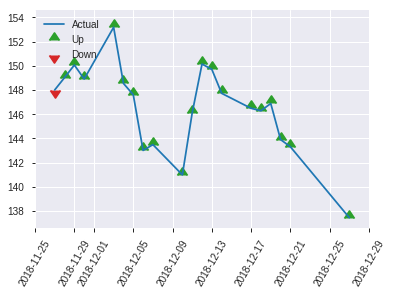


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25277852585263705
RMSE: 0.5027708482525981
LogLoss: 0.6989212734172869
Mean Per-Class Error: 0.44417130288523743
AUC: 0.5193427351533186
pr_auc: 0.48828493164512365
Gini: 0.03868547030663727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3213309943675995: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    129  0.9847   (129.0/131.0)
1      0    118  0        (0.0/118.0)
Total  2    247  0.5181   (129.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321331     0.646575  244
max f2                       0.321331     0.820584  244
max f0point5                 0.321331     0.533454  244
max accuracy                 0.539379     0.566265  73
max precision                0.649572     1         0
max recall                   0.321331     1         244
max specificity              0.649572     1         0
max absolute_mcc             0.539379     0.121991  73
max min_per_class_accuracy   0.509926     0.503817  123
max mean_per_class_accuracy  0.539379     0.555829  73

Gains/Lift Table: Avg response rate: 47.39 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.620083           0.70339   0.70339            0.333333         0.635622  0.333333                    0.635622            0.00847458      0.00847458                 -29.661   -29.661
    2        0.0200803                   0.607987           1.05508   0.844068           0.5              0.614133  0.4                         0.627026            0.00847458      0.0169492                  5.50847   -15.5932
    3        0.0321285                   0.598626           0.70339   0.791314           0.333333         0.602484  0.375                       0.617823            0.00847458      0.0254237                  -29.661   -20.8686
    4        0.0401606                   0.597493           0         0.633051           0                0.598042  0.3                         0.613867            0               0.0254237                  -100      -36.6949
    5        0.0522088                   0.595657           2.11017   0.973924           1                0.596723  0.461538                    0.60991             0.0254237       0.0508475                  111.017   -2.60756
    6        0.100402                    0.580787           1.23093   1.09729            0.583333         0.589994  0.52                        0.600351            0.059322        0.110169                   23.0932   9.72881
    7        0.15261                     0.566871           0.973924  1.05508            0.461538         0.574465  0.5                         0.591495            0.0508475       0.161017                   -2.60756  5.50847
    8        0.200803                    0.555342           1.40678   1.13949            0.666667         0.561083  0.54                        0.584196            0.0677966       0.228814                   40.678    13.9492
    9        0.301205                    0.538961           1.2661    1.18169            0.6              0.548293  0.56                        0.572229            0.127119        0.355932                   26.6102   18.1695
    10       0.401606                    0.524333           0.759661  1.07619            0.36             0.531252  0.51                        0.561984            0.0762712       0.432203                   -24.0339  7.61864
    11       0.502008                    0.509926           0.759661  1.01288            0.36             0.515518  0.48                        0.552691            0.0762712       0.508475                   -24.0339  1.28814
    12       0.598394                    0.4977             0.967161  1.00552            0.458333         0.504087  0.47651                     0.544862            0.0932203       0.601695                   -3.2839   0.551701
    13       0.698795                    0.481171           0.759661  0.970193           0.36             0.491223  0.45977                     0.537155            0.0762712       0.677966                   -24.0339  -2.98071
    14       0.799197                    0.457557           1.35051   1.01797            0.64             0.469793  0.482412                    0.528693            0.135593        0.813559                   35.0508   1.79712
    15       0.899598                    0.407292           0.844068  0.998562           0.4              0.436641  0.473214                    0.518419            0.0847458       0.898305                   -15.5932  -0.143765
    16       1                           0.292754           1.01288   1                  0.48             0.360805  0.473896                    0.502594 

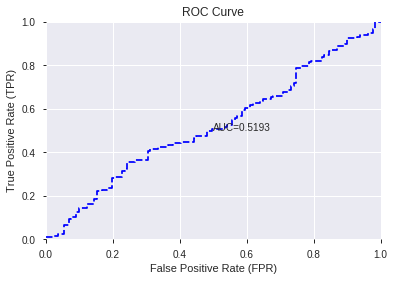

This function is available for GLM models only


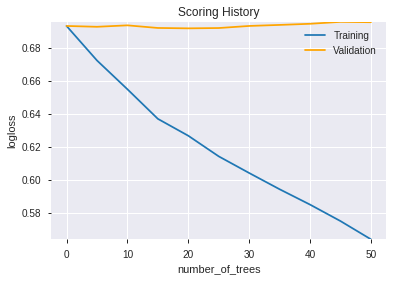

--2019-08-28 19:46:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_194525_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_194525_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_84e8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['ADX_8',
 'TRANGE',
 'BOP',
 'aroondown_14',
 'BETA_12',
 'OBV',
 'STOCH_slowk',
 'CORREL_20',
 'aroonup_20',
 'ADXR_14',
 'WILLR_20',
 'DX_8',
 'WILLR_30',
 'MACD_hist',
 'CORREL_12',
 'STOCH_slowd',
 'DX_24',
 'ROC_8',
 'PLUS_DM_24',
 'MOM_8',
 'BBANDS_lowerband_20_2_5',
 'MFI_8',
 'BETA_24',
 'NATR_14',
 'STDDEV_20',
 'PPO',
 'STOCHRSI_fastd',
 'CCI_8',
 'AROONOSC_8',
 'CCI_30',
 'ATR_8',
 'MACDFIX_signal_12',
 'ADX_24',
 'NATR_24',
 'MOM_20',
 'HT_PHASOR_inphase',
 'ATR_30',
 'MACDFIX_signal_8',
 'BETA_14',
 'MACDEXT_signal',
 'ADX_20',
 'ADXR_8',
 'MOM_30',
 'HT_PHASOR_quadrature',
 'MACDFIX_hist_20',
 'BETA_20',
 'ROC_24',
 'MFI_14',
 'MFI_24',
 'MA_20_2',
 'BBANDS_lowerband_20_6_2',
 'ROC_30',
 'aroondown_8',
 'MACDEXT_hist',
 'ADX_14',
 'LINEARREG_ANGLE_8',
 'MINUS_DI_30',
 'AROONOSC_12',
 'aroondown_12',
 'PLUS_DM_20',
 'STDDEV_8',
 'MACDFIX_signal_14',
 'ROC_20',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_lowerband_30_5_5',
 'aroondown_30',
 'CCI_14',
 'BETA_8',
 'STOCHF_fastk',
 

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.578
GLM             0.554
XGBoost         0.574
dtype: float64

DeepLearning    GLM  XGBoost
All          0.566  0.542    0.546
DLF          0.562  0.550    0.574
Fwe          0.566  0.542    0.546
RFE          0.574  0.554    0.566
XGBF         0.578  0.550    0.574





F1


DeepLearning    0.646
GLM             0.643
XGBoost         0.653
dtype: float64

DeepLearning    GLM  XGBoost
All          0.643  0.643    0.643
DLF          0.643  0.643    0.653
Fwe          0.646  0.643    0.643
RFE          0.643  0.643    0.647
XGBF         0.645  0.643    0.653





auc


DeepLearning    0.559
GLM             0.525
XGBoost         0.554
dtype: float64

DeepLearning    GLM  XGBoost
All          0.559  0.505    0.526
DLF          0.539  0.507    0.554
Fwe          0.552  0.505    0.526
RFE          0.530  0.525    0.519
XGBF         0.549  0.507    0.554





logloss


DeepLearning    0.937
GLM             0.696
XGBoost         0.730
dtype: float64

DeepLearning    GLM  XGBoost
All          0.690  0.694    0.730
DLF          0.754  0.696    0.687
Fwe          0.690  0.694    0.730
RFE          0.701  0.693    0.699
XGBF         0.937  0.696    0.687





mean_per_class_error


DeepLearning    0.446
GLM             0.473
XGBoost         0.446
dtype: float64

DeepLearning    GLM  XGBoost
All          0.437  0.473    0.446
DLF          0.434  0.470    0.437
Fwe          0.446  0.473    0.446
RFE          0.445  0.452    0.444
XGBF         0.417  0.470    0.437





rmse


DeepLearning    0.557
GLM             0.501
XGBoost         0.515
dtype: float64

DeepLearning    GLM  XGBoost
All          0.498  0.500    0.515
DLF          0.519  0.501    0.497
Fwe          0.499  0.500    0.515
RFE          0.504  0.500    0.503
XGBF         0.557  0.501    0.497





mse


DeepLearning    0.311
GLM             0.251
XGBoost         0.265
dtype: float64

DeepLearning    GLM  XGBoost
All          0.248  0.250    0.265
DLF          0.269  0.251    0.247
Fwe          0.249  0.250    0.265
RFE          0.254  0.250    0.253
XGBF         0.311  0.251    0.247

{'F1':       DeepLearning    GLM  XGBoost
 All          0.643    NaN      NaN
 DLF          0.643    NaN      NaN
 DLF            NaN  0.643      NaN
 DLF            NaN    NaN    0.653
 All            NaN  0.643      NaN
 All            NaN    NaN    0.643
 XGBF         0.645    NaN      NaN
 XGBF           NaN  0.643      NaN
 XGBF           NaN    NaN    0.653
 Fwe          0.646    NaN      NaN
 Fwe            NaN  0.643      NaN
 Fwe            NaN    NaN    0.643
 RFE          0.643    NaN      NaN
 RFE            NaN  0.643      NaN
 RFE            NaN    NaN    0.647,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.566    NaN      NaN
 DLF          0.562    NaN      NaN
 DLF            NaN  0.550      NaN
 DLF            NaN    NaN    0.574
 All            NaN  0.542      NaN
 All            NaN    NaN    0.546
 XGBF         0.578    NaN      NaN
 XGBF           NaN  0.550      NaN
 XGBF           NaN    NaN    0.574
 Fwe          0.566    NaN      NaN
 Fwe     